In [1]:
!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn
!pip install opencv-python-headless 
!pip install torch torchvision pandas numpy matplotlib seaborn opencv-python scikit-learn Pillow imblearn tqdm
!pip install pandas lime scikit-image -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 79.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-le

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt # Kept for final plot only

# --- 1. CONFIGURATION: Your model paths ---
MODEL1_PATH = '/kaggle/input/ourensemble1/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3d/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
TEST_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'
IMAGE_SIZE = (224, 224)

# --- 2. SETUP: Basic functions and device configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

def calculate_metrics(preds, targets, smooth=1e-6):
    """Calculates Dice and IoU from raw logits and target masks."""
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    
    # Flatten tensors for metric calculation
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1) 
    
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

# --- 3. DATAFRAME CREATION AND MERGE (Simplified) ---
print("\n--- Creating Test DataFrames ---")
try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df.dropna(subset=['class_name'], inplace=True)
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory): return pd.DataFrame(data)
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir, masks_dir = os.path.join(folder_path, 'images'), os.path.join(folder_path, 'masks')
                if os.path.exists(images_dir) and os.path.exists(masks_dir):
                    for image_file in os.listdir(images_dir):
                        image_path = os.path.join(images_dir, image_file)
                        mask_path = os.path.join(masks_dir, image_file)
                        if os.path.exists(mask_path): data.append((folder_name, image_path, mask_path))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    test_df = create_dataframe_from_ids(TEST_DIR, valid_ids)
    test_df = pd.merge(test_df, metadata_df[['ID', 'class_name']], on='ID')
    if test_df.empty: raise FileNotFoundError("Could not find any valid test images and masks.")
    print(f"Test DataFrame loaded with {len(test_df)} samples.")
except Exception as e:
    print(f"Error during data setup: {e}")
    test_df = None

# --- 4. DATASET AND TRANSFORMS ---
class SegmentationTransform:
    def __init__(self, image_size=IMAGE_SIZE):
        self.image_size = image_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __call__(self, image, mask):
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        image_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask)
        return self.normalize(image_tensor), (mask_tensor > 0).float()

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        mask_pil = Image.open(row['mask_file_path']).convert('L')
        image, mask = self.transform(image_pil, mask_pil)
        # Added class_name to the return to facilitate class-specific evaluation
        return image, mask, row['class_name'] 

# --- 5. MODEL ARCHITECTURE DEFINITIONS (Unchanged) ---
# Keeping only the necessary classes for loading

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__(); self.conv = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True), nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__(); self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False); self.bn1 = nn.BatchNorm2d(out_channels); self.relu = nn.ReLU(inplace=True); self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False); self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True); x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x))); x = self.relu(self.bn2(self.conv2(x))); return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__(); base_model = models.resnet50(weights=None); base_layers = list(base_model.children()); self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5]); self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]; self.decoder3 = DecoderBlock(2048, 1024, 512); self.decoder2 = DecoderBlock(512, 512, 256); self.decoder1 = DecoderBlock(256, 256, 128); self.decoder0 = DecoderBlock(128, 64, 64); self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3); d3=self.decoder3(e4,e3); d2=self.decoder2(d3,e2); d1=self.decoder1(d2,e1); d0=self.decoder0(d1,e0); out = F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True); return self.final_conv(out)

class TransUNetPP(nn.Module):
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__(); base_model = models.resnet50(weights=None); base_layers = list(base_model.children()); self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5]); self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]; num_patches, self.patch_dim = (img_dim // 32) ** 2, 2048; self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim)); self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim); transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True); self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth); self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim)); d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}; self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True); self.X_0_0=ConvBlock(64,d_ch['d0']); self.X_1_0=ConvBlock(256,d_ch['d1']); self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0']); self.X_2_0=ConvBlock(512,d_ch['d2']); self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']); self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0']); self.X_3_0=ConvBlock(1024,d_ch['d3']); self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']); self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']); self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0']); self.X_4_0=ConvBlock(2048,d_ch['d4']); self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']); self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']); self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']); self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0']); self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3); bs,_,h,w = e4.shape; trans_in = self.patch_to_embedding(e4.flatten(2).transpose(1, 2)) + self.pos_embedding; trans_out = self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1, 2).view(bs, self.patch_dim, h, w); x0_0=self.X_0_0(e0); x1_0=self.X_1_0(e1); x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1)); x2_0=self.X_2_0(e2); x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1)); x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1)); x3_0=self.X_3_0(e3); x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1)); x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1)); x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1)); x4_0=self.X_4_0(trans_out); x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1)); x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1)); x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1)); x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1)); out = F.interpolate(self.final_conv(x0_4), scale_factor=2, mode='bilinear', align_corners=True); return out

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__(); self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int)); self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int)); self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid()); self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x)); return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__(); base = models.resnet50(weights=None); layers = list(base.children()); self.encoder0, self.encoder1 = nn.Sequential(*layers[:3]), nn.Sequential(*layers[3:5]); self.encoder2, self.encoder3, self.encoder4 = layers[5], layers[6], layers[7]; self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2); self.attn3 = AttentionGate(1024, 1024, 512); self.dec_conv3 = ConvBlock(2048, 1024); self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2); self.attn2 = AttentionGate(512, 512, 256); self.dec_conv2 = ConvBlock(1024, 512); self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2); self.attn1 = AttentionGate(256, 256, 128); self.dec_conv1 = ConvBlock(512, 256); self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2); self.attn0 = AttentionGate(64, 64, 32); self.dec_conv0 = ConvBlock(128, 64); self.final_up = nn.ConvTranspose2d(64, 32, 2, 2); self.final_conv = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3); d3=self.upconv3(e4); x3=self.attn3(d3,e3); d3=self.dec_conv3(torch.cat((x3,d3),1)); d2=self.upconv2(d3); x2=self.attn2(d2,e2); d2=self.dec_conv2(torch.cat((x2,d2),1)); d1=self.upconv1(d2); x1=self.attn1(d1,e1); d1=self.dec_conv1(torch.cat((x1,d1),1)); d0=self.upconv0(d1); x0=self.attn0(d0,e0); d0=self.dec_conv0(torch.cat((x0,d0),1)); return self.final_conv(self.final_up(d0))

# --- 6. LOADING MODELS ---
models_loaded = False
if test_df is not None:
    try:
        print("\nLoading segmentation models...")
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device)
        model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device))
        model1.eval()

        model2 = TransUNetPP(n_classes=1).to(device)
        model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
        model2.eval()

        model3 = AttentionUNet(n_classes=1).to(device)
        model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
        model3.eval()

        print("All models loaded successfully! ✅")
        models_loaded = True
    except Exception as e:
        print(f"\n--- MODEL LOADING FAILED --- ❌\nError: {e}")

# =================================================================================
# --- 7. ENSEMBLE PREDICTION AND METRICS (Simplified) ---
# =================================================================================

if models_loaded:
    test_transform = SegmentationTransform()
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    all_preds1, all_preds2, all_preds3, all_gt_masks, all_class_names = [], [], [], [], []
    print("\nGenerating ensemble predictions...")
    
    with torch.no_grad():
        for images, masks, class_names in tqdm(test_loader):
            images = images.to(device)
            # Collect raw logits (predictions)
            all_preds1.append(model1(images).cpu())
            all_preds2.append(model2(images).cpu())
            all_preds3.append(model3(images).cpu())
            
            # Collect ground truth and class names
            all_gt_masks.append(masks.cpu())
            all_class_names.extend(class_names)

    # Concatenate all predictions and masks
    preds1 = torch.cat(all_preds1)
    preds2 = torch.cat(all_preds2)
    preds3 = torch.cat(all_preds3)
    ground_truth_masks = torch.cat(all_gt_masks)

    # Ensemble: Average the raw logits (Soft Voting)
    ensembled_preds = torch.mean(torch.stack([preds1, preds2, preds3]), dim=0)

    # --- 7.1 OVERALL ENSEMBLE METRICS ---
    print("\n--- Overall Ensembled Performance (All Classes Combined) ---")
    ensembled_dice, ensembled_iou = calculate_metrics(ensembled_preds, ground_truth_masks)
    print(f"Ensembled Dice Score: {ensembled_dice:.4f}")
    print(f"Ensembled mIoU Score: {ensembled_iou:.4f}")

    # --- 7.2 CLASS-SPECIFIC ENSEMBLE METRICS ---
    print("\n--- Class-Specific Ensembled Performance ---")
    
    # Attach ensemble predictions and masks to the test DataFrame
    test_df_results = test_df.copy()
    test_df_results['ensembled_preds'] = list(ensembled_preds.unbind(0))
    test_df_results['gt_masks'] = list(ground_truth_masks.unbind(0))
    
    class_metrics = {}
    
    # Group by class name and calculate metrics for each group
    for class_name, group in test_df_results.groupby('class_name'):
        # Stack the tensors back for batch processing the metrics
        class_preds = torch.stack(group['ensembled_preds'].tolist())
        class_gts = torch.stack(group['gt_masks'].tolist())
        
        # Calculate metrics for the class
        dice, iou = calculate_metrics(class_preds, class_gts)
        class_metrics[class_name] = {'Dice': dice, 'IoU': iou}

    # Display results
    print("\n| Class | Dice Score | mIoU Score |")
    print("|:---:|:---:|:---:|")
    for cls, metrics in sorted(class_metrics.items()):
        print(f"| {cls} | {metrics['Dice']:.4f} | {metrics['IoU']:.4f} |")

else:
    print("\nSkipping metric calculation due to model loading or data setup errors.")

Using device: cuda ⚙️

--- Creating Test DataFrames ---
Test DataFrame loaded with 664 samples.

Loading segmentation models...
All models loaded successfully! ✅

Generating ensemble predictions...


100%|██████████| 42/42 [00:31<00:00,  1.33it/s]



--- Overall Ensembled Performance (All Classes Combined) ---
Ensembled Dice Score: 0.9516
Ensembled mIoU Score: 0.9077

--- Class-Specific Ensembled Performance ---

| Class | Dice Score | mIoU Score |
|:---:|:---:|:---:|
| Mild | 0.9523 | 0.9089 |
| Moderate | 0.9524 | 0.9092 |
| Severe | 0.9490 | 0.9029 |


Ensemble

Using device: cuda ⚙️

--- Creating DataFrames ---
Metadata loaded and processed successfully.
Successfully created and merged test_df with 664 samples.
Class distribution in test set:
 class_name
Mild        350
Severe      181
Moderate    133
Name: count, dtype: int64

Loading all three models from specified paths...
All models loaded successfully! ✅

Generating predictions and collecting ground truths...


100%|██████████| 42/42 [00:27<00:00,  1.55it/s]



Ensembling predictions...

--- Final Ensembled Performance ---
Ensembled Dice Score: 0.9516
Ensembled mIoU Score:  0.9077

--- Individual Model Performance ---
Model 1 (UNet-ResNet50) -> Dice: 0.9483, mIoU: 0.9017
Model 2 (TransUNetPP)   -> Dice: 0.9416, mIoU: 0.8896
Model 3 (AttentionUNet) -> Dice: 0.9477, mIoU: 0.9007

--- Visualizing One Sample Per Class ---

Generating Full Analysis for Class 'Moderate' (Sample Index 0)...


  0%|          | 0/1000 [00:00<?, ?it/s]

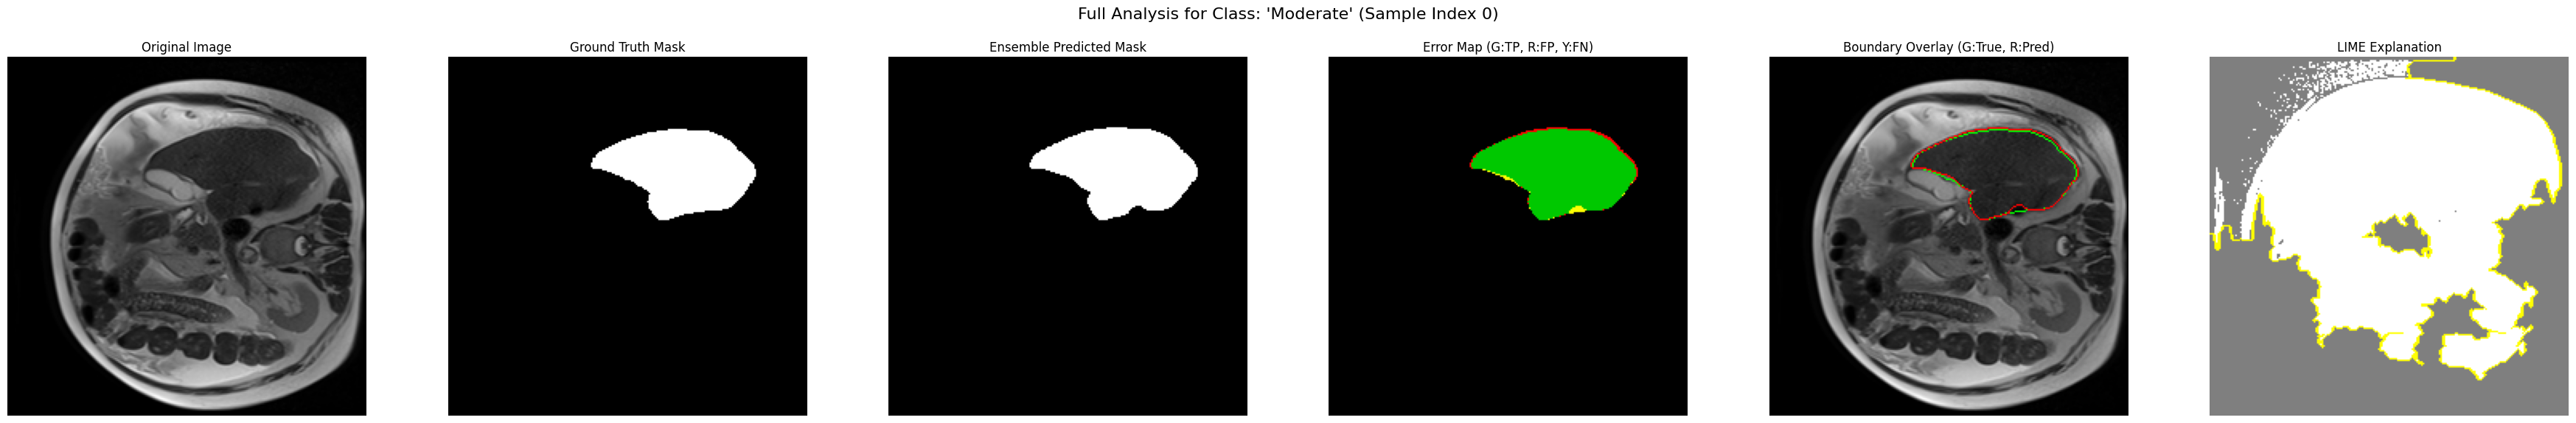


Generating Full Analysis for Class 'Mild' (Sample Index 50)...


  0%|          | 0/1000 [00:00<?, ?it/s]

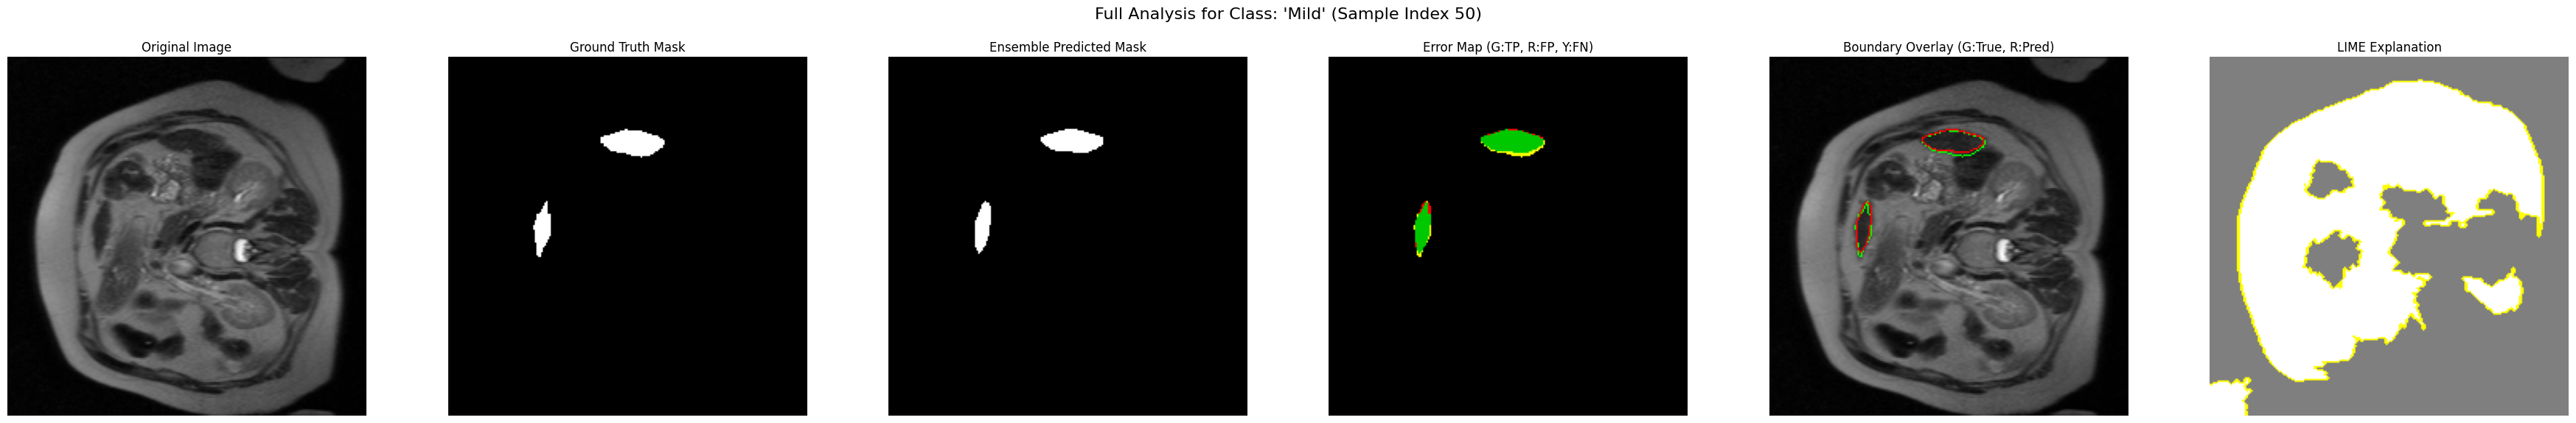


Generating Full Analysis for Class 'Severe' (Sample Index 104)...


  0%|          | 0/1000 [00:00<?, ?it/s]

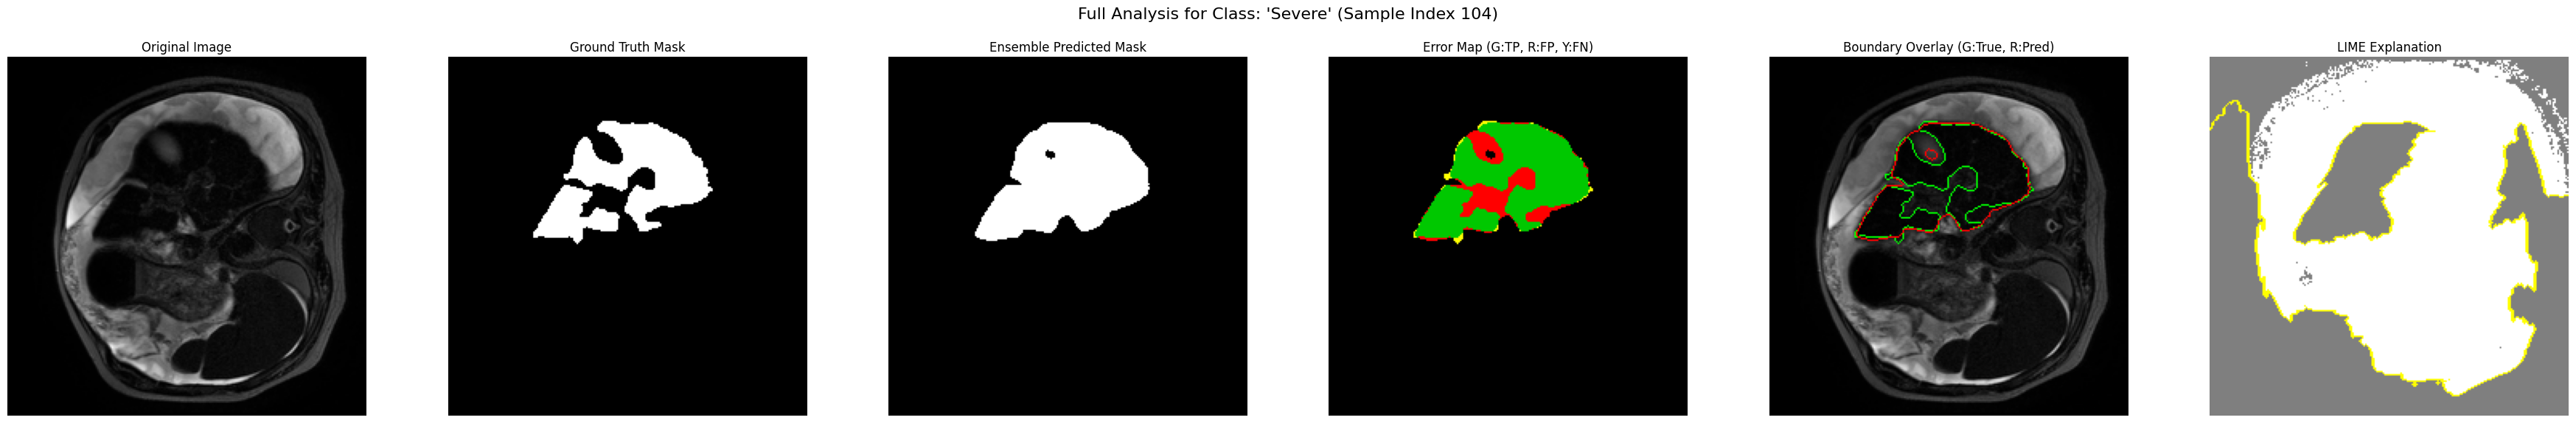



--- Starting Classification Stage ---

Preparing dataframes for classification...

An error occurred during the classification stage: 'ID'


In [5]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import mark_boundaries, find_boundaries
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from lime import lime_image
from tqdm import tqdm

# --- 1. CONFIGURATION: Your model paths ---
MODEL1_PATH = '/kaggle/input/ourensemble1/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3d/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
TEST_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

# --- 2. SETUP: Basic functions and device configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# CORRECTED FUNCTION
def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1) # The fix is here
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

# --- 3. DATAFRAME CREATION AND MERGE ---
print("\n--- Creating DataFrames ---")
try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df.dropna(subset=['class_name'], inplace=True)
    print("Metadata loaded and processed successfully.")
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory): return pd.DataFrame(data)
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir, masks_dir = os.path.join(folder_path, 'images'), os.path.join(folder_path, 'masks')
                if os.path.exists(images_dir) and os.path.exists(masks_dir):
                    for image_file in os.listdir(images_dir):
                        image_path = os.path.join(images_dir, image_file)
                        mask_path = os.path.join(masks_dir, image_file)
                        if os.path.exists(mask_path): data.append((folder_name, image_path, mask_path))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    test_df = create_dataframe_from_ids(TEST_DIR, valid_ids)
    test_df = pd.merge(test_df, metadata_df[['ID', 'class_name']], on='ID')
    if test_df.empty: raise FileNotFoundError("Could not find any valid test images and masks.")
    print(f"Successfully created and merged test_df with {len(test_df)} samples.")
    print("Class distribution in test set:\n", test_df['class_name'].value_counts())
except Exception as e:
    print(f"Error during data setup: {e}")
    test_df = None

# --- 4. DATASET AND TRANSFORMS ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __call__(self, image, mask):
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        image_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask)
        return self.normalize(image_tensor), (mask_tensor > 0).float()

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        mask_pil = Image.open(row['mask_file_path']).convert('L')
        image, mask = self.transform(image_pil, mask_pil)
        return image, mask, row['image_file_path'], row['class_name']

# --- 5. MODEL ARCHITECTURE DEFINITIONS ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        self.decoder3 = DecoderBlock(2048, 1024, 512)
        self.decoder2 = DecoderBlock(512, 512, 256)
        self.decoder1 = DecoderBlock(256, 256, 128)
        self.decoder0 = DecoderBlock(128, 64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.decoder3(e4,e3); d2=self.decoder2(d3,e2); d1=self.decoder1(d2,e1); d0=self.decoder0(d1,e0)
        out = F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True)
        return self.final_conv(out)

class TransUNetPP(nn.Module):
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        num_patches, self.patch_dim = (img_dim // 32) ** 2, 2048
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim))
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.X_0_0=ConvBlock(64,d_ch['d0']); self.X_1_0=ConvBlock(256,d_ch['d1']); self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0'])
        self.X_2_0=ConvBlock(512,d_ch['d2']); self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']); self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0'])
        self.X_3_0=ConvBlock(1024,d_ch['d3']); self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']); self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']); self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0'])
        self.X_4_0=ConvBlock(2048,d_ch['d4']); self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']); self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']); self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']); self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0'])
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        bs,_,h,w = e4.shape
        trans_in = self.patch_to_embedding(e4.flatten(2).transpose(1, 2)) + self.pos_embedding
        trans_out = self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1, 2).view(bs, self.patch_dim, h, w)
        x0_0=self.X_0_0(e0); x1_0=self.X_1_0(e1); x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1))
        x2_0=self.X_2_0(e2); x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1)); x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1))
        x3_0=self.X_3_0(e3); x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1)); x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1)); x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1))
        x4_0=self.X_4_0(trans_out); x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1)); x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1)); x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1)); x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1))
        out = F.interpolate(self.final_conv(x0_4), scale_factor=2, mode='bilinear', align_corners=True)
        return out

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base = models.resnet50(weights=None)
        layers = list(base.children())
        self.encoder0, self.encoder1 = nn.Sequential(*layers[:3]), nn.Sequential(*layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = layers[5], layers[6], layers[7]
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.attn3 = AttentionGate(1024, 1024, 512)
        self.dec_conv3 = ConvBlock(2048, 1024)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.attn2 = AttentionGate(512, 512, 256)
        self.dec_conv2 = ConvBlock(1024, 512)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.attn1 = AttentionGate(256, 256, 128)
        self.dec_conv1 = ConvBlock(512, 256)
        self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.attn0 = AttentionGate(64, 64, 32)
        self.dec_conv0 = ConvBlock(128, 64)
        self.final_up = nn.ConvTranspose2d(64, 32, 2, 2)
        self.final_conv = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.upconv3(e4); x3=self.attn3(d3,e3); d3=self.dec_conv3(torch.cat((x3,d3),1))
        d2=self.upconv2(d3); x2=self.attn2(d2,e2); d2=self.dec_conv2(torch.cat((x2,d2),1))
        d1=self.upconv1(d2); x1=self.attn1(d1,e1); d1=self.dec_conv1(torch.cat((x1,d1),1))
        d0=self.upconv0(d1); x0=self.attn0(d0,e0); d0=self.dec_conv0(torch.cat((x0,d0),1))
        return self.final_conv(self.final_up(d0))

# --- 6. LOADING MODELS ---
models_loaded = False
if test_df is not None:
    try:
        print("\nLoading all three models from specified paths...")
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device)
        model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device))
        model1.eval()

        model2 = TransUNetPP(n_classes=1).to(device)
        model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
        model2.eval()

        model3 = AttentionUNet(n_classes=1).to(device)
        model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
        model3.eval()

        print("All models loaded successfully! ✅")
        models_loaded = True
    except FileNotFoundError as e:
        print(f"Error loading files: {e}\nPlease check that all model paths are correct.")
    except RuntimeError as e:
        print(f"\n--- MODEL LOADING FAILED --- ❌")
        print(f"ERROR: A model architecture does not match its saved weights file!")
        print(f"DETAILS: {e}")
        print("Please ensure the correct model class is used for each model path.")

# --- 7. PREDICTION, EVALUATION, AND VISUALIZATION ---
if models_loaded:
    test_transform = SegmentationTransform()
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    all_preds1, all_preds2, all_preds3, all_gt_masks = [], [], [], []
    print("\nGenerating predictions and collecting ground truths...")
    with torch.no_grad():
        for images, masks, _, _ in tqdm(test_loader):
            images = images.to(device)
            all_preds1.append(model1(images).cpu())
            all_preds2.append(model2(images).cpu())
            all_preds3.append(model3(images).cpu())
            all_gt_masks.append(masks.cpu())

    preds1 = torch.cat(all_preds1)
    preds2 = torch.cat(all_preds2)
    preds3 = torch.cat(all_preds3)
    ground_truth_masks = torch.cat(all_gt_masks)

    print("\nEnsembling predictions...")
    ensembled_preds = torch.mean(torch.stack([preds1, preds2, preds3]), dim=0)

    print("\n--- Final Ensembled Performance ---")
    ensembled_dice, ensembled_iou = calculate_metrics(ensembled_preds, ground_truth_masks)
    print(f"Ensembled Dice Score: {ensembled_dice:.4f}")
    print(f"Ensembled mIoU Score:  {ensembled_iou:.4f}")

    print("\n--- Individual Model Performance ---")
    dice1, iou1 = calculate_metrics(preds1, ground_truth_masks); print(f"Model 1 (UNet-ResNet50) -> Dice: {dice1:.4f}, mIoU: {iou1:.4f}")
    dice2, iou2 = calculate_metrics(preds2, ground_truth_masks); print(f"Model 2 (TransUNetPP)   -> Dice: {dice2:.4f}, mIoU: {iou2:.4f}")
    dice3, iou3 = calculate_metrics(preds3, ground_truth_masks); print(f"Model 3 (AttentionUNet) -> Dice: {dice3:.4f}, mIoU: {iou3:.4f}")

    explainer = lime_image.LimeImageExplainer()
    def batch_predict_for_ensemble_lime(images_np):
        preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        images_torch = torch.stack([preprocess(Image.fromarray(img)) for img in images_np]).to(device).float()
        with torch.no_grad():
            logits1=model1(images_torch); logits2=model2(images_torch); logits3=model3(images_torch)
            ensembled_logits = torch.mean(torch.stack([logits1, logits2, logits3]), dim=0)
        probs = torch.sigmoid(ensembled_logits); confidence = probs.mean(dim=[1,2,3])
        return torch.stack([1 - confidence, confidence], dim=1).cpu().numpy()

    def visualize_segmentation_errors(pred_mask, true_mask, tp_color=[0, 200, 0], fp_color=[255, 0, 0], fn_color=[255, 255, 0]):
        pred_mask, true_mask = pred_mask.astype(bool), true_mask.astype(bool)
        error_image = np.zeros((*true_mask.shape, 3), dtype=np.uint8)
        error_image[pred_mask & true_mask] = tp_color
        error_image[pred_mask & ~true_mask] = fp_color
        error_image[~pred_mask & true_mask] = fn_color
        return error_image

    def visualize_boundary_overlay(image, true_mask, pred_mask, true_color=[0, 255, 0], pred_color=[255, 0, 0]):
        image_overlay = np.array(image).copy()
        true_boundaries = find_boundaries(true_mask, mode='inner').astype(np.uint8)
        pred_boundaries = find_boundaries(pred_mask, mode='inner').astype(np.uint8)
        image_overlay[true_boundaries == 1] = true_color
        image_overlay[pred_boundaries == 1] = pred_color
        return image_overlay

    def generate_full_analysis_plot(image_idx):
        class_name = test_df.iloc[image_idx]['class_name']
        print(f"\nGenerating Full Analysis for Class '{class_name}' (Sample Index {image_idx})...")
        image_path = test_df.iloc[image_idx]['image_file_path']
        original_image = Image.open(image_path).convert('RGB').resize((224, 224))
        gt_mask = ground_truth_masks[image_idx].cpu().squeeze().numpy()
        pred_mask_ensembled = (torch.sigmoid(ensembled_preds[image_idx]) > 0.5).cpu().squeeze().numpy()
        explanation = explainer.explain_instance(np.array(original_image), batch_predict_for_ensemble_lime, top_labels=2, hide_color=0, num_samples=1000, random_seed=42)
        lime_explanation_img, lime_mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=15, hide_rest=True)
        error_map = visualize_segmentation_errors(pred_mask_ensembled, gt_mask)
        boundary_map = visualize_boundary_overlay(original_image, gt_mask, pred_mask_ensembled)

        fig, axes = plt.subplots(1, 6, figsize=(36, 6))
        fig.suptitle(f"Full Analysis for Class: '{class_name}' (Sample Index {image_idx})", fontsize=16)
        axes[0].imshow(original_image); axes[0].set_title("Original Image")
        axes[1].imshow(gt_mask, cmap='gray'); axes[1].set_title("Ground Truth Mask")
        axes[2].imshow(pred_mask_ensembled, cmap='gray'); axes[2].set_title("Ensemble Predicted Mask")
        axes[3].imshow(error_map); axes[3].set_title("Error Map (G:TP, R:FP, Y:FN)")
        axes[4].imshow(boundary_map); axes[4].set_title("Boundary Overlay (G:True, R:Pred)")
        axes[5].imshow(mark_boundaries(lime_explanation_img / 2 + 0.5, lime_mask)); axes[5].set_title("LIME Explanation")
        for ax in axes: ax.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    print("\n--- Visualizing One Sample Per Class ---")
    samples_to_show_df = test_df.reset_index().drop_duplicates(subset=['class_name'])
    for _, row in samples_to_show_df.iterrows():
        generate_full_analysis_plot(row['index'])
else:
    print("\nSkipping model execution due to file loading or data setup errors.")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
# =================================================================================
# --- 8. CLASSIFICATION STAGE ---
# =================================================================================

print("\n\n--- Starting Classification Stage ---")

# --- 8.1 CONFIGURATION: ট্রেইন এবং ভ্যালিডেশন ডেটার জন্য পাথ আপডেট করুন ---
# অনুগ্রহ করে এই পাথগুলো আপনার আসল training এবং validation ফোল্ডারের সাথে পরিবর্তন করুন।
TRAIN_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
VAL_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/validation'

# radiological_evaluation (1,2,3) থেকে class_label (0,1,2) তে ম্যাপ করা
# আপনার আগের কোডে class_name ম্যাপ করা ছিল, এখানে আমরা ক্লাসের জন্য লেবেলও ম্যাপ করে নিচ্ছি।
class_label_map = {1: 0, 2: 1, 3: 2}
metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)


if not models_loaded:
    print("Skipping classification stage because segmentation models failed to load.")
else:
    try:
        # --- 8.2 ক্লাসিফিকেশনের জন্য DATAFRAMES প্রস্তুত করা ---
        print("\nPreparing dataframes for classification...")
        
        train_df_cls = create_dataframe_from_ids(TRAIN_DIR, valid_ids)
        val_df_cls = create_dataframe_from_ids(VAL_DIR, valid_ids)
        # test_df আগের সেকশনে তৈরি করা আছে
        
        # মেটাডেটা থেকে class_label যোগ করা
        train_df_cls = pd.merge(train_df_cls, metadata_df[['ID', 'class_name', 'class_label']], on='ID')
        val_df_cls = pd.merge(val_df_cls, metadata_df[['ID', 'class_name', 'class_label']], on='ID')
        test_df = pd.merge(test_df, metadata_df[['ID', 'class_label']], on='ID', how='left') # test_df-এ class_label যোগ করা

        if train_df_cls.empty or val_df_cls.empty:
            raise FileNotFoundError("Could not find training/validation data. Please check TRAIN_DIR and VAL_DIR paths.")

        print(f"Loaded {len(train_df_cls)} training, {len(val_df_cls)} validation, and {len(test_df)} test samples for classification.")
        
        # --- 8.3 FEATURE হিসেবে SEGMENTATION PREDICTIONS তৈরি করা ---
        print("\nGenerating segmentation predictions to use as features for the classifier...")

        def get_segmentation_predictions(loader, model1, model2, model3):
            """Ensemble segmentation মডেল চালিয়ে predicted masks রিটার্ন করে।"""
            all_preds = []
            with torch.no_grad():
                for images, _, _, _ in tqdm(loader, desc="Generating Pred Masks"):
                    images = images.to(device)
                    preds1 = model1(images)
                    preds2 = model2(images)
                    preds3 = model3(images)
                    ensembled = torch.sigmoid(torch.mean(torch.stack([preds1, preds2, preds3]), dim=0))
                    all_preds.append((ensembled > 0.5).float().cpu())
            return torch.cat(all_preds)

        # predictions পাওয়ার জন্য DataLoader তৈরি করা
        train_seg_dataset = LiverDataset(train_df_cls, transform=test_transform)
        val_seg_dataset = LiverDataset(val_df_cls, transform=test_transform)
        test_seg_dataset = LiverDataset(test_df, transform=test_transform)

        train_seg_loader = DataLoader(train_seg_dataset, batch_size=16, shuffle=False)
        val_seg_loader = DataLoader(val_seg_dataset, batch_size=16, shuffle=False)
        test_seg_loader = DataLoader(test_seg_dataset, batch_size=16, shuffle=False)

        # প্রতিটি ডেটাসেটের জন্য predicted masks তৈরি করা
        train_pred_masks = get_segmentation_predictions(train_seg_loader, model1, model2, model3)
        val_pred_masks = get_segmentation_predictions(val_seg_loader, model1, model2, model3)
        test_pred_masks = (torch.sigmoid(ensembled_preds) > 0.5).float() # আগের সেকশন থেকে পুনরায় ব্যবহার করা

        print("Segmentation predictions generated successfully.")

        # --- 8.4 CLASSIFICATION DATASET ---
        class ClassificationDataset(Dataset):
            def __init__(self, dataframe, predicted_masks, transform):
                self.dataframe = dataframe
                self.predicted_masks = predicted_masks
                self.transform = transform

            def __len__(self):
                return len(self.dataframe)

            def __getitem__(self, idx):
                row = self.dataframe.iloc[idx]
                image_pil = Image.open(row['image_file_path']).convert('RGB')
                mask_pil = Image.open(row['mask_file_path']).convert('L')
                
                image, gt_mask = self.transform(image_pil, mask_pil)
                pred_mask = self.predicted_masks[idx]

                # ছবি (3 channels), আসল মাস্ক (1 channel), এবং predicted মাস্ক (1 channel) একসাথে যুক্ত করা
                # এটি আমাদের ক্লাসিফায়ারের জন্য একটি 5-channel ইনপুট তৈরি করে
                combined_input = torch.cat([image, gt_mask, pred_mask], dim=0)
                
                label = torch.tensor(row['class_label'], dtype=torch.long)
                
                return combined_input, label

        cls_transform = SegmentationTransform()
        train_cls_dataset = ClassificationDataset(train_df_cls, train_pred_masks, cls_transform)
        val_cls_dataset = ClassificationDataset(val_df_cls, val_pred_masks, cls_transform)
        test_cls_dataset = ClassificationDataset(test_df, test_pred_masks, cls_transform)

        train_cls_loader = DataLoader(train_cls_dataset, batch_size=16, shuffle=True)
        val_cls_loader = DataLoader(val_cls_dataset, batch_size=16, shuffle=False)
        test_cls_loader = DataLoader(test_cls_dataset, batch_size=16, shuffle=False)
        
        print("\nClassification datasets and loaders are ready.")

        # --- 8.5 CLASSIFICATION MODEL ARCHITECTURE ---
        class CirrhosisClassifier(nn.Module):
            def __init__(self, n_classes=3, in_channels=5):
                super().__init__()
                self.base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                
                original_conv1 = self.base_model.conv1
                self.base_model.conv1 = nn.Conv2d(
                    in_channels, 
                    original_conv1.out_channels, 
                    kernel_size=original_conv1.kernel_size, 
                    stride=original_conv1.stride, 
                    padding=original_conv1.padding, 
                    bias=False
                )
                
                num_ftrs = self.base_model.fc.in_features
                self.base_model.fc = nn.Linear(num_ftrs, n_classes)

            def forward(self, x):
                return self.base_model(x)
        
        # --- 8.6 TRAINING AND EVALUATION ---
        cls_model = CirrhosisClassifier(n_classes=3).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(cls_model.parameters(), lr=1e-4)
        num_epochs = 25

        print("\n--- Starting Classifier Training ---")
        best_val_accuracy = 0.0
        
        for epoch in range(num_epochs):
            cls_model.train()
            running_loss = 0.0
            for inputs, labels in tqdm(train_cls_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = cls_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation phase
            cls_model.eval()
            val_corrects = 0
            with torch.no_grad():
                for inputs, labels in val_cls_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = cls_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)
            
            val_accuracy = val_corrects.double() / len(val_cls_dataset)
            print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_cls_loader):.4f} | Val Accuracy: {val_accuracy:.4f}")
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(cls_model.state_dict(), 'best_classifier_model.pth')
                print(f"   -> ✅ New best model saved with accuracy: {best_val_accuracy:.4f}")

        print("\n--- Training Finished ---")

        # --- 8.7 FINAL EVALUATION ON TEST SET ---
        print("\n--- Evaluating on Test Set ---")
        cls_model.load_state_dict(torch.load('best_classifier_model.pth'))
        cls_model.eval()
        
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for inputs, labels in tqdm(test_cls_loader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cls_model(inputs)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
        # --- 8.8 DISPLAY METRICS ---
        class_names = ['Mild', 'Moderate', 'Severe']
        print("\n--- Classification Report ---")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    except Exception as e:
        print(f"\nAn error occurred during the classification stage: {e}")

Using device: cuda ⚙️

--- Creating DataFrames ---
Metadata loaded and processed successfully.

--- [DEBUGGING TEST] ---
Attempting to create train_df and val_df immediately to check for issues...
DEBUG: Found 5364 training samples.
DEBUG: Found 674 validation samples.
DEBUG: Found 664 test samples.
✅ DEBUG TEST PASSED: All dataframes were created successfully here.
--- [END DEBUGGING TEST] ---

Successfully created and merged dataframes: 5364 train, 674 val, 664 test.

Loading all three models from specified paths...
All models loaded successfully! ✅

Generating predictions and collecting ground truths...


Segmentation Prediction: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]



Ensembling predictions...

--- Final Ensembled Performance ---
Ensembled Dice Score: 0.9516
Ensembled mIoU Score:  0.9077


--- Starting Classification Stage ---

Generating segmentation predictions for all datasets...


Generating Val Masks: 100%|██████████| 43/43 [00:37<00:00,  1.16it/s]


Segmentation predictions generated successfully for all splits.

Classification datasets and loaders are ready.


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 195MB/s] 



--- Starting Classifier Training ---


Epoch 1/25: 100%|██████████| 336/336 [01:09<00:00,  4.85it/s]


Epoch 1 | Loss: 0.5433 | Val Accuracy: 0.5890
   -> ✅ New best model saved with accuracy: 0.5890


Epoch 2/25: 100%|██████████| 336/336 [01:08<00:00,  4.88it/s]


Epoch 2 | Loss: 0.1940 | Val Accuracy: 0.6677
   -> ✅ New best model saved with accuracy: 0.6677


Epoch 3/25: 100%|██████████| 336/336 [01:10<00:00,  4.79it/s]


Epoch 3 | Loss: 0.0798 | Val Accuracy: 0.6350


Epoch 4/25: 100%|██████████| 336/336 [01:09<00:00,  4.81it/s]


Epoch 4 | Loss: 0.0980 | Val Accuracy: 0.6736
   -> ✅ New best model saved with accuracy: 0.6736


Epoch 5/25: 100%|██████████| 336/336 [01:09<00:00,  4.83it/s]


Epoch 5 | Loss: 0.0357 | Val Accuracy: 0.5935


Epoch 6/25: 100%|██████████| 336/336 [01:10<00:00,  4.79it/s]


Epoch 6 | Loss: 0.0537 | Val Accuracy: 0.6454


Epoch 7/25: 100%|██████████| 336/336 [01:09<00:00,  4.84it/s]


Epoch 7 | Loss: 0.0501 | Val Accuracy: 0.7122
   -> ✅ New best model saved with accuracy: 0.7122


Epoch 8/25: 100%|██████████| 336/336 [01:09<00:00,  4.83it/s]


Epoch 8 | Loss: 0.0529 | Val Accuracy: 0.6320


Epoch 9/25: 100%|██████████| 336/336 [01:09<00:00,  4.84it/s]


Epoch 9 | Loss: 0.0176 | Val Accuracy: 0.5979


Epoch 10/25: 100%|██████████| 336/336 [01:09<00:00,  4.84it/s]


Epoch 10 | Loss: 0.0516 | Val Accuracy: 0.6617


Epoch 11/25: 100%|██████████| 336/336 [01:09<00:00,  4.83it/s]


Epoch 11 | Loss: 0.0222 | Val Accuracy: 0.6766


Epoch 12/25: 100%|██████████| 336/336 [01:08<00:00,  4.89it/s]


Epoch 12 | Loss: 0.0335 | Val Accuracy: 0.6513


Epoch 13/25: 100%|██████████| 336/336 [01:09<00:00,  4.81it/s]


Epoch 13 | Loss: 0.0233 | Val Accuracy: 0.5920


Epoch 14/25: 100%|██████████| 336/336 [01:10<00:00,  4.78it/s]


Epoch 14 | Loss: 0.0328 | Val Accuracy: 0.6499


Epoch 15/25: 100%|██████████| 336/336 [01:09<00:00,  4.82it/s]


Epoch 15 | Loss: 0.0076 | Val Accuracy: 0.6691


Epoch 16/25: 100%|██████████| 336/336 [01:10<00:00,  4.78it/s]


Epoch 16 | Loss: 0.0076 | Val Accuracy: 0.6217


Epoch 17/25: 100%|██████████| 336/336 [01:10<00:00,  4.78it/s]


Epoch 17 | Loss: 0.0869 | Val Accuracy: 0.6024


Epoch 18/25: 100%|██████████| 336/336 [01:09<00:00,  4.85it/s]


Epoch 18 | Loss: 0.0095 | Val Accuracy: 0.6573


Epoch 19/25: 100%|██████████| 336/336 [01:09<00:00,  4.82it/s]


Epoch 19 | Loss: 0.0014 | Val Accuracy: 0.6543


Epoch 20/25: 100%|██████████| 336/336 [01:09<00:00,  4.83it/s]


Epoch 20 | Loss: 0.0132 | Val Accuracy: 0.6662


Epoch 21/25: 100%|██████████| 336/336 [01:09<00:00,  4.81it/s]


Epoch 21 | Loss: 0.0377 | Val Accuracy: 0.7107


Epoch 22/25: 100%|██████████| 336/336 [01:10<00:00,  4.76it/s]


Epoch 22 | Loss: 0.0466 | Val Accuracy: 0.6543


Epoch 23/25: 100%|██████████| 336/336 [01:10<00:00,  4.74it/s]


Epoch 23 | Loss: 0.0065 | Val Accuracy: 0.6944


Epoch 24/25: 100%|██████████| 336/336 [01:09<00:00,  4.83it/s]


Epoch 24 | Loss: 0.0012 | Val Accuracy: 0.6662


Epoch 25/25: 100%|██████████| 336/336 [01:09<00:00,  4.85it/s]


Epoch 25 | Loss: 0.0014 | Val Accuracy: 0.7211
   -> ✅ New best model saved with accuracy: 0.7211

--- Training Finished ---

--- Evaluating on Test Set ---


Testing: 100%|██████████| 42/42 [00:07<00:00,  5.36it/s]



--- Classification Report ---
              precision    recall  f1-score   support

        Mild       0.82      0.64      0.72       350
    Moderate       0.17      0.28      0.21       133
      Severe       0.68      0.66      0.67       181

    accuracy                           0.58       664
   macro avg       0.56      0.53      0.54       664
weighted avg       0.65      0.58      0.61       664


--- Confusion Matrix ---


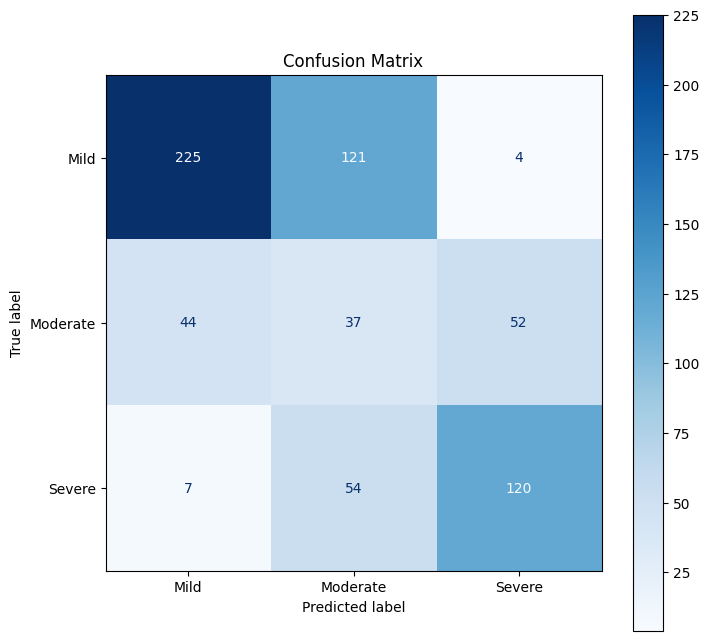

In [8]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import mark_boundaries, find_boundaries
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from lime import lime_image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- 1. CONFIGURATION ---
MODEL1_PATH = '/kaggle/input/ourensemble1/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3d/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
TEST_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'
TRAIN_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
VAL_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'

# --- 2. SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

# --- 3. DATAFRAME CREATION AND MERGE ---
print("\n--- Creating DataFrames ---")
try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_label_map = {1: 0, 2: 1, 3: 2}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)
    metadata_df.dropna(subset=['class_name'], inplace=True)
    print("Metadata loaded and processed successfully.")
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory): return pd.DataFrame(data)
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir = os.path.join(folder_path, 'images')
                if os.path.exists(images_dir):
                    for image_file in os.listdir(images_dir):
                        mask_path = os.path.join(folder_path, 'masks', image_file)
                        if os.path.exists(mask_path):
                            image_path = os.path.join(images_dir, image_file)
                            data.append((folder_name, image_path, mask_path))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    # --- [DEBUGGING TEST BLOCK] ---
    # আমরা এখানে train এবং validation ডেটা লোড করার চেষ্টা করব, ঠিক test ডেটার পরেই।
    print("\n--- [DEBUGGING TEST] ---")
    print("Attempting to create train_df and val_df immediately to check for issues...")
    debug_train_df = create_dataframe_from_ids(TRAIN_DIR, valid_ids)
    debug_val_df = create_dataframe_from_ids(VAL_DIR, valid_ids)
    debug_test_df = create_dataframe_from_ids(TEST_DIR, valid_ids)

    print(f"DEBUG: Found {len(debug_train_df)} training samples.")
    print(f"DEBUG: Found {len(debug_val_df)} validation samples.")
    print(f"DEBUG: Found {len(debug_test_df)} test samples.")

    if debug_train_df.empty or debug_val_df.empty or debug_test_df.empty:
        print("\n❌ DEBUG TEST FAILED: At least one dataframe is empty.")
        print("This confirms the issue is with either the paths or the ID matching.")
        print("Please re-verify the TRAIN_DIR, VAL_DIR, and TEST_DIR paths at the top of the script.")
        raise ValueError("Data loading failed, halting execution.")
    else:
        print("✅ DEBUG TEST PASSED: All dataframes were created successfully here.")
    print("--- [END DEBUGGING TEST] ---\n")
    
    # Now, we create the final dataframes for the script
    train_df = pd.merge(debug_train_df, metadata_df, on='ID')
    val_df = pd.merge(debug_val_df, metadata_df, on='ID')
    test_df = pd.merge(debug_test_df, metadata_df, on='ID')

    print(f"Successfully created and merged dataframes: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test.")

except Exception as e:
    print(f"Error during data setup: {e}")
    test_df = None

# --- 4. DATASET AND TRANSFORMS (باقی কোড অপরিবর্তিত) ---
class SegmentationTransform:
    # ... (আপনার কোড এখানে অপরিবর্তিত থাকবে)
    def __init__(self, image_size=(224, 224)):
        self.image_size = image_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __call__(self, image, mask):
        image = image.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)
        image_tensor = transforms.ToTensor()(image)
        mask_tensor = transforms.ToTensor()(mask)
        return self.normalize(image_tensor), (mask_tensor > 0).float()


class LiverDataset(Dataset):
    # ... (আপনার কোড এখানে অপরিবর্তিত থাকবে)
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        mask_pil = Image.open(row['mask_file_path']).convert('L')
        image, mask = self.transform(image_pil, mask_pil)
        # For classification, we'll need the label, so we modify this dataset slightly
        label = torch.tensor(row['class_label'], dtype=torch.long)
        return image, mask, label, row['image_file_path']


# --- 5. MODEL ARCHITECTURE DEFINITIONS (অপরিবর্তিত) ---
# ConvBlock, DecoderBlock, UNetWithResNet50Encoder, TransUNetPP, AttentionUNet
# ... (আপনার সব মডেলের কোড এখানে অপরিবর্তিত থাকবে)
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        self.decoder3 = DecoderBlock(2048, 1024, 512)
        self.decoder2 = DecoderBlock(512, 512, 256)
        self.decoder1 = DecoderBlock(256, 256, 128)
        self.decoder0 = DecoderBlock(128, 64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.decoder3(e4,e3); d2=self.decoder2(d3,e2); d1=self.decoder1(d2,e1); d0=self.decoder0(d1,e0)
        out = F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True)
        return self.final_conv(out)

class TransUNetPP(nn.Module):
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()
        base_model = models.resnet50(weights=None)
        base_layers = list(base_model.children())
        self.encoder0, self.encoder1 = nn.Sequential(*base_layers[:3]), nn.Sequential(*base_layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = base_layers[5], base_layers[6], base_layers[7]
        num_patches, self.patch_dim = (img_dim // 32) ** 2, 2048
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim))
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.X_0_0=ConvBlock(64,d_ch['d0']); self.X_1_0=ConvBlock(256,d_ch['d1']); self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0'])
        self.X_2_0=ConvBlock(512,d_ch['d2']); self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']); self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0'])
        self.X_3_0=ConvBlock(1024,d_ch['d3']); self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']); self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']); self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0'])
        self.X_4_0=ConvBlock(2048,d_ch['d4']); self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']); self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']); self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']); self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0'])
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        bs,_,h,w = e4.shape
        trans_in = self.patch_to_embedding(e4.flatten(2).transpose(1, 2)) + self.pos_embedding
        trans_out = self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1, 2).view(bs, self.patch_dim, h, w)
        x0_0=self.X_0_0(e0); x1_0=self.X_1_0(e1); x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1))
        x2_0=self.X_2_0(e2); x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1)); x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1))
        x3_0=self.X_3_0(e3); x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1)); x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1)); x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1))
        x4_0=self.X_4_0(trans_out); x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1)); x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1)); x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1)); x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1))
        return F.interpolate(self.final_conv(x0_4), scale_factor=2, mode='bilinear', align_corners=True)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        psi = self.relu(self.W_g(g) + self.W_x(x))
        return x * self.psi(psi)

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base = models.resnet50(weights=None)
        layers = list(base.children())
        self.encoder0, self.encoder1 = nn.Sequential(*layers[:3]), nn.Sequential(*layers[3:5])
        self.encoder2, self.encoder3, self.encoder4 = layers[5], layers[6], layers[7]
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.attn3 = AttentionGate(1024, 1024, 512)
        self.dec_conv3 = ConvBlock(2048, 1024)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.attn2 = AttentionGate(512, 512, 256)
        self.dec_conv2 = ConvBlock(1024, 512)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.attn1 = AttentionGate(256, 256, 128)
        self.dec_conv1 = ConvBlock(512, 256)
        self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.attn0 = AttentionGate(64, 64, 32)
        self.dec_conv0 = ConvBlock(128, 64)
        self.final_up = nn.ConvTranspose2d(64, 32, 2, 2)
        self.final_conv = nn.Conv2d(32, n_classes, 1)
    def forward(self, x):
        e0=self.encoder0(x); e1=self.encoder1(e0); e2=self.encoder2(e1); e3=self.encoder3(e2); e4=self.encoder4(e3)
        d3=self.upconv3(e4); x3=self.attn3(d3,e3); d3=self.dec_conv3(torch.cat((x3,d3),1))
        d2=self.upconv2(d3); x2=self.attn2(d2,e2); d2=self.dec_conv2(torch.cat((x2,d2),1))
        d1=self.upconv1(d2); x1=self.attn1(d1,e1); d1=self.dec_conv1(torch.cat((x1,d1),1))
        d0=self.upconv0(d1); x0=self.attn0(d0,e0); d0=self.dec_conv0(torch.cat((x0,d0),1))
        return self.final_conv(self.final_up(d0))


# --- 6. LOADING MODELS (অপরিবর্তিত) ---
# ... (আপনার কোড এখানে অপরিবর্তিত থাকবে)
models_loaded = False
if test_df is not None:
    try:
        print("\nLoading all three models from specified paths...")
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device)
        model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device))
        model1.eval()

        model2 = TransUNetPP(n_classes=1).to(device)
        model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
        model2.eval()

        model3 = AttentionUNet(n_classes=1).to(device)
        model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
        model3.eval()

        print("All models loaded successfully! ✅")
        models_loaded = True
    except Exception as e:
        print(f"Error loading files: {e}")


# --- 7. PREDICTION & EVALUATION (অপরিবর্তিত) ---
# ... (আপনার কোড এখানে অপরিবর্তিত থাকবে)
if models_loaded:
    test_transform = SegmentationTransform()
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    all_preds1, all_preds2, all_preds3, all_gt_masks = [], [], [], []
    print("\nGenerating predictions and collecting ground truths...")
    with torch.no_grad():
        for images, masks, _, _ in tqdm(test_loader, desc="Segmentation Prediction"):
            images = images.to(device)
            all_preds1.append(model1(images).cpu())
            all_preds2.append(model2(images).cpu())
            all_preds3.append(model3(images).cpu())
            all_gt_masks.append(masks.cpu())

    preds1 = torch.cat(all_preds1)
    preds2 = torch.cat(all_preds2)
    preds3 = torch.cat(all_preds3)
    ground_truth_masks = torch.cat(all_gt_masks)

    print("\nEnsembling predictions...")
    ensembled_preds = torch.mean(torch.stack([preds1, preds2, preds3]), dim=0)

    print("\n--- Final Ensembled Performance ---")
    ensembled_dice, ensembled_iou = calculate_metrics(ensembled_preds, ground_truth_masks)
    print(f"Ensembled Dice Score: {ensembled_dice:.4f}")
    print(f"Ensembled mIoU Score:  {ensembled_iou:.4f}")


# =================================================================================
# --- 8. CLASSIFICATION STAGE ---
# =================================================================================

print("\n\n--- Starting Classification Stage ---")

if not models_loaded or test_df is None:
    print("Skipping classification stage due to errors in model or data loading.")
else:
    try:
        # --- 8.1 FEATURE হিসেবে SEGMENTATION PREDICTIONS তৈরি করা ---
        print("\nGenerating segmentation predictions for all datasets...")
        
        train_dataset = LiverDataset(train_df, transform=test_transform)
        val_dataset = LiverDataset(val_df, transform=test_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        def get_segmentation_predictions(loader, desc):
            all_preds = []
            with torch.no_grad():
                for images, _, _, _ in tqdm(loader, desc=desc):
                    images = images.to(device)
                    preds1 = model1(images)
                    preds2 = model2(images)
                    preds3 = model3(images)
                    ensembled = torch.sigmoid(torch.mean(torch.stack([preds1, preds2, preds3]), dim=0))
                    all_preds.append((ensembled > 0.5).float().cpu())
            return torch.cat(all_preds)

        train_pred_masks = get_segmentation_predictions(train_loader, "Generating Train Masks")
        val_pred_masks = get_segmentation_predictions(val_loader, "Generating Val Masks")
        test_pred_masks = (torch.sigmoid(ensembled_preds) > 0.5).float() # আগের সেকশন থেকে পুনরায় ব্যবহার করা

        print("Segmentation predictions generated successfully for all splits.")

        # --- 8.2 CLASSIFICATION DATASET ---
        class ClassificationDataset(Dataset):
            def __init__(self, dataframe, predicted_masks, transform):
                self.dataframe = dataframe
                self.predicted_masks = predicted_masks
                self.transform = transform
            def __len__(self): return len(self.dataframe)
            def __getitem__(self, idx):
                row = self.dataframe.iloc[idx]
                image_pil = Image.open(row['image_file_path']).convert('RGB')
                mask_pil = Image.open(row['mask_file_path']).convert('L')
                image, gt_mask = self.transform(image_pil, mask_pil)
                pred_mask = self.predicted_masks[idx]
                combined_input = torch.cat([image, gt_mask, pred_mask], dim=0)
                label = torch.tensor(row['class_label'], dtype=torch.long)
                return combined_input, label

        cls_transform = SegmentationTransform()
        train_cls_dataset = ClassificationDataset(train_df, train_pred_masks, cls_transform)
        val_cls_dataset = ClassificationDataset(val_df, val_pred_masks, cls_transform)
        test_cls_dataset = ClassificationDataset(test_df, test_pred_masks, cls_transform)

        train_cls_loader = DataLoader(train_cls_dataset, batch_size=16, shuffle=True)
        val_cls_loader = DataLoader(val_cls_dataset, batch_size=16, shuffle=False)
        test_cls_loader = DataLoader(test_cls_dataset, batch_size=16, shuffle=False)
        print("\nClassification datasets and loaders are ready.")

        # --- 8.3 CLASSIFICATION MODEL ---
        class CirrhosisClassifier(nn.Module):
            def __init__(self, n_classes=3, in_channels=5):
                super().__init__()
                self.base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
                original_conv1 = self.base_model.conv1
                self.base_model.conv1 = nn.Conv2d(in_channels, original_conv1.out_channels, 
                                                  kernel_size=original_conv1.kernel_size, stride=original_conv1.stride, 
                                                  padding=original_conv1.padding, bias=False)
                num_ftrs = self.base_model.fc.in_features
                self.base_model.fc = nn.Linear(num_ftrs, n_classes)
            def forward(self, x): return self.base_model(x)
        
        # --- 8.4 TRAINING & EVALUATION ---
        cls_model = CirrhosisClassifier(n_classes=3).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(cls_model.parameters(), lr=1e-4)
        num_epochs = 25

        print("\n--- Starting Classifier Training ---")
        best_val_accuracy = 0.0
        
        for epoch in range(num_epochs):
            cls_model.train()
            running_loss = 0.0
            for inputs, labels in tqdm(train_cls_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = cls_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            cls_model.eval()
            val_corrects = 0
            with torch.no_grad():
                for inputs, labels in val_cls_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = cls_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)
            
            val_accuracy = val_corrects.double() / len(val_cls_dataset)
            print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_cls_loader):.4f} | Val Accuracy: {val_accuracy:.4f}")
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(cls_model.state_dict(), 'best_classifier_model.pth')
                print(f"   -> ✅ New best model saved with accuracy: {best_val_accuracy:.4f}")

        print("\n--- Training Finished ---")

        # --- 8.5 FINAL EVALUATION ON TEST SET ---
        print("\n--- Evaluating on Test Set ---")
        cls_model.load_state_dict(torch.load('best_classifier_model.pth'))
        cls_model.eval()
        
        all_labels, all_preds = [], []
        with torch.no_grad():
            for inputs, labels in tqdm(test_cls_loader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cls_model(inputs)
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
        # --- 8.6 DISPLAY METRICS ---
        class_names = ['Mild', 'Moderate', 'Severe']
        print("\n--- Classification Report ---")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
        
        print("\n--- Confusion Matrix ---")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    except Exception as e:
        print(f"\nAn error occurred during the classification stage: {e}")

In [6]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import mark_boundaries, find_boundaries
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. CONFIGURATION: Provide your model and data paths here ---
MODEL1_PATH = '/kaggle/input/ourensemble1/model1/best_segmentation_model1.pth'
MODEL2_PATH = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'
MODEL3_PATH = '/kaggle/input/model3d/best_segmentation_model3.pth'
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
DATA_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D' # Main data directory

# --- 2. SETUP: Basic functions and device configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- 3. LOAD ALL DATASETS (TRAIN, VALID, TEST) ---
print("\n--- Loading and Preparing All DataFrames ---")
try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    
    # Create stable, explicit class labels
    class_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    label_map = {'Mild': 0, 'Moderate': 1, 'Severe': 2}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_map)
    metadata_df['class_label'] = metadata_df['class_name'].map(label_map)
    metadata_df.dropna(subset=['class_name', 'class_label'], inplace=True)
    metadata_df['class_label'] = metadata_df['class_label'].astype(int)
    
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory): return pd.DataFrame(data)
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir, masks_dir = os.path.join(folder_path, 'images'), os.path.join(folder_path, 'masks')
                if os.path.exists(images_dir) and os.path.exists(masks_dir):
                    for image_file in os.listdir(images_dir):
                        data.append((folder_name, os.path.join(images_dir, image_file), os.path.join(masks_dir, image_file)))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    train_df = pd.merge(create_dataframe_from_ids(os.path.join(DATA_DIR, 'train'), valid_ids), metadata_df, on='ID')
    val_df = pd.merge(create_dataframe_from_ids(os.path.join(DATA_DIR, 'valid'), valid_ids), metadata_df, on='ID')
    test_df = pd.merge(create_dataframe_from_ids(os.path.join(DATA_DIR, 'test'), valid_ids), metadata_df, on='ID')
    
    print(f"Loaded {len(train_df)} training, {len(val_df)} validation, and {len(test_df)} test samples.")

except Exception as e:
    print(f"Error during data setup: {e}")
    train_df, val_df, test_df = None, None, None

# --- STAGE 1, PART A: DEFINE SEGMENTATION MODELS ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch): super().__init__(); self.conv=nn.Sequential(nn.Conv2d(in_ch,out_ch,3,1,1,bias=False),nn.BatchNorm2d(out_ch),nn.ReLU(inplace=True),nn.Conv2d(out_ch,out_ch,3,1,1,bias=False),nn.BatchNorm2d(out_ch),nn.ReLU(inplace=True))
    def forward(self, x): return self.conv(x)
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels): super().__init__(); self.conv=ConvBlock(in_channels+skip_channels,out_channels)
    def forward(self, x, skip): x=F.interpolate(x,scale_factor=2,mode='bilinear',align_corners=True); x=torch.cat([x,skip],dim=1); return self.conv(x)
class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__(); base=models.resnet50(weights=None); layers=list(base.children()); self.encoder0,self.encoder1=nn.Sequential(*layers[:3]),nn.Sequential(*layers[3:5]); self.encoder2,self.encoder3,self.encoder4=layers[5],layers[6],layers[7]; self.decoder3=DecoderBlock(2048,1024,512); self.decoder2=DecoderBlock(512,512,256); self.decoder1=DecoderBlock(256,256,128); self.decoder0=DecoderBlock(128,64,64); self.final_conv=nn.Conv2d(64,n_classes,1)
    def forward(self, x): e0=self.encoder0(x);e1=self.encoder1(e0);e2=self.encoder2(e1);e3=self.encoder3(e2);e4=self.encoder4(e3); d3=self.decoder3(e4,e3);d2=self.decoder2(d3,e2);d1=self.decoder1(d2,e1);d0=self.decoder0(d1,e0); return self.final_conv(F.interpolate(d0,scale_factor=2,mode='bilinear',align_corners=True))
class TransUNetPP(nn.Module):
    def __init__(self,n_classes=1,img_dim=224,vit_dim=768,vit_depth=12,vit_heads=12):
        super().__init__();base=models.resnet50(weights=None);layers=list(base.children());self.encoder0,self.encoder1,self.encoder2,self.encoder3,self.encoder4=nn.Sequential(*layers[:3]),nn.Sequential(*layers[3:5]),layers[5],layers[6],layers[7];num_patches,self.patch_dim=(img_dim//32)**2,2048;self.pos_embedding=nn.Parameter(torch.randn(1,num_patches,vit_dim));self.patch_to_embedding=nn.Linear(self.patch_dim,vit_dim);transformer_layer=nn.TransformerEncoderLayer(d_model=vit_dim,nhead=vit_heads,dim_feedforward=vit_dim*4,batch_first=True);self.transformer_encoder=nn.TransformerEncoder(transformer_layer,num_layers=vit_depth);self.transformer_output_to_conv=nn.Sequential(nn.Linear(vit_dim,self.patch_dim),nn.LayerNorm(self.patch_dim));d_ch={'d0':64,'d1':128,'d2':256,'d3':512,'d4':1024};self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True);self.X_0_0=ConvBlock(64,d_ch['d0']);self.X_1_0=ConvBlock(256,d_ch['d1']);self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0']);self.X_2_0=ConvBlock(512,d_ch['d2']);self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']);self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0']);self.X_3_0=ConvBlock(1024,d_ch['d3']);self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']);self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']);self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0']);self.X_4_0=ConvBlock(2048,d_ch['d4']);self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']);self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']);self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']);self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0']);self.final_conv=nn.Conv2d(d_ch['d0'],n_classes,1)
    def forward(self,x):
        e0=self.encoder0(x);e1=self.encoder1(e0);e2=self.encoder2(e1);e3=self.encoder3(e2);e4=self.encoder4(e3);bs,_,h,w=e4.shape;trans_in=self.patch_to_embedding(e4.flatten(2).transpose(1,2))+self.pos_embedding;trans_out=self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1,2).view(bs,self.patch_dim,h,w);x0_0=self.X_0_0(e0);x1_0=self.X_1_0(e1);x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1));x2_0=self.X_2_0(e2);x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1));x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1));x3_0=self.X_3_0(e3);x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1));x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1));x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1));x4_0=self.X_4_0(trans_out);x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1));x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1));x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1));x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1));return F.interpolate(self.final_conv(x0_4),scale_factor=2,mode='bilinear',align_corners=True)
class AttentionGate(nn.Module):
    def __init__(self,F_g,F_l,F_int):super().__init__();self.W_g=nn.Sequential(nn.Conv2d(F_g,F_int,1),nn.BatchNorm2d(F_int));self.W_x=nn.Sequential(nn.Conv2d(F_l,F_int,1),nn.BatchNorm2d(F_int));self.psi=nn.Sequential(nn.Conv2d(F_int,1,1),nn.BatchNorm2d(1),nn.Sigmoid());self.relu=nn.ReLU(inplace=True)
    def forward(self,g,x):psi=self.relu(self.W_g(g)+self.W_x(x));return x*self.psi(psi)
class AttentionUNet(nn.Module):
    def __init__(self,n_classes=1):
        super().__init__();base=models.resnet50(weights=None);layers=list(base.children());self.encoder0,self.encoder1=nn.Sequential(*layers[:3]),nn.Sequential(*layers[3:5]);self.encoder2,self.encoder3,self.encoder4=layers[5],layers[6],layers[7];self.upconv3=nn.ConvTranspose2d(2048,1024,2,2);self.attn3=AttentionGate(1024,1024,512);self.dec_conv3=ConvBlock(2048,1024);self.upconv2=nn.ConvTranspose2d(1024,512,2,2);self.attn2=AttentionGate(512,512,256);self.dec_conv2=ConvBlock(1024,512);self.upconv1=nn.ConvTranspose2d(512,256,2,2);self.attn1=AttentionGate(256,256,128);self.dec_conv1=ConvBlock(512,256);self.upconv0=nn.ConvTranspose2d(256,64,2,2);self.attn0=AttentionGate(64,64,32);self.dec_conv0=ConvBlock(128,64);self.final_up=nn.ConvTranspose2d(64,32,2,2);self.final_conv=nn.Conv2d(32,n_classes,1)
    def forward(self,x):e0=self.encoder0(x);e1=self.encoder1(e0);e2=self.encoder2(e1);e3=self.encoder3(e2);e4=self.encoder4(e3);d3=self.upconv3(e4);x3=self.attn3(d3,e3);d3=self.dec_conv3(torch.cat((x3,d3),1));d2=self.upconv2(d3);x2=self.attn2(d2,e2);d2=self.dec_conv2(torch.cat((x2,d2),1));d1=self.upconv1(d2);x1=self.attn1(d1,e1);d1=self.dec_conv1(torch.cat((x1,d1),1));d0=self.upconv0(d1);x0=self.attn0(d0,e0);d0=self.dec_conv0(torch.cat((x0,d0),1));return self.final_conv(self.final_up(d0))

# --- STAGE 1, PART B: GENERATE PREDICTED MASKS ---
class SegInferenceDataset(Dataset): # A simple dataset for mask generation
    def __init__(self, dataframe, transform): self.dataframe, self.transform = dataframe, transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        # We only need to transform the image for inference
        image_tensor = self.transform.normalize(transforms.ToTensor()(image_pil.resize((224, 224), Image.BILINEAR)))
        return image_tensor

def generate_ensemble_masks(loader, m1, m2, m3):
    all_masks = []
    with torch.no_grad():
        for images in tqdm(loader, desc="Generating masks"):
            images = images.to(device)
            p1, p2, p3 = m1(images), m2(images), m3(images)
            ensembled = torch.mean(torch.stack([p1, p2, p3]), dim=0)
            all_masks.append(torch.sigmoid(ensembled).cpu())
    return torch.cat(all_masks)

if train_df is not None:
    try:
        print("\n--- Loading Segmentation Models for Mask Generation ---")
        seg_model1 = UNetWithResNet50Encoder(n_classes=1).to(device); seg_model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device)); seg_model1.eval()
        seg_model2 = TransUNetPP(n_classes=1).to(device); seg_model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device)); seg_model2.eval()
        seg_model3 = AttentionUNet(n_classes=1).to(device); seg_model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device)); seg_model3.eval()

        inf_transform = SegmentationTransform() # Re-use transform class for image normalization
        train_pred_masks = generate_ensemble_masks(DataLoader(SegInferenceDataset(train_df, inf_transform), 16), seg_model1, seg_model2, seg_model3)
        val_pred_masks = generate_ensemble_masks(DataLoader(SegInferenceDataset(val_df, inf_transform), 16), seg_model1, seg_model2, seg_model3)
        test_pred_masks = generate_ensemble_masks(DataLoader(SegInferenceDataset(test_df, inf_transform), 16), seg_model1, seg_model2, seg_model3)
        
        print(f"Generated masks: {len(train_pred_masks)} train, {len(val_pred_masks)} val, {len(test_pred_masks)} test.")
        # Free up GPU memory by deleting segmentation models
        del seg_model1, seg_model2, seg_model3
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during Stage 1 (Mask Generation): {e}")
        train_pred_masks = None
else:
    train_pred_masks = None

# --- STAGE 2, PART A: DEFINE CLASSIFICATION DATASET & MODEL ---
class ClassificationDataset(Dataset):
    def __init__(self, df, predicted_masks, transform):
        self.df, self.predicted_masks, self.transform = df, predicted_masks, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        image_tensor = self.transform.normalize(transforms.ToTensor()(image_pil.resize((224, 224), Image.BILINEAR)))
        predicted_mask = self.predicted_masks[idx] # This is already a tensor
        # Stack image and mask to create a 4-channel input
        four_channel_input = torch.cat((image_tensor, predicted_mask), dim=0)
        return four_channel_input, row['class_label']

def create_classifier(num_classes=3):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Modify the first convolutional layer for 4-channel input
    original_conv1 = model.conv1
    new_conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Copy weights for the first 3 channels (RGB)
    new_conv1.weight.data[:, :3, :, :] = original_conv1.weight.data
    # Initialize weights for the 4th channel (mask) - using the mean of RGB weights
    new_conv1.weight.data[:, 3, :, :] = original_conv1.weight.data.mean(dim=1)
    model.conv1 = new_conv1
    # Modify the final classification layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# --- STAGE 2, PART B: TRAIN THE CLASSIFICATION MODEL ---
def train_classifier_epoch(loader, model, optimizer, criterion):
    model.train()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    for inputs, labels in tqdm(loader, desc="Training Classifier"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
        total_preds += len(labels)
    return running_loss / total_preds, correct_preds.double() / total_preds

def evaluate_classifier(loader, model, criterion):
    model.eval()
    running_loss, correct_preds, total_preds = 0.0, 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating Classifier"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += len(labels)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return running_loss / total_preds, correct_preds.double() / total_preds, all_labels, all_preds

if train_pred_masks is not None:
    print("\n--- Initializing Stage 2: Classifier Training ---")
    clf_transform = SegmentationTransform() # Can reuse this for image normalization
    train_clf_dataset = ClassificationDataset(train_df, train_pred_masks, clf_transform)
    val_clf_dataset = ClassificationDataset(val_df, val_pred_masks, clf_transform)
    train_clf_loader = DataLoader(train_clf_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_clf_loader = DataLoader(val_clf_dataset, batch_size=32, shuffle=False, num_workers=2)

    classifier_model = create_classifier(num_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(classifier_model.parameters(), lr=1e-4)
    num_epochs = 15
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        train_loss, train_acc = train_classifier_epoch(train_clf_loader, classifier_model, optimizer, criterion)
        print(f"Classifier Training -> Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
        
        val_loss, val_acc, _, _ = evaluate_classifier(val_clf_loader, classifier_model, criterion)
        print(f"Classifier Validation -> Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(classifier_model.state_dict(), 'best_classifier_model.pth')
            print(f"✅ New best classifier saved with validation accuracy: {best_val_acc:.4f}")
else:
    print("\nSkipping classifier training due to errors in mask generation.")


# --- STAGE 3: FINAL EVALUATION ON TEST SET ---
print("\n\n--- Stage 3: Final Evaluation on the Test Set ---")
try:
    best_classifier = create_classifier(num_classes=3).to(device)
    best_classifier.load_state_dict(torch.load('best_classifier_model.pth', map_location=device))

    test_clf_dataset = ClassificationDataset(test_df, test_pred_masks, clf_transform)
    test_clf_loader = DataLoader(test_clf_dataset, batch_size=32, shuffle=False)
    
    _, test_acc, true_labels, pred_labels = evaluate_classifier(test_clf_loader, best_classifier, criterion)
    print(f"\nFinal Test Set Accuracy: {test_acc:.4f}")

    # Generate and print classification report
    class_names = [name for name, _ in sorted(label_map.items(), key=lambda item: item[1])]
    print("\n--- Classification Report ---")
    print(classification_report(true_labels, pred_labels, target_names=class_names))

    # Generate and print confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

except FileNotFoundError:
    print("Could not find 'best_classifier_model.pth'. Skipping final evaluation.")
except Exception as e:
    print(f"An error occurred during final evaluation: {e}")

Using device: cuda ⚙️

--- Loading and Preparing All DataFrames ---
Loaded 5364 training, 674 validation, and 664 test samples.

--- Loading Segmentation Models for Mask Generation ---
Error during Stage 1 (Mask Generation): Error(s) in loading state_dict for UNetWithResNet50Encoder:
	Missing key(s) in state_dict: "decoder3.conv.conv.0.weight", "decoder3.conv.conv.1.weight", "decoder3.conv.conv.1.bias", "decoder3.conv.conv.1.running_mean", "decoder3.conv.conv.1.running_var", "decoder3.conv.conv.3.weight", "decoder3.conv.conv.4.weight", "decoder3.conv.conv.4.bias", "decoder3.conv.conv.4.running_mean", "decoder3.conv.conv.4.running_var", "decoder2.conv.conv.0.weight", "decoder2.conv.conv.1.weight", "decoder2.conv.conv.1.bias", "decoder2.conv.conv.1.running_mean", "decoder2.conv.conv.1.running_var", "decoder2.conv.conv.3.weight", "decoder2.conv.conv.4.weight", "decoder2.conv.conv.4.bias", "decoder2.conv.conv.4.running_mean", "decoder2.conv.conv.4.running_var", "decoder1.conv.conv.0.weight

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


Could not find 'best_classifier_model.pth'. Skipping final evaluation.


Using device: cuda ⚙️

--- Creating DataFrames from provided paths ---
Metadata loaded and processed successfully.
Successfully created and merged test_df with 664 samples.
Class distribution in test set:
 class_name
Normal    350
Severe    181
Mild      133
Name: count, dtype: int64

Loading all three models from specified paths...
All models and data files loaded successfully! ✅

Generating predictions from all three models...


100%|██████████| 42/42 [00:25<00:00,  1.62it/s]



Ensembling predictions...

--- Final Ensembled Performance ---
Ensembled Dice Score: 0.9443
Ensembled mIoU Score:  0.8946

--- Individual Model Performance ---
Model 1 (UNet-ResNet50) -> Dice: 0.9476, mIoU: 0.9003
Model 2 (TransUNetPP)   -> Dice: 0.9176, mIoU: 0.8477
Model 3 (AttentionUNet) -> Dice: 0.9313, mIoU: 0.8715

--- Visualizing One Sample Per Class ---

Generating LIME explanation for Class 'Mild' (Sample 0)...


  0%|          | 0/1000 [00:00<?, ?it/s]

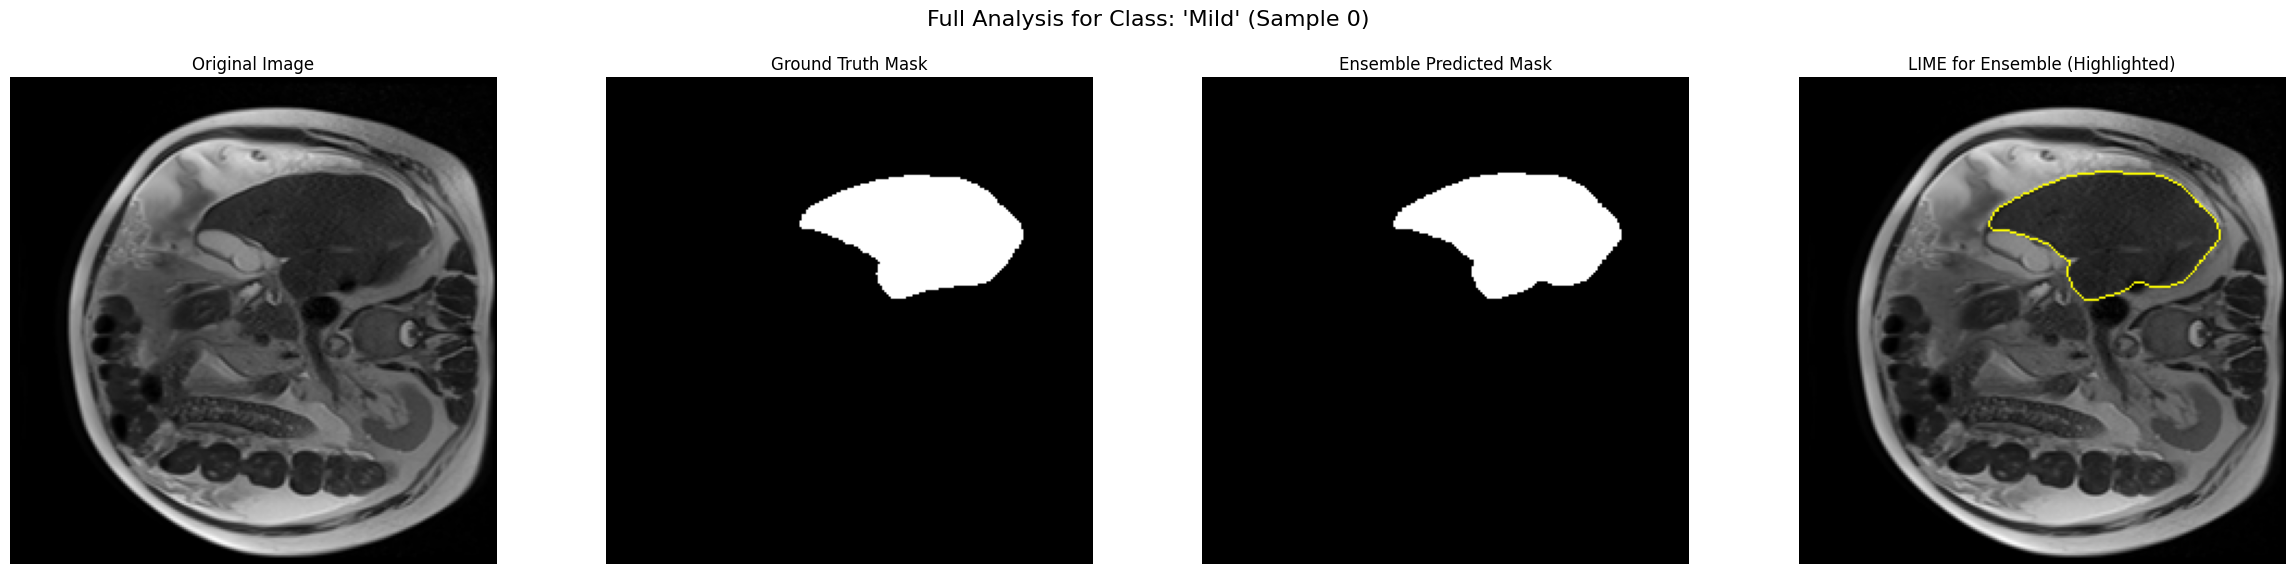


Generating LIME explanation for Class 'Normal' (Sample 50)...


  0%|          | 0/1000 [00:00<?, ?it/s]

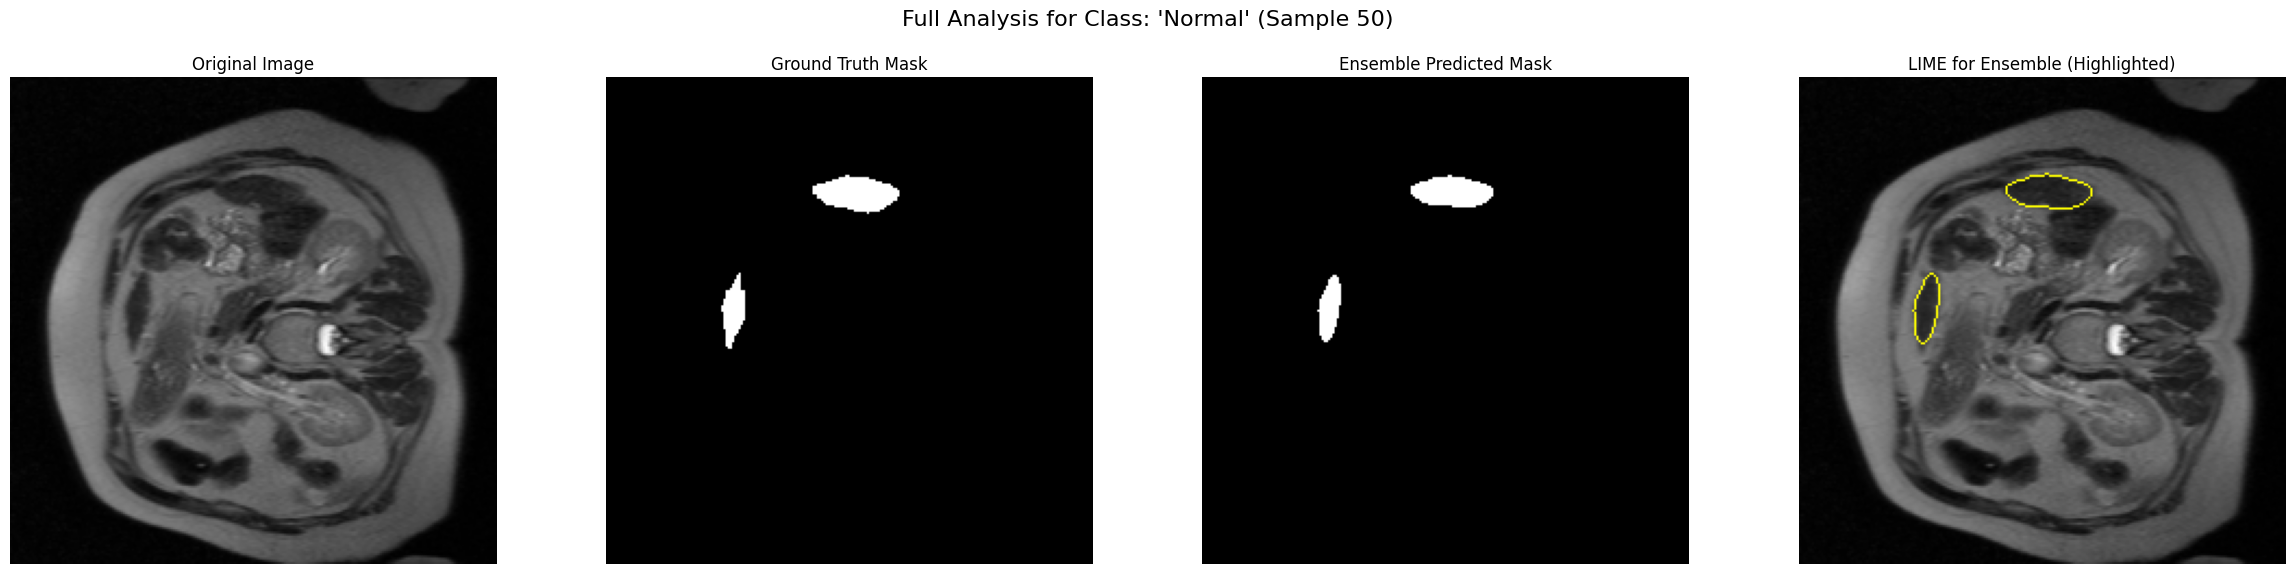


Generating LIME explanation for Class 'Severe' (Sample 104)...


  0%|          | 0/1000 [00:00<?, ?it/s]

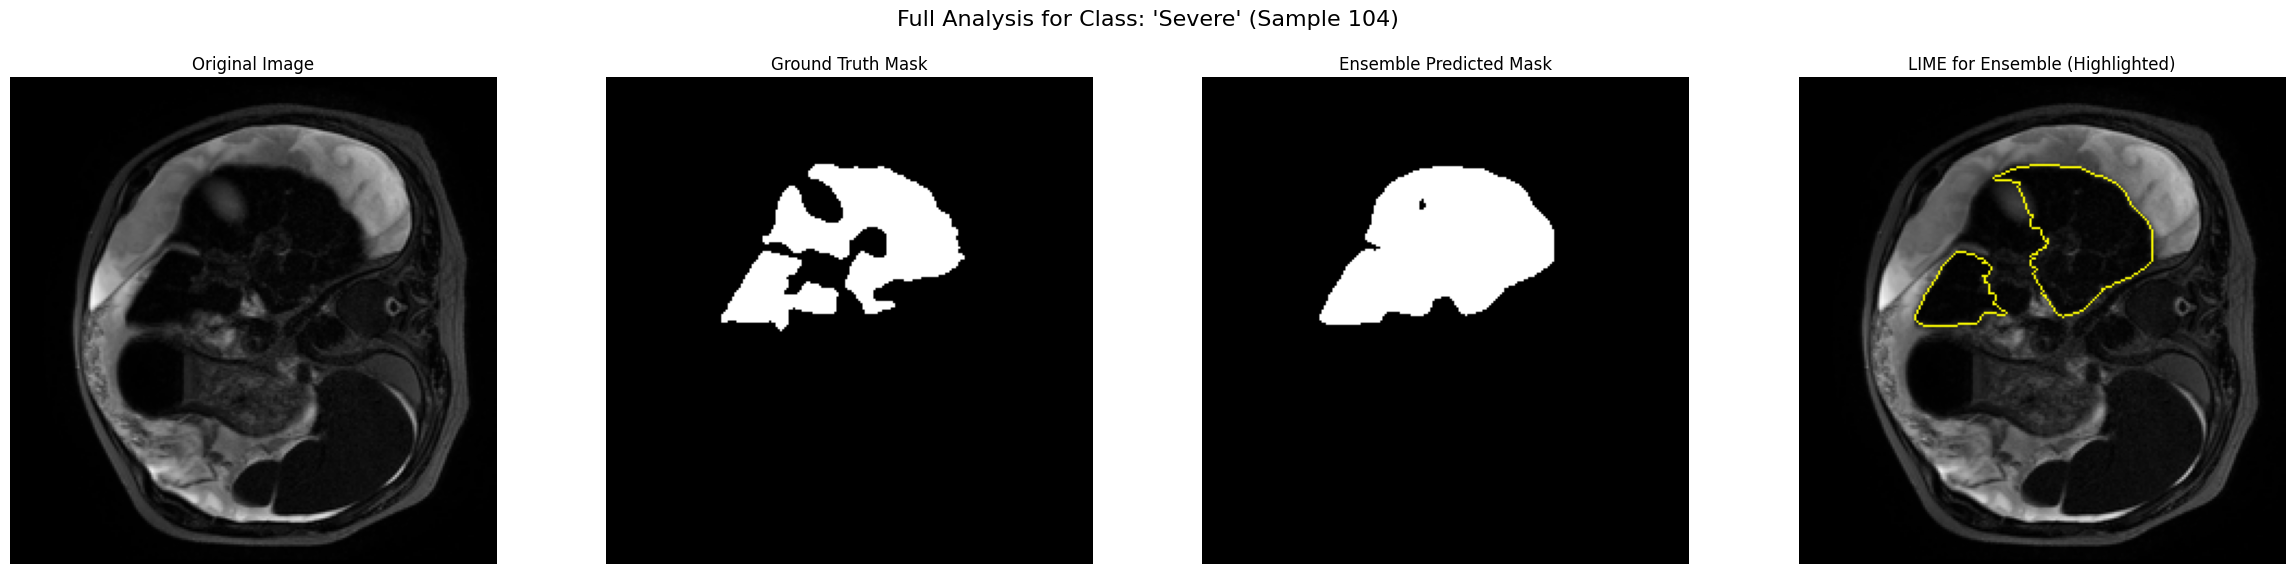

In [8]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from lime import lime_image
from tqdm import tqdm

# --- 1. SETUP: BASIC FUNCTIONS AND DEVICE CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

def calculate_metrics(preds, targets, smooth=1e-6):
    """Calculates Dice and mIoU scores from logits."""
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

# --- 2. DYNAMIC DATAFRAME CREATION AND MERGE (Using your paths) ---
print("\n--- Creating DataFrames from provided paths ---")
METADATA_PATH = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
TEST_DIR = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

try:
    metadata_df = pd.read_csv(METADATA_PATH)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    
    # Create class names and labels from the evaluation score
    class_name_map = {1: 'Normal', 2: 'Mild', 3: 'Severe'}
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df.dropna(subset=['class_name'], inplace=True) # Drop rows where mapping didn't work
    
    print("Metadata loaded and processed successfully.")
    
    valid_ids = set(metadata_df['ID'].tolist())

    def create_dataframe_from_ids(directory, allowed_ids):
        data = []
        if not os.path.exists(directory):
            print(f"Warning: Directory '{directory}' not found.")
            return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])
        for folder_name in os.listdir(directory):
            if folder_name in allowed_ids:
                folder_path = os.path.join(directory, folder_name)
                images_dir, masks_dir = os.path.join(folder_path, 'images'), os.path.join(folder_path, 'masks')
                if os.path.exists(images_dir) and os.path.exists(masks_dir):
                    for image_file in os.listdir(images_dir):
                        image_path = os.path.join(images_dir, image_file)
                        mask_path = os.path.join(masks_dir, image_file)
                        if os.path.exists(mask_path):
                            data.append((folder_name, image_path, mask_path))
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

    test_df = create_dataframe_from_ids(TEST_DIR, valid_ids)
    
    # --- NEW: Merge class information into the test_df ---
    test_df = pd.merge(test_df, metadata_df[['ID', 'class_name']], on='ID')
    
    if not test_df.empty:
        print(f"Successfully created and merged test_df with {len(test_df)} samples.")
        print("Class distribution in test set:\n", test_df['class_name'].value_counts())
    else:
        raise FileNotFoundError("Could not find any valid test images and masks.")

except Exception as e:
    print(f"Error during data setup: {e}")
    test_df = None

# --- 3. DATASET AND TRANSFORMS ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224)):
        self.image_size=image_size
        self.norm=transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    def __call__(self, image):
        image=image.resize(self.image_size,Image.BILINEAR); image=transforms.ToTensor()(image); return self.norm(image)
class LiverDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe=dataframe; self.transform=transform
    def __len__(self): return len(self.dataframe)
    def __getitem__(self, idx):
        row=self.dataframe.iloc[idx]; image=Image.open(row['image_file_path']).convert('RGB')
        if self.transform: image=self.transform(image)
        return image, row['image_file_path']

# --- 4. MODEL ARCHITECTURE DEFINITIONS ---
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__(); self.conv1=nn.Conv2d(in_channels+skip_channels,out_channels,3,padding=1,bias=False); self.bn1=nn.BatchNorm2d(out_channels); self.relu=nn.ReLU(inplace=True); self.conv2=nn.Conv2d(out_channels,out_channels,3,padding=1,bias=False); self.bn2=nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x=F.interpolate(x,scale_factor=2,mode='bilinear',align_corners=True); x=torch.cat([x,skip_connection],dim=1); x=self.relu(self.bn1(self.conv1(x))); x=self.relu(self.bn2(self.conv2(x))); return x
class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__(); base_model=models.resnet50(weights=None); base_layers=list(base_model.children()); self.encoder0=nn.Sequential(*base_layers[:3]); self.encoder1=nn.Sequential(*base_layers[3:5]); self.encoder2=base_layers[5]; self.encoder3=base_layers[6]; self.encoder4=base_layers[7]; self.decoder3=DecoderBlock(2048,1024,512); self.decoder2=DecoderBlock(512,512,256); self.decoder1=DecoderBlock(256,256,128); self.decoder0=DecoderBlock(128,64,64); self.final_conv=nn.Conv2d(64,n_classes,1)
    def forward(self,x):
        e0=self.encoder0(x);e1=self.encoder1(e0);e2=self.encoder2(e1);e3=self.encoder3(e2);e4=self.encoder4(e3); d3=self.decoder3(e4,e3);d2=self.decoder2(d3,e2);d1=self.decoder1(d2,e1);d0=self.decoder0(d1,e0); return self.final_conv(F.interpolate(d0,scale_factor=2,mode='bilinear',align_corners=True))
class ConvBlock(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__(); self.conv=nn.Sequential(nn.Conv2d(in_ch,out_ch,3,1,1,bias=False),nn.BatchNorm2d(out_ch),nn.ReLU(inplace=True),nn.Conv2d(out_ch,out_ch,3,1,1,bias=False),nn.BatchNorm2d(out_ch),nn.ReLU(inplace=True))
    def forward(self,x): return self.conv(x)
class AttentionGate(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super().__init__(); self.W_g=nn.Sequential(nn.Conv2d(F_g,F_int,1),nn.BatchNorm2d(F_int)); self.W_x=nn.Sequential(nn.Conv2d(F_l,F_int,1),nn.BatchNorm2d(F_int)); self.psi=nn.Sequential(nn.Conv2d(F_int,1,1),nn.BatchNorm2d(1),nn.Sigmoid()); self.relu=nn.ReLU(inplace=True)
    def forward(self,g,x): psi=self.relu(self.W_g(g)+self.W_x(x)); return x*self.psi(psi)
class AttentionUNet(nn.Module):
    def __init__(self,n_classes=1):
        super().__init__(); base=models.resnet50(weights=None); layers=list(base.children()); self.encoder0=nn.Sequential(*layers[:3]);self.encoder1=nn.Sequential(*layers[3:5]);self.encoder2=layers[5];self.encoder3=layers[6];self.encoder4=layers[7]; self.upconv3=nn.ConvTranspose2d(2048,1024,2,2);self.attn3=AttentionGate(1024,1024,512);self.d_conv3=ConvBlock(2048,1024); self.upconv2=nn.ConvTranspose2d(1024,512,2,2);self.attn2=AttentionGate(512,512,256);self.d_conv2=ConvBlock(1024,512); self.upconv1=nn.ConvTranspose2d(512,256,2,2);self.attn1=AttentionGate(256,256,128);self.d_conv1=ConvBlock(512,256); self.upconv0=nn.ConvTranspose2d(256,64,2,2);self.attn0=AttentionGate(64,64,32);self.d_conv0=ConvBlock(128,64); self.final_up=nn.ConvTranspose2d(64,32,2,2);self.final_conv=nn.Conv2d(32,n_classes,1)
    def forward(self,x):
        e0=self.encoder0(x);e1=self.encoder1(e0);e2=self.encoder2(e1);e3=self.encoder3(e2);e4=self.encoder4(e3); d3=self.upconv3(e4);x3=self.attn3(d3,e3);d3=self.d_conv3(torch.cat((x3,d3),1)); d2=self.upconv2(d3);x2=self.attn2(d2,e2);d2=self.d_conv2(torch.cat((x2,d2),1)); d1=self.upconv1(d2);x1=self.attn1(d1,e1);d1=self.d_conv1(torch.cat((x1,d1),1)); d0=self.upconv0(d1);x0=self.attn0(d0,e0);d0=self.d_conv0(torch.cat((x0,d0),1)); return self.final_conv(self.final_up(d0))
class TransUNetPP(nn.Module):
    def __init__(self,n_classes=1,img_dim=224,vit_dim=768,vit_depth=12,vit_heads=12):
        super().__init__();base_model=models.resnet50(weights=None);base_layers=list(base_model.children());self.encoder0,self.encoder1,self.encoder2,self.encoder3,self.encoder4=nn.Sequential(*base_layers[:3]),nn.Sequential(*base_layers[3:5]),base_layers[5],base_layers[6],base_layers[7];num_patches=(img_dim//32)**2;self.patch_dim=2048;self.pos_embedding=nn.Parameter(torch.randn(1,num_patches,vit_dim));self.patch_to_embedding=nn.Linear(self.patch_dim,vit_dim);transformer_layer=nn.TransformerEncoderLayer(d_model=vit_dim,nhead=vit_heads,dim_feedforward=vit_dim*4,batch_first=True);self.transformer_encoder=nn.TransformerEncoder(transformer_layer,num_layers=vit_depth);self.transformer_output_to_conv=nn.Sequential(nn.Linear(vit_dim,self.patch_dim),nn.LayerNorm(self.patch_dim));d_ch={'d0':64,'d1':128,'d2':256,'d3':512,'d4':1024};self.upsample=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True);self.X_0_0=ConvBlock(64,d_ch['d0']);self.X_1_0=ConvBlock(256,d_ch['d1']);self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0']);self.X_2_0=ConvBlock(512,d_ch['d2']);self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']);self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0']);self.X_3_0=ConvBlock(1024,d_ch['d3']);self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']);self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']);self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0']);self.X_4_0=ConvBlock(2048,d_ch['d4']);self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']);self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']);self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']);self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0']);self.final_conv=nn.Conv2d(d_ch['d0'],n_classes,kernel_size=1)
    def forward(self,x):
        e0=self.encoder0(x);e1=self.encoder1(e0);e2=self.encoder2(e1);e3=self.encoder3(e2);e4=self.encoder4(e3);bs,_,h,w=e4.shape;trans_in=self.patch_to_embedding(e4.flatten(2).transpose(1,2))+self.pos_embedding;trans_out=self.transformer_output_to_conv(self.transformer_encoder(trans_in)).transpose(1,2).view(bs,self.patch_dim,h,w);x0_0=self.X_0_0(e0);x1_0=self.X_1_0(e1);x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1));x2_0=self.X_2_0(e2);x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1));x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1));x3_0=self.X_3_0(e3);x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1));x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1));x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1));x4_0=self.X_4_0(trans_out);x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1));x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1));x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1));x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1));return F.interpolate(self.final_conv(x0_4),scale_factor=2,mode='bilinear',align_corners=True)

# --- 5. LOADING MODELS AND DATA ---
models_loaded = False
if test_df is not None:
    try:
        GROUND_TRUTH_MASKS_PATH = '/kaggle/input/model1/model_1/test_ground_truth_masks.pt'
        MODEL1_PATH = '/kaggle/input/model1/model_1/best_segmentation_model.pth'
        MODEL2_PATH = '/kaggle/input/model2/model_2/best_transunetpp_model.pth'
        MODEL3_PATH = '/kaggle/input/model3/model_3/best_model_attentionunet.pth'

        ground_truth_masks = torch.load(GROUND_TRUTH_MASKS_PATH, map_location=device)
        print("\nLoading all three models from specified paths...")
        model1 = UNetWithResNet50Encoder(n_classes=1).to(device); model1.load_state_dict(torch.load(MODEL1_PATH, map_location=device)); model1.eval()
        model2 = TransUNetPP(n_classes=1).to(device); model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device)); model2.eval()
        model3 = AttentionUNet(n_classes=1).to(device); model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device)); model3.eval()
        print("All models and data files loaded successfully! ✅")
        models_loaded = True
    except FileNotFoundError as e:
        print(f"Error loading files: {e}\nPlease check that all model paths are correct.")

# --- 6. ENSEMBLE PREDICTION, EVALUATION, AND LIME VISUALIZATION ---
if models_loaded:
    test_transform = SegmentationTransform()
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    all_preds1, all_preds2, all_preds3 = [], [], []
    print("\nGenerating predictions from all three models...")
    with torch.no_grad():
        for images, _ in tqdm(test_loader):
            images = images.to(device)
            all_preds1.append(model1(images).cpu()); all_preds2.append(model2(images).cpu()); all_preds3.append(model3(images).cpu())
    preds1, preds2, preds3 = torch.cat(all_preds1), torch.cat(all_preds2), torch.cat(all_preds3)

    print("\nEnsembling predictions...")
    ensembled_preds = torch.mean(torch.stack([preds1, preds2, preds3]), dim=0)
    
    gt_masks_cpu = ground_truth_masks.cpu()
    ensembled_dice, ensembled_iou = calculate_metrics(ensembled_preds, gt_masks_cpu)
    print(f"\n--- Final Ensembled Performance ---")
    print(f"Ensembled Dice Score: {ensembled_dice:.4f}")
    print(f"Ensembled mIoU Score:  {ensembled_iou:.4f}")

    print("\n--- Individual Model Performance ---")
    dice1, iou1 = calculate_metrics(preds1, gt_masks_cpu); print(f"Model 1 (UNet-ResNet50) -> Dice: {dice1:.4f}, mIoU: {iou1:.4f}")
    dice2, iou2 = calculate_metrics(preds2, gt_masks_cpu); print(f"Model 2 (TransUNetPP)   -> Dice: {dice2:.4f}, mIoU: {iou2:.4f}")
    dice3, iou3 = calculate_metrics(preds3, gt_masks_cpu); print(f"Model 3 (AttentionUNet) -> Dice: {dice3:.4f}, mIoU: {iou3:.4f}")
    
    explainer = lime_image.LimeImageExplainer()

    def batch_predict_for_ensemble_lime(images_np):
        preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
        images_torch = torch.stack([preprocess(Image.fromarray(img)) for img in images_np]).to(device).float()
        with torch.no_grad():
            logits1=model1(images_torch); logits2=model2(images_torch); logits3=model3(images_torch)
            ensembled_logits = torch.mean(torch.stack([logits1, logits2, logits3]), dim=0)
        probs = torch.sigmoid(ensembled_logits); confidence = probs.mean(dim=[1,2,3])
        return torch.stack([1 - confidence, confidence], dim=1).cpu().numpy()

    def visualize_lime_for_ensemble(image_idx):
        class_name = test_df.loc[image_idx, 'class_name']
        print(f"\nGenerating LIME explanation for Class '{class_name}' (Sample {image_idx})...")
        
        image_path = test_df.iloc[image_idx]['image_file_path']
        original_image = Image.open(image_path).convert('RGB').resize((224, 224))
        gt_mask = ground_truth_masks[image_idx].cpu().squeeze().numpy()
        pred_mask_ensembled = (torch.sigmoid(ensembled_preds[image_idx]) > 0.5).cpu().squeeze().numpy()
        
        explanation = explainer.explain_instance(np.array(original_image), batch_predict_for_ensemble_lime, top_labels=2, hide_color=0, num_samples=1000, random_seed=42)
        lime_explanation_mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=15, hide_rest=True)[1]
        final_highlight_mask = np.logical_and(pred_mask_ensembled, lime_explanation_mask)
        
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        fig.suptitle(f"Full Analysis for Class: '{class_name}' (Sample {image_idx})", fontsize=16)
        axes[0].imshow(original_image); axes[0].set_title("Original Image"); axes[0].axis('off')
        axes[1].imshow(gt_mask, cmap='gray'); axes[1].set_title("Ground Truth Mask"); axes[1].axis('off')
        axes[2].imshow(pred_mask_ensembled, cmap='gray'); axes[2].set_title("Ensemble Predicted Mask"); axes[2].axis('off')
        axes[3].imshow(mark_boundaries(np.array(original_image), final_highlight_mask, color=(1,1,0))); axes[3].set_title("LIME for Ensemble (Highlighted)"); axes[3].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # --- UPDATED: Loop through each class and visualize one sample ---
    print("\n--- Visualizing One Sample Per Class ---")
    # Using drop_duplicates to find the first index of each class
    samples_to_show_df = test_df.drop_duplicates(subset=['class_name'])
    
    for index, row in samples_to_show_df.iterrows():
        visualize_lime_for_ensemble(index)
        
else:
    print("\nSkipping model execution due to file loading or data setup errors.")

ResnetUnet

Using device: cuda ⚙️
Successfully loaded metadata CSV.

--- Classification Task Setup ---
Class Mapping for Evaluation: {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

Training samples: 5364, Validation samples: 674, Test samples: 664


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]



--- Starting Model Training ---

Epoch 1/20


Training: 100%|██████████| 336/336 [02:21<00:00,  2.38it/s]


Training -> Loss: 0.8582, Dice: 0.8365


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.34it/s]



--- Validation Report ---
Overall -> Loss: 0.7050, Dice: 0.9008, mIoU: 0.8196
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9112, mIoU: 0.8368
Class 'Moderate' (189 samples) -> Dice: 0.9141, mIoU: 0.8418
Class 'Severe' (176 samples) -> Dice: 0.8519, mIoU: 0.7421
✅ Model Saved! New Best Dice: 0.9008

Epoch 2/20


Training: 100%|██████████| 336/336 [02:25<00:00,  2.30it/s]


Training -> Loss: 0.5429, Dice: 0.9117


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.40it/s]



--- Validation Report ---
Overall -> Loss: 0.4359, Dice: 0.9280, mIoU: 0.8657
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9386, mIoU: 0.8843
Class 'Moderate' (189 samples) -> Dice: 0.9325, mIoU: 0.8735
Class 'Severe' (176 samples) -> Dice: 0.8940, mIoU: 0.8082
✅ Model Saved! New Best Dice: 0.9280

Epoch 3/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.3509, Dice: 0.9272


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.41it/s]



--- Validation Report ---
Overall -> Loss: 0.3365, Dice: 0.9166, mIoU: 0.8461
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9158, mIoU: 0.8446
Class 'Moderate' (189 samples) -> Dice: 0.9442, mIoU: 0.8943
Class 'Severe' (176 samples) -> Dice: 0.8700, mIoU: 0.7699

Epoch 4/20


Training: 100%|██████████| 336/336 [02:25<00:00,  2.30it/s]


Training -> Loss: 0.2371, Dice: 0.9359


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.45it/s]



--- Validation Report ---
Overall -> Loss: 0.1946, Dice: 0.9449, mIoU: 0.8956
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9526, mIoU: 0.9094
Class 'Moderate' (189 samples) -> Dice: 0.9488, mIoU: 0.9025
Class 'Severe' (176 samples) -> Dice: 0.9195, mIoU: 0.8510
✅ Model Saved! New Best Dice: 0.9449

Epoch 5/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.1774, Dice: 0.9395


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.39it/s]



--- Validation Report ---
Overall -> Loss: 0.1719, Dice: 0.9321, mIoU: 0.8728
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9434, mIoU: 0.8929
Class 'Moderate' (189 samples) -> Dice: 0.9317, mIoU: 0.8722
Class 'Severe' (176 samples) -> Dice: 0.9041, mIoU: 0.8250

Epoch 6/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.1398, Dice: 0.9446


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.42it/s]



--- Validation Report ---
Overall -> Loss: 0.1508, Dice: 0.9339, mIoU: 0.8760
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9330, mIoU: 0.8744
Class 'Moderate' (189 samples) -> Dice: 0.9481, mIoU: 0.9012
Class 'Severe' (176 samples) -> Dice: 0.9116, mIoU: 0.8375

Epoch 7/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.1213, Dice: 0.9456


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.44it/s]



--- Validation Report ---
Overall -> Loss: 0.1306, Dice: 0.9377, mIoU: 0.8827
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9446, mIoU: 0.8950
Class 'Moderate' (189 samples) -> Dice: 0.9440, mIoU: 0.8940
Class 'Severe' (176 samples) -> Dice: 0.9095, mIoU: 0.8340

Epoch 8/20


Training: 100%|██████████| 336/336 [02:25<00:00,  2.30it/s]


Training -> Loss: 0.1089, Dice: 0.9468


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.45it/s]



--- Validation Report ---
Overall -> Loss: 0.1203, Dice: 0.9394, mIoU: 0.8857
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9363, mIoU: 0.8802
Class 'Moderate' (189 samples) -> Dice: 0.9536, mIoU: 0.9112
Class 'Severe' (176 samples) -> Dice: 0.9225, mIoU: 0.8562

Epoch 9/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.29it/s]


Training -> Loss: 0.0952, Dice: 0.9513


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.34it/s]



--- Validation Report ---
Overall -> Loss: 0.1047, Dice: 0.9464, mIoU: 0.8982
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9535, mIoU: 0.9111
Class 'Moderate' (189 samples) -> Dice: 0.9499, mIoU: 0.9045
Class 'Severe' (176 samples) -> Dice: 0.9227, mIoU: 0.8565
✅ Model Saved! New Best Dice: 0.9464

Epoch 10/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.0892, Dice: 0.9520


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.38it/s]



--- Validation Report ---
Overall -> Loss: 0.0952, Dice: 0.9493, mIoU: 0.9036
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9566, mIoU: 0.9169
Class 'Moderate' (189 samples) -> Dice: 0.9561, mIoU: 0.9159
Class 'Severe' (176 samples) -> Dice: 0.9195, mIoU: 0.8509
✅ Model Saved! New Best Dice: 0.9493

Epoch 11/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.0887, Dice: 0.9503


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.39it/s]



--- Validation Report ---
Overall -> Loss: 0.1026, Dice: 0.9432, mIoU: 0.8924
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9454, mIoU: 0.8964
Class 'Moderate' (189 samples) -> Dice: 0.9528, mIoU: 0.9098
Class 'Severe' (176 samples) -> Dice: 0.9210, mIoU: 0.8535

Epoch 12/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.0860, Dice: 0.9509


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.41it/s]



--- Validation Report ---
Overall -> Loss: 0.0941, Dice: 0.9462, mIoU: 0.8979
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9439, mIoU: 0.8938
Class 'Moderate' (189 samples) -> Dice: 0.9554, mIoU: 0.9146
Class 'Severe' (176 samples) -> Dice: 0.9361, mIoU: 0.8798

Epoch 13/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.0805, Dice: 0.9530


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.35it/s]



--- Validation Report ---
Overall -> Loss: 0.0905, Dice: 0.9496, mIoU: 0.9040
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9570, mIoU: 0.9175
Class 'Moderate' (189 samples) -> Dice: 0.9558, mIoU: 0.9153
Class 'Severe' (176 samples) -> Dice: 0.9205, mIoU: 0.8527
✅ Model Saved! New Best Dice: 0.9496

Epoch 14/20


Training: 100%|██████████| 336/336 [02:25<00:00,  2.30it/s]


Training -> Loss: 0.0827, Dice: 0.9508


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.44it/s]



--- Validation Report ---
Overall -> Loss: 0.0972, Dice: 0.9449, mIoU: 0.8955
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9513, mIoU: 0.9071
Class 'Moderate' (189 samples) -> Dice: 0.9493, mIoU: 0.9035
Class 'Severe' (176 samples) -> Dice: 0.9210, mIoU: 0.8536

Epoch 15/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.0765, Dice: 0.9542


Training: 100%|██████████| 336/336 [02:25<00:00,  2.31it/s]00,  8.07it/s]


Training -> Loss: 0.0724, Dice: 0.9561


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.45it/s]



--- Validation Report ---
Overall -> Loss: 0.1004, Dice: 0.9424, mIoU: 0.8910
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9513, mIoU: 0.9071
Class 'Moderate' (189 samples) -> Dice: 0.9449, mIoU: 0.8955
Class 'Severe' (176 samples) -> Dice: 0.9154, mIoU: 0.8439

Epoch 17/20


Training: 100%|██████████| 336/336 [02:25<00:00,  2.30it/s]


Training -> Loss: 0.0725, Dice: 0.9556


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.42it/s]



--- Validation Report ---
Overall -> Loss: 0.0778, Dice: 0.9540, mIoU: 0.9120
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9620, mIoU: 0.9268
Class 'Moderate' (189 samples) -> Dice: 0.9522, mIoU: 0.9088
Class 'Severe' (176 samples) -> Dice: 0.9369, mIoU: 0.8813

Epoch 18/20


Training: 100%|██████████| 336/336 [02:26<00:00,  2.30it/s]


Training -> Loss: 0.0692, Dice: 0.9574


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.41it/s]



--- Validation Report ---
Overall -> Loss: 0.0783, Dice: 0.9539, mIoU: 0.9119
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9614, mIoU: 0.9257
Class 'Moderate' (189 samples) -> Dice: 0.9561, mIoU: 0.9159
Class 'Severe' (176 samples) -> Dice: 0.9315, mIoU: 0.8718

Epoch 19/20


Training: 100%|██████████| 336/336 [02:25<00:00,  2.30it/s]


Training -> Loss: 0.0704, Dice: 0.9564


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.45it/s]



--- Validation Report ---
Overall -> Loss: 0.0914, Dice: 0.9461, mIoU: 0.8977
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9544, mIoU: 0.9128
Class 'Moderate' (189 samples) -> Dice: 0.9496, mIoU: 0.9040
Class 'Severe' (176 samples) -> Dice: 0.9190, mIoU: 0.8502

Epoch 20/20


Training: 100%|██████████| 336/336 [02:25<00:00,  2.30it/s]


Training -> Loss: 0.0705, Dice: 0.9563


Evaluating on Validation: 100%|██████████| 43/43 [00:05<00:00,  7.38it/s]



--- Validation Report ---
Overall -> Loss: 0.0828, Dice: 0.9505, mIoU: 0.9057
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9556, mIoU: 0.9150
Class 'Moderate' (189 samples) -> Dice: 0.9534, mIoU: 0.9109
Class 'Severe' (176 samples) -> Dice: 0.9330, mIoU: 0.8745

--- Loading Best Model for LIME Explanation ---
Best model weights loaded successfully for LIME.

--- Generating LIME Explanations for Each Class ---

Explaining a sample for class: 'Moderate'...


  0%|          | 0/1000 [00:00<?, ?it/s]

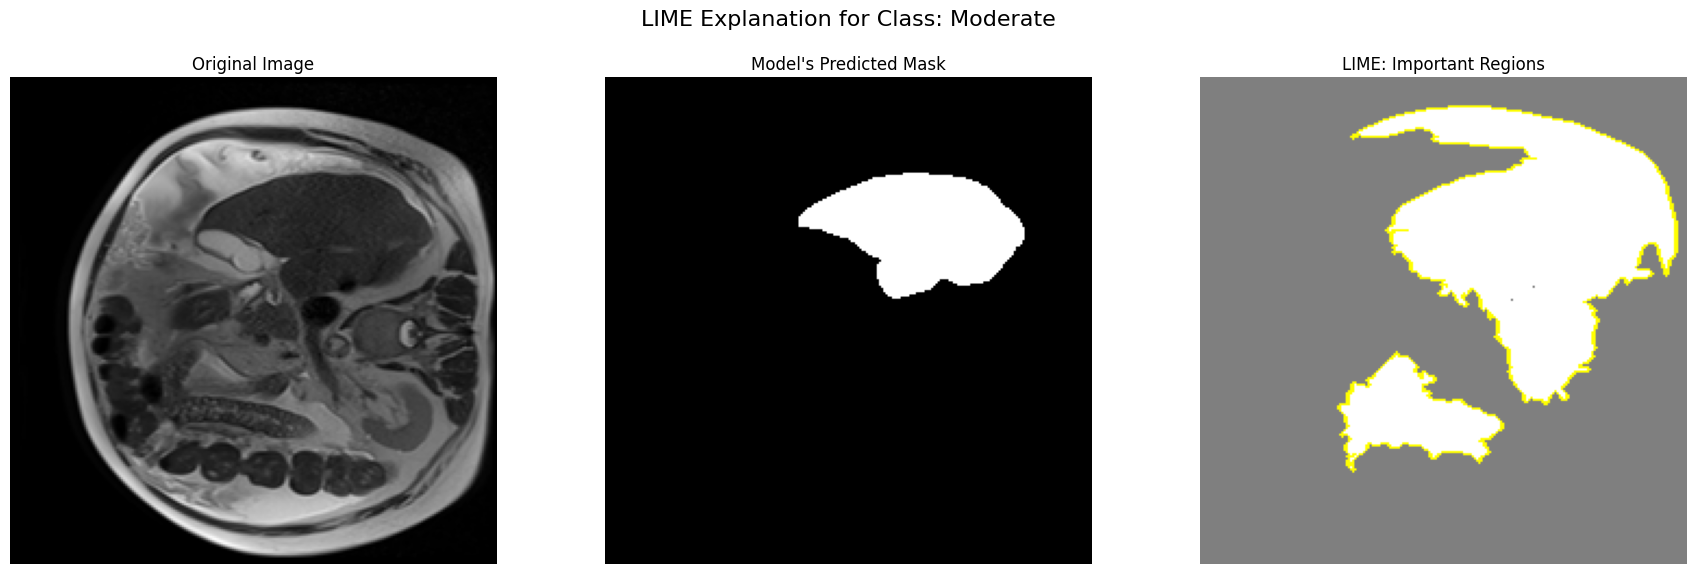


Explaining a sample for class: 'Mild'...


  0%|          | 0/1000 [00:00<?, ?it/s]

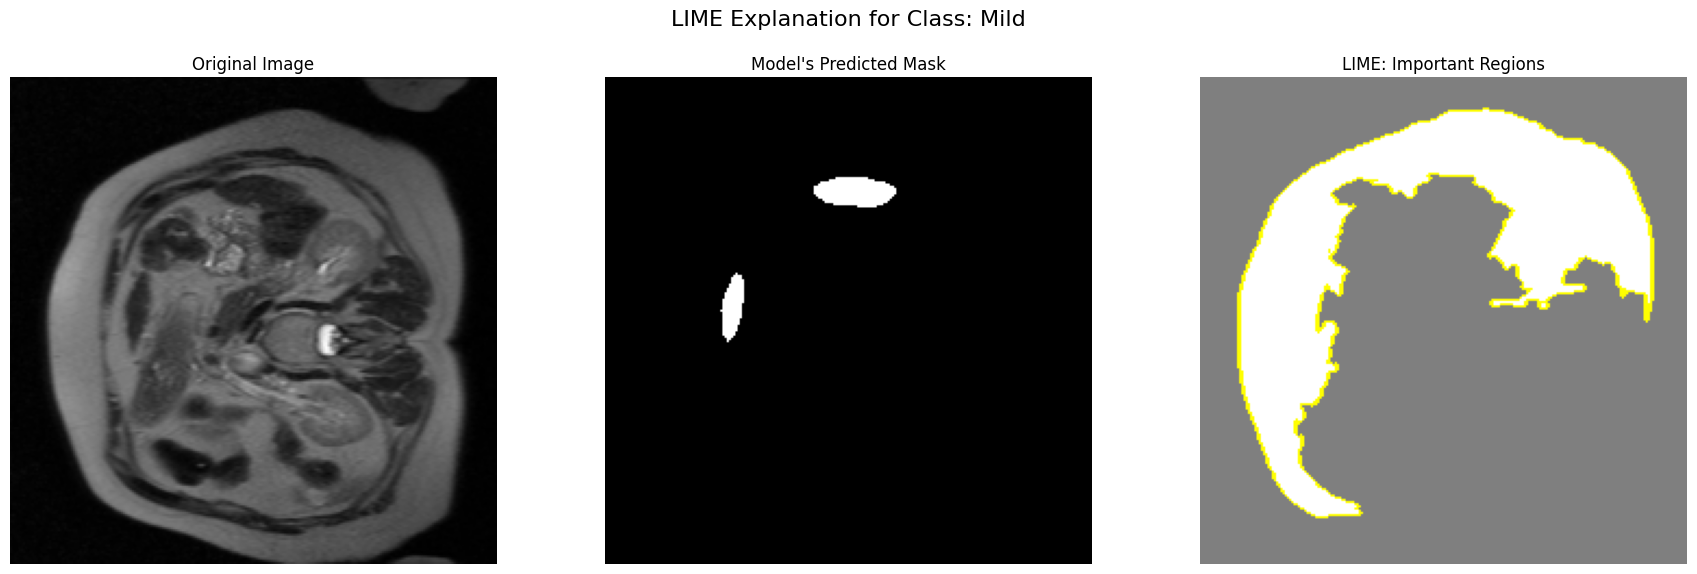


Explaining a sample for class: 'Severe'...


  0%|          | 0/1000 [00:00<?, ?it/s]

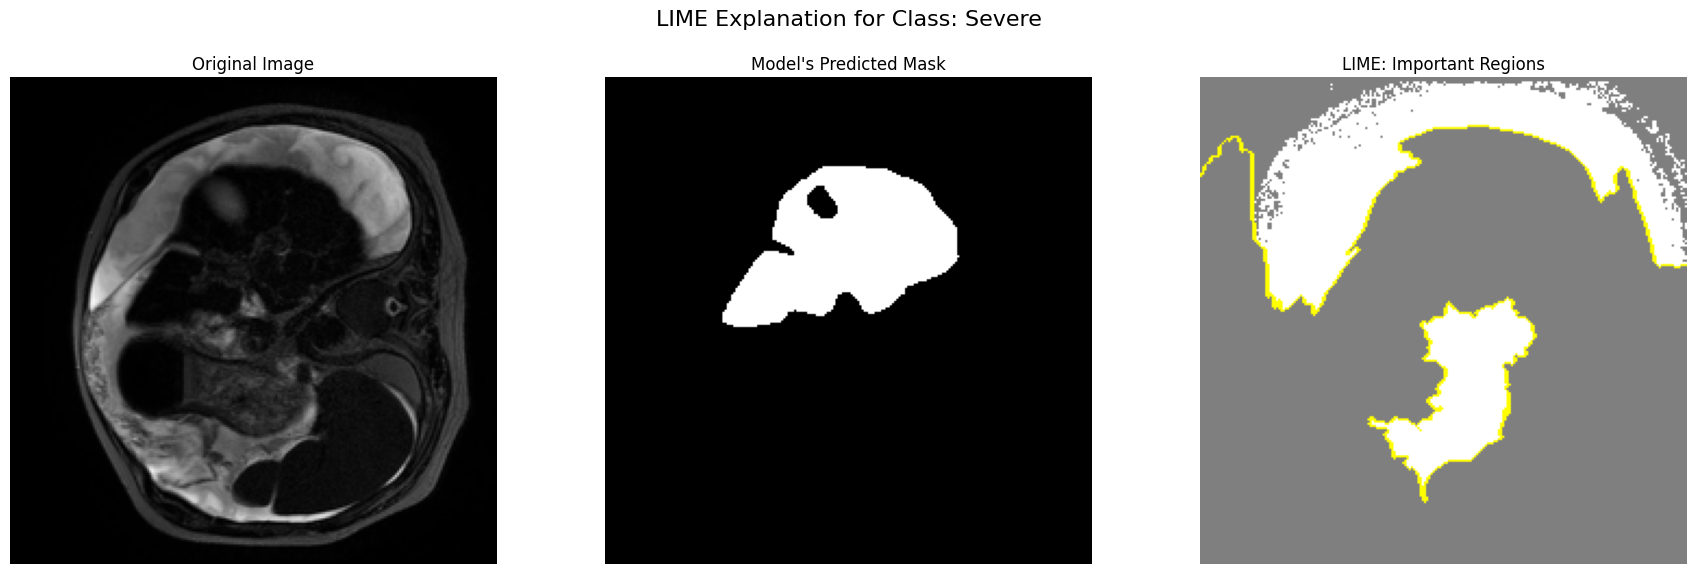

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F_T
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from PIL import Image

# --- Imports for LIME ---
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --- Set Seeds for Reproducibility ---
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set CUDA_LAUNCH_BLOCKING for easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- Data Loading and Preparation ---
try:
    metadata_df = pd.read_csv('/kaggle/input/t2metadata/T2_age_gender_evaluation.csv')
    print("Successfully loaded metadata CSV.")
except FileNotFoundError:
    print("Error: 'T2_age_gender_evaluation.csv' not found. Please ensure the file is in the correct path.")
    metadata_df = pd.DataFrame(columns=['Patient ID', 'Age', 'Gender', 'Radiological Evaluation'])

# Rename and process columns
metadata_df.rename(columns={
    'Patient ID': 'ID',
    'Radiological Evaluation': 'radiological_evaluation'
}, inplace=True)
metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)

# --- CORRECTED PART ---
# Use a pre-defined mapping to ensure the order is correct
# 1 -> Mild -> 0
# 2 -> Moderate -> 1
# 3 -> Severe -> 2
class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
class_label_map = {1: 0, 2: 1, 3: 2} # Explicitly define the mapping

metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map) # Use the explicit map
class_names = ['Mild', 'Moderate', 'Severe']
class_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'} # Ensure this is also correct

print("\n--- Classification Task Setup ---")
print("Class Mapping for Evaluation:", class_map)

metadata_df['ID'] = metadata_df['ID'].astype(str)
valid_ids = set(metadata_df['ID'].tolist())

def create_dataframe_from_ids(directory, allowed_ids):
    data = []
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' not found. Skipping.")
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])
    for folder_name in os.listdir(directory):
        if folder_name in allowed_ids:
            folder_path = os.path.join(directory, folder_name)
            images_dir = os.path.join(folder_path, 'images')
            masks_dir = os.path.join(folder_path, 'masks')
            if os.path.exists(images_dir) and os.path.exists(masks_dir):
                for image_file in os.listdir(images_dir):
                    image_path = os.path.join(images_dir, image_file)
                    mask_path = os.path.join(masks_dir, image_file)
                    if os.path.exists(mask_path):
                        data.append((folder_name, image_path, mask_path))
    return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

train_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
valid_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
test_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

train_df = pd.merge(create_dataframe_from_ids(train_dir, valid_ids), metadata_df, on='ID')
val_df = pd.merge(create_dataframe_from_ids(valid_dir, valid_ids), metadata_df, on='ID')
test_df = pd.merge(create_dataframe_from_ids(test_dir, valid_ids), metadata_df, on='ID')

print(f"\nTraining samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

# --- Dataset, Transforms, and Model ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224), is_train=True):
        self.image_size = image_size
        self.is_train = is_train
    def __call__(self, image, mask):
        image = F_T.resize(image, self.image_size, interpolation=F_T.InterpolationMode.BILINEAR)
        mask = F_T.resize(mask, self.image_size, interpolation=F_T.InterpolationMode.NEAREST)
        if self.is_train:
            if random.random() > 0.5: image, mask = F_T.hflip(image), F_T.hflip(mask)
            if random.random() > 0.5: image, mask = F_T.vflip(image), F_T.vflip(mask)
            angle = random.uniform(-15, 15)
            image, mask = F_T.rotate(image, angle), F_T.rotate(mask, angle)
        image = F_T.to_tensor(image)
        mask = F_T.to_tensor(mask)
        image = F_T.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask = (mask > 0).float()
        return image, mask

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_file_path']).convert('RGB')
        mask = Image.open(row['mask_file_path']).convert('L')
        class_label = torch.tensor(row['class_label'], dtype=torch.long)
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask, class_label

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x, skip_connection):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class UNetWithResNet50Encoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base_layers = list(base_model.children())
        self.encoder0 = nn.Sequential(*base_layers[:3])
        self.encoder1 = nn.Sequential(*base_layers[3:5])
        self.encoder2 = base_layers[5]
        self.encoder3 = base_layers[6]
        self.encoder4 = base_layers[7]
        self.decoder3 = DecoderBlock(2048, 1024, 512)
        self.decoder2 = DecoderBlock(512, 512, 256)
        self.decoder1 = DecoderBlock(256, 256, 128)
        self.decoder0 = DecoderBlock(128, 64, 64)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)
    def forward(self, x):
        e0 = self.encoder0(x); e1 = self.encoder1(e0); e2 = self.encoder2(e1)
        e3 = self.encoder3(e2); e4 = self.encoder4(e3)
        d3 = self.decoder3(e4, e3); d2 = self.decoder2(d3, e2)
        d1 = self.decoder1(d2, e1); d0 = self.decoder0(d1, e0)
        return self.final_conv(F.interpolate(d0, scale_factor=2, mode='bilinear', align_corners=True))

# --- Loss, Metrics, and Training Functions ---
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat = inputs_sig.view(-1)
        targets_flat = targets.view(-1)
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        return bce + dice_loss

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss, total_dice, total_iou = 0.0, 0.0, 0.0
    for images, masks, _ in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        dice, iou = calculate_metrics(outputs, masks)
        total_dice += dice * images.size(0)
        total_iou += iou * images.size(0)
    return (running_loss / len(loader.dataset),
            total_dice / len(loader.dataset),
            total_iou / len(loader.dataset))

def evaluate_model(loader, model, loss_fn, device, class_mapping, dataset_name="Validation"):
    model.eval()
    all_preds, all_masks, all_labels = [], [], []
    running_loss = 0.0
    with torch.no_grad():
        for images, masks, labels in tqdm(loader, desc=f"Evaluating on {dataset_name}"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            running_loss += loss_fn(outputs, masks).item() * images.size(0)
            all_preds.append(outputs.cpu()); all_masks.append(masks.cpu()); all_labels.append(labels.cpu())
    all_preds, all_masks, all_labels = torch.cat(all_preds), torch.cat(all_masks), torch.cat(all_labels)
    
    avg_loss, (overall_dice, overall_iou) = running_loss / len(loader.dataset), calculate_metrics(all_preds, all_masks)
    print(f"\n--- {dataset_name} Report ---")
    print(f"Overall -> Loss: {avg_loss:.4f}, Dice: {overall_dice:.4f}, mIoU: {overall_iou:.4f}")
    
    print("--- Per-Class Metrics ---")
    for class_idx, class_name in class_mapping.items():
        indices = (all_labels == class_idx).nonzero(as_tuple=True)[0]
        if len(indices) > 0:
            class_dice, class_iou = calculate_metrics(all_preds[indices], all_masks[indices])
            print(f"Class '{class_name}' ({len(indices)} samples) -> Dice: {class_dice:.4f}, mIoU: {class_iou:.4f}")
    return avg_loss, overall_dice

# --- FULL TRAINING LOOP ---
train_dataset = LiverDataset(train_df, transform=SegmentationTransform(is_train=True))
val_dataset = LiverDataset(val_df, transform=SegmentationTransform(is_train=False))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

model = UNetWithResNet50Encoder(n_classes=1).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = DiceBCELoss()
num_epochs = 20 # Using fewer epochs for demonstration; increase for better results
best_val_dice = 0.0

print("\n--- Starting Model Training ---")
if len(train_dataset) > 0:
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_dice, _ = train_one_epoch(train_loader, model, optimizer, criterion, device)
        print(f"Training -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        
        val_loss, val_dice = evaluate_model(val_loader, model, criterion, device, class_map)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_segmentation_model.pth')
            print(f"✅ Model Saved! New Best Dice: {best_val_dice:.4f}")
else:
    print("🛑 Training dataset is empty. Cannot start training.")

# --- LIME EXPLANATION SECTION ---
print("\n--- Loading Best Model for LIME Explanation ---")
try:
    model.load_state_dict(torch.load('best_segmentation_model.pth', map_location=device))
    print("Best model weights loaded successfully for LIME.")
except FileNotFoundError:
    print("Model file 'best_segmentation_model.pth' not found. Cannot perform LIME explanation.")
    model = None

def get_pil_transform():
    return transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_preprocess_transform():
    return transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def batch_predict(images):
    model.eval()
    batch = torch.stack([get_preprocess_transform()(image) for image in images], dim=0).to(device).float()
    with torch.no_grad():
        logits = model(batch)
    probs = torch.sigmoid(logits)
    segmentation_confidence = probs.sum(dim=[1, 2, 3])
    return torch.stack([1 - segmentation_confidence, segmentation_confidence], dim=1).cpu().numpy()

def generate_lime_explanation(dataset, model, class_mapping):
    if model is None or len(dataset) == 0:
        print("Skipping LIME: model or dataset not available.")
        return

    print("\n--- Generating LIME Explanations for Each Class ---")
    explainer = lime_image.LimeImageExplainer()
    test_df_viz = dataset.dataframe.drop_duplicates(subset=['class_label'])

    for _, row in test_df_viz.iterrows():
        class_name = row['class_name']
        image_path = row['image_file_path']
        original_image = Image.open(image_path).convert('RGB').resize((224, 224))
        
        print(f"\nExplaining a sample for class: '{class_name}'...")
        explanation = explainer.explain_instance(np.array(original_image), batch_predict, top_labels=1, hide_color=0, num_samples=1000)
        
        temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=5, hide_rest=True)
        
        img_tensor = get_pil_transform()(original_image).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mask = (torch.sigmoid(model(img_tensor)) > 0.5).float().cpu().squeeze(0).permute(1, 2, 0)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"LIME Explanation for Class: {class_name}", fontsize=16)
        axes[0].imshow(original_image); axes[0].set_title("Original Image"); axes[0].axis('off')
        axes[1].imshow(pred_mask, cmap='gray'); axes[1].set_title("Model's Predicted Mask"); axes[1].axis('off')
        axes[2].imshow(mark_boundaries(temp / 2 + 0.5, mask)); axes[2].set_title("LIME: Important Regions"); axes[2].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# Run LIME on the test dataset
test_dataset = LiverDataset(test_df, transform=None) # Use untransformed images for LIME
generate_lime_explanation(test_dataset, model, class_map)

In [8]:
# The main execution block
print("\n--- Starting Final Evaluation on Test Set ---")
if not test_df.empty:
    test_dataset = LiverDataset(test_df, transform=SegmentationTransform(is_train=False))
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
    
    model = UNetWithResNet50Encoder(n_classes=1).to(device)
    criterion = DiceBCELoss()
    try:
        model.load_state_dict(torch.load('best_segmentation_model.pth', map_location=device))
        print("Best segmentation model loaded for final evaluation. ✅")
        # This line calls the evaluation function on the test data
        evaluate_model(test_loader, model, criterion, device, class_map, dataset_name="Test") 
    except FileNotFoundError:
        print("Error: Model file 'best_segmentation_model.pth' not found. Cannot perform final evaluation. 🛑")
else:
    print("Test dataset is empty. Skipping final evaluation.")


--- Starting Final Evaluation on Test Set ---
Best segmentation model loaded for final evaluation. ✅


Evaluating on Test: 100%|██████████| 42/42 [00:06<00:00,  6.73it/s]



--- Test Report ---
Overall -> Loss: 0.0876, Dice: 0.9483, mIoU: 0.9017
--- Per-Class Metrics ---
Class 'Mild' (350 samples) -> Dice: 0.9493, mIoU: 0.9034
Class 'Moderate' (133 samples) -> Dice: 0.9478, mIoU: 0.9009
Class 'Severe' (181 samples) -> Dice: 0.9461, mIoU: 0.8978


TransUNet++

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F_T
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from PIL import Image
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# --- Set Seeds for Reproducibility ---
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- Data Loading and Preparation ---
try:
    metadata_df = pd.read_csv('/kaggle/input/t2metadata/T2_age_gender_evaluation.csv')
    print("Successfully loaded metadata CSV.")
except FileNotFoundError:
    print("Error: 'T2_age_gender_evaluation.csv' not found. Please ensure the file is in the correct path.")
    metadata_df = pd.DataFrame(columns=['Patient ID', 'Age', 'Gender', 'Radiological Evaluation'])

# Rename and process columns
metadata_df.rename(columns={
    'Patient ID': 'ID',
    'Radiological Evaluation': 'radiological_evaluation'
}, inplace=True)
metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)

# --- CORRECTED CLASS MAPPING ---
class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
class_label_map = {1: 0, 2: 1, 3: 2} # Explicitly define the mapping
metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)
class_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

print("\n--- Classification Task Setup ---")
print("Class Mapping for Evaluation:", class_map)

metadata_df['ID'] = metadata_df['ID'].astype(str)
valid_ids = set(metadata_df['ID'].tolist())

def create_dataframe_from_ids(directory, allowed_ids):
    data = []
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' not found. Skipping.")
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])
    for folder_name in os.listdir(directory):
        if folder_name in allowed_ids:
            folder_path = os.path.join(directory, folder_name)
            images_dir = os.path.join(folder_path, 'images')
            masks_dir = os.path.join(folder_path, 'masks')
            if os.path.exists(images_dir) and os.path.exists(masks_dir):
                for image_file in os.listdir(images_dir):
                    image_path = os.path.join(images_dir, image_file)
                    mask_path = os.path.join(masks_dir, image_file)
                    if os.path.exists(mask_path):
                        data.append((folder_name, image_path, mask_path))
    return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

train_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
valid_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
test_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

train_df = pd.merge(create_dataframe_from_ids(train_dir, valid_ids), metadata_df, on='ID')
val_df = pd.merge(create_dataframe_from_ids(valid_dir, valid_ids), metadata_df, on='ID')
test_df = pd.merge(create_dataframe_from_ids(test_dir, valid_ids), metadata_df, on='ID')

print(f"\nTraining samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

# --- Dataset, Transforms, and Model ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224), is_train=True):
        self.image_size = image_size
        self.is_train = is_train
    def __call__(self, image, mask):
        image = F_T.resize(image, self.image_size, interpolation=F_T.InterpolationMode.BILINEAR)
        mask = F_T.resize(mask, self.image_size, interpolation=F_T.InterpolationMode.NEAREST)
        if self.is_train:
            if random.random() > 0.5: image, mask = F_T.hflip(image), F_T.hflip(mask)
            if random.random() > 0.5: image, mask = F_T.vflip(image), F_T.vflip(mask)
            angle = random.uniform(-15, 15)
            image, mask = F_T.rotate(image, angle), F_T.rotate(mask, angle)
        image = F_T.to_tensor(image)
        mask = F_T.to_tensor(mask)
        image = F_T.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask = (mask > 0).float()
        return image, mask

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_file_path']).convert('RGB')
        mask = Image.open(row['mask_file_path']).convert('L')
        class_label = torch.tensor(row['class_label'], dtype=torch.long)
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask, class_label

class ConvBlock(nn.Module):
    """
    Standard convolutional block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class TransUNetPP(nn.Module):
    """
    TransUNet++ Architecture
    Combines a ResNet50 CNN backbone, a Transformer Encoder bottleneck, and a U-Net++ style decoder.
    """
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()

        # --- CNN Encoder (ResNet50 Backbone) ---
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base_layers = list(base_model.children())
        self.encoder0 = nn.Sequential(*base_layers[:3])
        self.encoder1 = nn.Sequential(*base_layers[3:5])
        self.encoder2 = base_layers[5]
        self.encoder3 = base_layers[6]
        self.encoder4 = base_layers[7]

        # --- Transformer Encoder (Bottleneck) ---
        num_patches = (img_dim // 32) ** 2
        self.patch_dim = 2048 # Output channels from encoder4
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(
            nn.Linear(vit_dim, self.patch_dim),
            nn.LayerNorm(self.patch_dim)
        )

        # --- U-Net++ Decoder ---
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.X_0_0 = ConvBlock(64, d_ch['d0'])
        self.X_1_0 = ConvBlock(256, d_ch['d1'])
        self.X_0_1 = ConvBlock(d_ch['d0'] + d_ch['d1'], d_ch['d0'])
        self.X_2_0 = ConvBlock(512, d_ch['d2'])
        self.X_1_1 = ConvBlock(d_ch['d1'] + d_ch['d2'], d_ch['d1'])
        self.X_0_2 = ConvBlock(d_ch['d0']*2 + d_ch['d1'], d_ch['d0'])
        self.X_3_0 = ConvBlock(1024, d_ch['d3'])
        self.X_2_1 = ConvBlock(d_ch['d2'] + d_ch['d3'], d_ch['d2'])
        self.X_1_2 = ConvBlock(d_ch['d1']*2 + d_ch['d2'], d_ch['d1'])
        self.X_0_3 = ConvBlock(d_ch['d0']*3 + d_ch['d1'], d_ch['d0'])
        self.X_4_0 = ConvBlock(2048, d_ch['d4'])
        self.X_3_1 = ConvBlock(d_ch['d3'] + d_ch['d4'], d_ch['d3'])
        self.X_2_2 = ConvBlock(d_ch['d2']*2 + d_ch['d3'], d_ch['d2'])
        self.X_1_3 = ConvBlock(d_ch['d1']*3 + d_ch['d2'], d_ch['d1'])
        self.X_0_4 = ConvBlock(d_ch['d0']*4 + d_ch['d1'], d_ch['d0'])
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)

    def forward(self, x):
        e0_out = self.encoder0(x); e1_out = self.encoder1(e0_out); e2_out = self.encoder2(e1_out)
        e3_out = self.encoder3(e2_out); e4_out = self.encoder4(e3_out)
        bs, _, h, w = e4_out.shape
        transformer_input = self.patch_to_embedding(e4_out.flatten(2).transpose(1, 2))
        transformer_input = transformer_input + self.pos_embedding
        transformer_output = self.transformer_encoder(transformer_input)
        transformer_output = self.transformer_output_to_conv(transformer_output).transpose(1, 2).view(bs, self.patch_dim, h, w)
        x0_0 = self.X_0_0(e0_out); x1_0 = self.X_1_0(e1_out); x0_1 = self.X_0_1(torch.cat([x0_0, self.upsample(x1_0)], 1))
        x2_0 = self.X_2_0(e2_out); x1_1 = self.X_1_1(torch.cat([x1_0, self.upsample(x2_0)], 1)); x0_2 = self.X_0_2(torch.cat([x0_0, x0_1, self.upsample(x1_1)], 1))
        x3_0 = self.X_3_0(e3_out); x2_1 = self.X_2_1(torch.cat([x2_0, self.upsample(x3_0)], 1)); x1_2 = self.X_1_2(torch.cat([x1_0, x1_1, self.upsample(x2_1)], 1)); x0_3 = self.X_0_3(torch.cat([x0_0, x0_1, x0_2, self.upsample(x1_2)], 1))
        x4_0 = self.X_4_0(transformer_output); x3_1 = self.X_3_1(torch.cat([x3_0, self.upsample(x4_0)], 1)); x2_2 = self.X_2_2(torch.cat([x2_0, x2_1, self.upsample(x3_1)], 1)); x1_3 = self.X_1_3(torch.cat([x1_0, x1_1, x1_2, self.upsample(x2_2)], 1)); x0_4 = self.X_0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.upsample(x1_3)], 1))
        output = self.final_conv(x0_4)
        output = F.interpolate(output, scale_factor=2, mode='bilinear', align_corners=True)
        return output

# --- Loss, Metrics, and Training Functions (No change needed) ---
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat = inputs_sig.view(-1)
        targets_flat = targets.view(-1)
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        return bce + dice_loss

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss, total_dice, total_iou = 0.0, 0.0, 0.0
    for images, masks, _ in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        dice, iou = calculate_metrics(outputs, masks)
        total_dice += dice * images.size(0)
        total_iou += iou * images.size(0)
    return (running_loss / len(loader.dataset), total_dice / len(loader.dataset), total_iou / len(loader.dataset))

def evaluate_model(loader, model, loss_fn, device, class_mapping, dataset_name="Validation"):
    model.eval()
    all_preds, all_masks, all_labels = [], [], []
    running_loss = 0.0
    with torch.no_grad():
        for images, masks, labels in tqdm(loader, desc=f"Evaluating on {dataset_name}"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            running_loss += loss_fn(outputs, masks).item() * images.size(0)
            all_preds.append(outputs.cpu()); all_masks.append(masks.cpu()); all_labels.append(labels.cpu())
    all_preds, all_masks, all_labels = torch.cat(all_preds), torch.cat(all_masks), torch.cat(all_labels)
    avg_loss, (overall_dice, overall_iou) = running_loss / len(loader.dataset), calculate_metrics(all_preds, all_masks)
    print(f"\n--- {dataset_name} Report ---")
    print(f"Overall -> Loss: {avg_loss:.4f}, Dice: {overall_dice:.4f}, mIoU: {overall_iou:.4f}")
    print("--- Per-Class Metrics ---")
    for class_idx, class_name in class_mapping.items():
        indices = (all_labels == class_idx).nonzero(as_tuple=True)[0]
        if len(indices) > 0:
            class_dice, class_iou = calculate_metrics(all_preds[indices], all_masks[indices])
            print(f"Class '{class_name}' ({len(indices)} samples) -> Dice: {class_dice:.4f}, mIoU: {class_iou:.4f}")
    return avg_loss, overall_dice

# --- FULL TRAINING LOOP ---
train_dataset = LiverDataset(train_df, transform=SegmentationTransform(is_train=True))
val_dataset = LiverDataset(val_df, transform=SegmentationTransform(is_train=False))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

model = TransUNetPP(n_classes=1).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = DiceBCELoss()
num_epochs = 20
best_val_dice = 0.0

print("\n--- Starting Model Training with TransUNet++ ---")
if len(train_dataset) > 0:
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_dice, _ = train_one_epoch(train_loader, model, optimizer, criterion, device)
        print(f"Training -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        val_loss, val_dice = evaluate_model(val_loader, model, criterion, device, class_map)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_transunetpp_model.pth')
            print(f"✅ Model Saved! New Best Dice: {best_val_dice:.4f}")
else:
    print("🛑 Training dataset is empty. Cannot start training.")

# --- LIME EXPLANATION SECTION ---
print("\n--- Loading Best Model for LIME Explanation ---")
try:
    model.load_state_dict(torch.load('best_transunetpp_model.pth', map_location=device))
    print("Best model weights loaded successfully for LIME.")
except FileNotFoundError:
    print("Model file 'best_transunetpp_model.pth' not found. Cannot perform LIME explanation.")
    model = None

def get_pil_transform():
    return transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_preprocess_transform():
    return transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def batch_predict(images):
    model.eval()
    batch = torch.stack([get_preprocess_transform()(image) for image in images], dim=0).to(device).float()
    with torch.no_grad():
        logits = model(batch)
    probs = torch.sigmoid(logits)
    segmentation_confidence = probs.sum(dim=[1, 2, 3])
    return torch.stack([1 - segmentation_confidence, segmentation_confidence], dim=1).cpu().numpy()

def generate_lime_explanation(dataset, model, class_mapping):
    if model is None or len(dataset) == 0:
        print("Skipping LIME: model or dataset not available.")
        return
    print("\n--- Generating LIME Explanations for Each Class ---")
    explainer = lime_image.LimeImageExplainer()
    test_df_viz = dataset.dataframe.drop_duplicates(subset=['class_label'])
    for _, row in test_df_viz.iterrows():
        class_name = row['class_name']
        image_path = row['image_file_path']
        original_image = Image.open(image_path).convert('RGB').resize((224, 224))
        print(f"\nExplaining a sample for class: '{class_name}'...")
        explanation = explainer.explain_instance(np.array(original_image), batch_predict, top_labels=1, hide_color=0, num_samples=1000)
        temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=5, hide_rest=True)
        img_tensor = get_pil_transform()(original_image).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mask = (torch.sigmoid(model(img_tensor)) > 0.5).float().cpu().squeeze(0).permute(1, 2, 0)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"LIME Explanation for Class: {class_name}", fontsize=16)
        axes[0].imshow(original_image); axes[0].set_title("Original Image"); axes[0].axis('off')
        axes[1].imshow(pred_mask, cmap='gray'); axes[1].set_title("Model's Predicted Mask"); axes[1].axis('off')
        axes[2].imshow(mark_boundaries(temp / 2 + 0.5, mask)); axes[2].set_title("LIME: Important Regions"); axes[2].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Final Evaluation on Test Set ---
print("\n--- Starting Final Evaluation on Test Set ---")
if not test_df.empty:
    test_dataset = LiverDataset(test_df, transform=SegmentationTransform(is_train=False))
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
    model_eval = TransUNetPP(n_classes=1).to(device)
    criterion = DiceBCELoss()
    try:
        model_eval.load_state_dict(torch.load('best_transunetpp_model.pth', map_location=device))
        print("Best TransUNet++ model loaded for final evaluation. ✅")
        evaluate_model(test_loader, model_eval, criterion, device, class_map, dataset_name="Test")
    except FileNotFoundError:
        print("Error: Model file 'best_transunetpp_model.pth' not found. Cannot perform final evaluation. 🛑")
else:
    print("Test dataset is empty. Skipping final evaluation.")

Using device: cuda ⚙️
Successfully loaded metadata CSV.

--- Classification Task Setup ---
Class Mapping for Evaluation: {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

Training samples: 5364, Validation samples: 674, Test samples: 664

--- Starting Model Training with TransUNet++ ---

Epoch 1/20


Training: 100%|██████████| 336/336 [05:41<00:00,  1.02s/it]


Training -> Loss: 0.8876, Dice: 0.8409


Evaluating on Validation: 100%|██████████| 43/43 [00:13<00:00,  3.29it/s]



--- Validation Report ---
Overall -> Loss: 0.7184, Dice: 0.8817, mIoU: 0.7884
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.8895, mIoU: 0.8009
Class 'Moderate' (189 samples) -> Dice: 0.8953, mIoU: 0.8104
Class 'Severe' (176 samples) -> Dice: 0.8382, mIoU: 0.7215
✅ Model Saved! New Best Dice: 0.8817

Epoch 2/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.5836, Dice: 0.9123


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.4960, Dice: 0.9215, mIoU: 0.8544
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9358, mIoU: 0.8794
Class 'Moderate' (189 samples) -> Dice: 0.9334, mIoU: 0.8752
Class 'Severe' (176 samples) -> Dice: 0.8656, mIoU: 0.7631
✅ Model Saved! New Best Dice: 0.9215

Epoch 3/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.3837, Dice: 0.9275


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.3609, Dice: 0.9098, mIoU: 0.8346
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9031, mIoU: 0.8233
Class 'Moderate' (189 samples) -> Dice: 0.9389, mIoU: 0.8848
Class 'Severe' (176 samples) -> Dice: 0.8749, mIoU: 0.7776

Epoch 4/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.2620, Dice: 0.9340


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]



--- Validation Report ---
Overall -> Loss: 0.2349, Dice: 0.9273, mIoU: 0.8644
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9478, mIoU: 0.9008
Class 'Moderate' (189 samples) -> Dice: 0.9237, mIoU: 0.8583
Class 'Severe' (176 samples) -> Dice: 0.8804, mIoU: 0.7863
✅ Model Saved! New Best Dice: 0.9273

Epoch 5/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.1877, Dice: 0.9415


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.2008, Dice: 0.9243, mIoU: 0.8592
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9398, mIoU: 0.8865
Class 'Moderate' (189 samples) -> Dice: 0.9303, mIoU: 0.8697
Class 'Severe' (176 samples) -> Dice: 0.8734, mIoU: 0.7752

Epoch 6/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.1505, Dice: 0.9433


Evaluating on Validation: 100%|██████████| 43/43 [00:13<00:00,  3.29it/s]



--- Validation Report ---
Overall -> Loss: 0.1520, Dice: 0.9381, mIoU: 0.8834
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9422, mIoU: 0.8906
Class 'Moderate' (189 samples) -> Dice: 0.9486, mIoU: 0.9022
Class 'Severe' (176 samples) -> Dice: 0.9098, mIoU: 0.8345
✅ Model Saved! New Best Dice: 0.9381

Epoch 7/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.1294, Dice: 0.9441


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.34it/s]



--- Validation Report ---
Overall -> Loss: 0.1325, Dice: 0.9397, mIoU: 0.8862
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9465, mIoU: 0.8984
Class 'Moderate' (189 samples) -> Dice: 0.9436, mIoU: 0.8932
Class 'Severe' (176 samples) -> Dice: 0.9157, mIoU: 0.8445
✅ Model Saved! New Best Dice: 0.9397

Epoch 8/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.1126, Dice: 0.9471


Evaluating on Validation: 100%|██████████| 43/43 [00:13<00:00,  3.30it/s]



--- Validation Report ---
Overall -> Loss: 0.1058, Dice: 0.9510, mIoU: 0.9065
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9569, mIoU: 0.9173
Class 'Moderate' (189 samples) -> Dice: 0.9546, mIoU: 0.9131
Class 'Severe' (176 samples) -> Dice: 0.9299, mIoU: 0.8689
✅ Model Saved! New Best Dice: 0.9510

Epoch 9/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.1001, Dice: 0.9499


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]



--- Validation Report ---
Overall -> Loss: 0.1024, Dice: 0.9484, mIoU: 0.9019
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9562, mIoU: 0.9160
Class 'Moderate' (189 samples) -> Dice: 0.9500, mIoU: 0.9047
Class 'Severe' (176 samples) -> Dice: 0.9263, mIoU: 0.8628

Epoch 10/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0945, Dice: 0.9500


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.31it/s]



--- Validation Report ---
Overall -> Loss: 0.0986, Dice: 0.9485, mIoU: 0.9020
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9584, mIoU: 0.9202
Class 'Moderate' (189 samples) -> Dice: 0.9493, mIoU: 0.9035
Class 'Severe' (176 samples) -> Dice: 0.9218, mIoU: 0.8549

Epoch 11/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0899, Dice: 0.9506


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]



--- Validation Report ---
Overall -> Loss: 0.1097, Dice: 0.9397, mIoU: 0.8863
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9432, mIoU: 0.8925
Class 'Moderate' (189 samples) -> Dice: 0.9518, mIoU: 0.9080
Class 'Severe' (176 samples) -> Dice: 0.9102, mIoU: 0.8351

Epoch 12/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0888, Dice: 0.9497


Evaluating on Validation: 100%|██████████| 43/43 [00:13<00:00,  3.25it/s]



--- Validation Report ---
Overall -> Loss: 0.0884, Dice: 0.9513, mIoU: 0.9072
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9615, mIoU: 0.9259
Class 'Moderate' (189 samples) -> Dice: 0.9518, mIoU: 0.9081
Class 'Severe' (176 samples) -> Dice: 0.9254, mIoU: 0.8611
✅ Model Saved! New Best Dice: 0.9513

Epoch 13/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0825, Dice: 0.9523


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.1007, Dice: 0.9426, mIoU: 0.8914
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9444, mIoU: 0.8947
Class 'Moderate' (189 samples) -> Dice: 0.9525, mIoU: 0.9094
Class 'Severe' (176 samples) -> Dice: 0.9206, mIoU: 0.8530

Epoch 14/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0796, Dice: 0.9532


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.1046, Dice: 0.9408, mIoU: 0.8882
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9433, mIoU: 0.8926
Class 'Moderate' (189 samples) -> Dice: 0.9483, mIoU: 0.9017
Class 'Severe' (176 samples) -> Dice: 0.9215, mIoU: 0.8545

Epoch 15/20


Training: 100%|██████████| 336/336 [05:40<00:00,  1.01s/it]


Training -> Loss: 0.0742, Dice: 0.9559


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.0838, Dice: 0.9521, mIoU: 0.9085
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9587, mIoU: 0.9206
Class 'Moderate' (189 samples) -> Dice: 0.9549, mIoU: 0.9137
Class 'Severe' (176 samples) -> Dice: 0.9307, mIoU: 0.8704
✅ Model Saved! New Best Dice: 0.9521

Epoch 16/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0775, Dice: 0.9534


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.0768, Dice: 0.9549, mIoU: 0.9137
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9629, mIoU: 0.9285
Class 'Moderate' (189 samples) -> Dice: 0.9546, mIoU: 0.9131
Class 'Severe' (176 samples) -> Dice: 0.9357, mIoU: 0.8792
✅ Model Saved! New Best Dice: 0.9549

Epoch 17/20


Training: 100%|██████████| 336/336 [05:40<00:00,  1.01s/it]


Training -> Loss: 0.0740, Dice: 0.9552


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]



--- Validation Report ---
Overall -> Loss: 0.0792, Dice: 0.9530, mIoU: 0.9102
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9604, mIoU: 0.9239
Class 'Moderate' (189 samples) -> Dice: 0.9531, mIoU: 0.9104
Class 'Severe' (176 samples) -> Dice: 0.9346, mIoU: 0.8772

Epoch 18/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0749, Dice: 0.9541


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.32it/s]



--- Validation Report ---
Overall -> Loss: 0.0783, Dice: 0.9539, mIoU: 0.9118
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9590, mIoU: 0.9212
Class 'Moderate' (189 samples) -> Dice: 0.9581, mIoU: 0.9196
Class 'Severe' (176 samples) -> Dice: 0.9339, mIoU: 0.8760

Epoch 19/20


Training: 100%|██████████| 336/336 [05:40<00:00,  1.01s/it]


Training -> Loss: 0.0766, Dice: 0.9530


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]



--- Validation Report ---
Overall -> Loss: 0.0821, Dice: 0.9519, mIoU: 0.9083
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9622, mIoU: 0.9272
Class 'Moderate' (189 samples) -> Dice: 0.9545, mIoU: 0.9129
Class 'Severe' (176 samples) -> Dice: 0.9212, mIoU: 0.8539

Epoch 20/20


Training: 100%|██████████| 336/336 [05:39<00:00,  1.01s/it]


Training -> Loss: 0.0710, Dice: 0.9560


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]



--- Validation Report ---
Overall -> Loss: 0.0828, Dice: 0.9504, mIoU: 0.9056
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9532, mIoU: 0.9106
Class 'Moderate' (189 samples) -> Dice: 0.9578, mIoU: 0.9191
Class 'Severe' (176 samples) -> Dice: 0.9310, mIoU: 0.8710

--- Loading Best Model for LIME Explanation ---
Best model weights loaded successfully for LIME.

--- Starting Final Evaluation on Test Set ---
Best TransUNet++ model loaded for final evaluation. ✅


Evaluating on Test: 100%|██████████| 42/42 [00:12<00:00,  3.27it/s]



--- Test Report ---
Overall -> Loss: 0.0981, Dice: 0.9416, mIoU: 0.8896
--- Per-Class Metrics ---
Class 'Mild' (350 samples) -> Dice: 0.9434, mIoU: 0.8929
Class 'Moderate' (133 samples) -> Dice: 0.9421, mIoU: 0.8906
Class 'Severe' (181 samples) -> Dice: 0.9359, mIoU: 0.8796


In [6]:
import os
import pandas as pd
import numpy as np
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F_T
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image

# --- 기본 সেটআপ ---
# Ensure the device is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- ডেটাসেট এবং ট্রান্সফর্ম ক্লাস (প্রয়োজনীয়) ---
class SegmentationTransform:
    """Implements transformations for the segmentation task."""
    def __init__(self, image_size=(224, 224), is_train=False): # is_train=False for testing
        self.image_size = image_size
        self.is_train = is_train

    def __call__(self, image, mask):
        image = F_T.resize(image, self.image_size, interpolation=F_T.InterpolationMode.BILINEAR)
        mask = F_T.resize(mask, self.image_size, interpolation=F_T.InterpolationMode.NEAREST)
        image = F_T.to_tensor(image)
        mask = F_T.to_tensor(mask)
        image = F_T.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask = (mask > 0).float()
        return image, mask

class LiverDataset(Dataset):
    """Custom dataset for loading liver images and masks."""
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_file_path']).convert('RGB')
        mask = Image.open(row['mask_file_path']).convert('L')
        class_label = torch.tensor(row['class_label'], dtype=torch.long)
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask, class_label

# --- মডেলের আর্কিটেকচার (প্রয়োজনীয়) ---
class ConvBlock(nn.Module):
    """Standard convolutional block."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class TransUNetPP(nn.Module):
    """TransUNet++ Architecture."""
    def __init__(self, n_classes=1, img_dim=224, vit_dim=768, vit_depth=12, vit_heads=12):
        super().__init__()
        # CNN Encoder (ResNet50 Backbone)
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base_layers = list(base_model.children())
        self.encoder0 = nn.Sequential(*base_layers[:3]); self.encoder1 = nn.Sequential(*base_layers[3:5])
        self.encoder2 = base_layers[5]; self.encoder3 = base_layers[6]; self.encoder4 = base_layers[7]

        # Transformer Encoder (Bottleneck)
        num_patches = (img_dim // 32) ** 2
        self.patch_dim = 2048
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, vit_dim))
        self.patch_to_embedding = nn.Linear(self.patch_dim, vit_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=vit_dim, nhead=vit_heads, dim_feedforward=vit_dim * 4, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=vit_depth)
        self.transformer_output_to_conv = nn.Sequential(nn.Linear(vit_dim, self.patch_dim), nn.LayerNorm(self.patch_dim))

        # U-Net++ Decoder
        d_ch = {'d0': 64, 'd1': 128, 'd2': 256, 'd3': 512, 'd4': 1024}
        self.X_0_0=ConvBlock(64,d_ch['d0']);self.X_1_0=ConvBlock(256,d_ch['d1']);self.X_0_1=ConvBlock(d_ch['d0']+d_ch['d1'],d_ch['d0'])
        self.X_2_0=ConvBlock(512,d_ch['d2']);self.X_1_1=ConvBlock(d_ch['d1']+d_ch['d2'],d_ch['d1']);self.X_0_2=ConvBlock(d_ch['d0']*2+d_ch['d1'],d_ch['d0'])
        self.X_3_0=ConvBlock(1024,d_ch['d3']);self.X_2_1=ConvBlock(d_ch['d2']+d_ch['d3'],d_ch['d2']);self.X_1_2=ConvBlock(d_ch['d1']*2+d_ch['d2'],d_ch['d1']);self.X_0_3=ConvBlock(d_ch['d0']*3+d_ch['d1'],d_ch['d0'])
        self.X_4_0=ConvBlock(2048,d_ch['d4']);self.X_3_1=ConvBlock(d_ch['d3']+d_ch['d4'],d_ch['d3']);self.X_2_2=ConvBlock(d_ch['d2']*2+d_ch['d3'],d_ch['d2']);self.X_1_3=ConvBlock(d_ch['d1']*3+d_ch['d2'],d_ch['d1']);self.X_0_4=ConvBlock(d_ch['d0']*4+d_ch['d1'],d_ch['d0'])
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.final_conv = nn.Conv2d(d_ch['d0'], n_classes, kernel_size=1)

    def forward(self, x):
        e0_out=self.encoder0(x);e1_out=self.encoder1(e0_out);e2_out=self.encoder2(e1_out);e3_out=self.encoder3(e2_out);e4_out=self.encoder4(e3_out)
        bs,_,h,w = e4_out.shape
        t_in=self.patch_to_embedding(e4_out.flatten(2).transpose(1,2));t_in=t_in+self.pos_embedding;t_out=self.transformer_encoder(t_in)
        t_out=self.transformer_output_to_conv(t_out).transpose(1,2).view(bs,self.patch_dim,h,w)
        x0_0=self.X_0_0(e0_out);x1_0=self.X_1_0(e1_out);x0_1=self.X_0_1(torch.cat([x0_0,self.upsample(x1_0)],1))
        x2_0=self.X_2_0(e2_out);x1_1=self.X_1_1(torch.cat([x1_0,self.upsample(x2_0)],1));x0_2=self.X_0_2(torch.cat([x0_0,x0_1,self.upsample(x1_1)],1))
        x3_0=self.X_3_0(e3_out);x2_1=self.X_2_1(torch.cat([x2_0,self.upsample(x3_0)],1));x1_2=self.X_1_2(torch.cat([x1_0,x1_1,self.upsample(x2_1)],1));x0_3=self.X_0_3(torch.cat([x0_0,x0_1,x0_2,self.upsample(x1_2)],1))
        x4_0=self.X_4_0(t_out);x3_1=self.X_3_1(torch.cat([x3_0,self.upsample(x4_0)],1));x2_2=self.X_2_2(torch.cat([x2_0,x2_1,self.upsample(x3_1)],1));x1_3=self.X_1_3(torch.cat([x1_0,x1_1,x1_2,self.upsample(x2_2)],1));x0_4=self.X_0_4(torch.cat([x0_0,x0_1,x0_2,x0_3,self.upsample(x1_3)],1))
        output=self.final_conv(x0_4);output=F.interpolate(output,scale_factor=2,mode='bilinear',align_corners=True)
        return output

# --- ইভালুয়েশন ফাংশন (প্রয়োজনীয়) ---
def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

def evaluate_model(loader, model, device, class_mapping, dataset_name="Test"):
    model.eval()
    all_preds, all_masks, all_labels = [], [], []
    with torch.no_grad():
        for images, masks, labels in tqdm(loader, desc=f"Evaluating on {dataset_name}"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            all_preds.append(outputs.cpu()); all_masks.append(masks.cpu()); all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds); all_masks = torch.cat(all_masks); all_labels = torch.cat(all_labels)
    overall_dice, overall_iou = calculate_metrics(all_preds, all_masks)
    print(f"\n--- {dataset_name} Report ---")
    print(f"Overall -> Dice: {overall_dice:.4f}, mIoU: {overall_iou:.4f}")
    print("--- Per-Class Metrics ---")
    for class_idx, class_name in class_mapping.items():
        indices = (all_labels == class_idx).nonzero(as_tuple=True)[0]
        if len(indices) > 0:
            class_dice, class_iou = calculate_metrics(all_preds[indices], all_masks[indices])
            print(f"Class '{class_name}' ({len(indices)} samples) -> Dice: {class_dice:.4f}, mIoU: {class_iou:.4f}")

# --- Helper function for creating DataFrame ---
def create_dataframe_from_ids(directory, allowed_ids):
    data = []
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' not found.")
        return pd.DataFrame(columns=['ID', 'image_file_path', 'mask_file_path'])
    for folder_name in os.listdir(directory):
        if folder_name in allowed_ids:
            folder_path = os.path.join(directory, folder_name)
            images_dir = os.path.join(folder_path, 'images'); masks_dir = os.path.join(folder_path, 'masks')
            if os.path.exists(images_dir) and os.path.exists(masks_dir):
                for image_file in os.listdir(images_dir):
                    image_path = os.path.join(images_dir, image_file)
                    mask_path = os.path.join(masks_dir, image_file)
                    if os.path.exists(mask_path):
                        data.append((folder_name, image_path, mask_path))
    return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

# ===================================================================
# --- মূল টেস্টিং এবং ইভালুয়েশন অংশ ---
# ===================================================================

print("\n--- Starting Final Evaluation on Test Set ---")

# ১. আপনার ডেটার পাথ ঠিক করুন
metadata_csv_path = '/kaggle/input/t2metadata/T2_age_gender_evaluation.csv'
test_data_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'
model_path = '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth' # ট্রেনিং থেকে পাওয়া সেরা মডেলের পাথ

# ২. টেস্ট ডেটাফ্রেম তৈরি করা
try:
    metadata_df = pd.read_csv(metadata_csv_path)
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map({1: 0, 2: 1, 3: 2})
    metadata_df.dropna(subset=['class_label'], inplace=True)
    metadata_df['class_label'] = metadata_df['class_label'].astype(int)
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    valid_ids = set(metadata_df['ID'].tolist())
    class_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

    test_df = pd.merge(create_dataframe_from_ids(test_data_dir, valid_ids), metadata_df, on='ID')
    print(f"Found {len(test_df)} samples in the test set.")

except FileNotFoundError:
    print(f"Error: Metadata CSV not found at '{metadata_csv_path}'. Cannot proceed.")
    test_df = pd.DataFrame() # Create an empty DataFrame to avoid errors

# ৩. মডেল লোড এবং ইভালুয়েশন
if not test_df.empty:
    # Test Dataset এবং DataLoader তৈরি
    test_transform = SegmentationTransform(is_train=False)
    test_dataset = LiverDataset(test_df, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    # মডেলের আর্কিটেকচার ইনস্ট্যানশিয়েট করা
    model_eval = TransUNetPP(n_classes=1).to(device)

    try:
        # সেভ করা ওয়েটস লোড করা
        model_eval.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model successfully loaded from '{model_path}'. ✅")

        # ইভালুয়েশন রান করা
        evaluate_model(test_loader, model_eval, device, class_map, dataset_name="Test")

    except FileNotFoundError:
        print(f"Error: Model file not found at '{model_path}'. 🛑")
    except Exception as e:
        print(f"An error occurred while loading the model: {e} 🛑")
else:
    print("Test dataset is empty. Skipping final evaluation.")

Using device: cuda ⚙️

--- Starting Final Evaluation on Test Set ---
Found 664 samples in the test set.
Model successfully loaded from '/kaggle/input/ourensemble1/model1/best_transunetpp_model.pth'. ✅


Evaluating on Test: 100%|██████████| 42/42 [00:13<00:00,  3.09it/s]



--- Test Report ---
Overall -> Dice: 0.9416, mIoU: 0.8896
--- Per-Class Metrics ---
Class 'Mild' (350 samples) -> Dice: 0.9434, mIoU: 0.8929
Class 'Moderate' (133 samples) -> Dice: 0.9421, mIoU: 0.8906
Class 'Severe' (181 samples) -> Dice: 0.9359, mIoU: 0.8796


AttentionUnet+ with deeplabv3


Using device: cuda ⚙️
Successfully loaded metadata CSV.

--- Classification Task Setup ---
Class Mapping for Evaluation: {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

Training samples: 5364, Validation samples: 674, Test samples: 664

--- Model Selected: Attention U-Net ---
--- Starting Model Training for AttentionUNet ---

Epoch 1/20


Training: 100%|██████████| 336/336 [03:25<00:00,  1.63it/s]


Training -> Loss: 0.7464, Dice: 0.8344


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  4.96it/s]



--- Validation Report ---
Overall -> Loss: 0.3255, Dice: 0.8854, mIoU: 0.7944
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.8729, mIoU: 0.7745
Class 'Moderate' (189 samples) -> Dice: 0.9238, mIoU: 0.8585
Class 'Severe' (176 samples) -> Dice: 0.8504, mIoU: 0.7398
✅ Model Saved! New Best Dice: 0.8854

Epoch 2/20


Training: 100%|██████████| 336/336 [03:25<00:00,  1.64it/s]


Training -> Loss: 0.1827, Dice: 0.9165


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]



--- Validation Report ---
Overall -> Loss: 0.1734, Dice: 0.9076, mIoU: 0.8308
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9331, mIoU: 0.8746
Class 'Moderate' (189 samples) -> Dice: 0.9028, mIoU: 0.8228
Class 'Severe' (176 samples) -> Dice: 0.8524, mIoU: 0.7428
✅ Model Saved! New Best Dice: 0.9076

Epoch 3/20


Training: 100%|██████████| 336/336 [03:25<00:00,  1.64it/s]


Training -> Loss: 0.1247, Dice: 0.9300


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  4.99it/s]



--- Validation Report ---
Overall -> Loss: 0.1175, Dice: 0.9333, mIoU: 0.8749
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9367, mIoU: 0.8809
Class 'Moderate' (189 samples) -> Dice: 0.9383, mIoU: 0.8837
Class 'Severe' (176 samples) -> Dice: 0.9163, mIoU: 0.8455
✅ Model Saved! New Best Dice: 0.9333

Epoch 4/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.1012, Dice: 0.9403


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  4.97it/s]



--- Validation Report ---
Overall -> Loss: 0.1205, Dice: 0.9301, mIoU: 0.8693
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9370, mIoU: 0.8815
Class 'Moderate' (189 samples) -> Dice: 0.9364, mIoU: 0.8804
Class 'Severe' (176 samples) -> Dice: 0.9013, mIoU: 0.8203

Epoch 5/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0965, Dice: 0.9417


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.04it/s]



--- Validation Report ---
Overall -> Loss: 0.0898, Dice: 0.9465, mIoU: 0.8984
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9554, mIoU: 0.9146
Class 'Moderate' (189 samples) -> Dice: 0.9446, mIoU: 0.8951
Class 'Severe' (176 samples) -> Dice: 0.9272, mIoU: 0.8644
✅ Model Saved! New Best Dice: 0.9465

Epoch 6/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0908, Dice: 0.9444


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]



--- Validation Report ---
Overall -> Loss: 0.0954, Dice: 0.9438, mIoU: 0.8935
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9580, mIoU: 0.9194
Class 'Moderate' (189 samples) -> Dice: 0.9408, mIoU: 0.8883
Class 'Severe' (176 samples) -> Dice: 0.9129, mIoU: 0.8398

Epoch 7/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0882, Dice: 0.9455


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]



--- Validation Report ---
Overall -> Loss: 0.0946, Dice: 0.9452, mIoU: 0.8961
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9563, mIoU: 0.9162
Class 'Moderate' (189 samples) -> Dice: 0.9452, mIoU: 0.8960
Class 'Severe' (176 samples) -> Dice: 0.9177, mIoU: 0.8479

Epoch 8/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0883, Dice: 0.9453


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.01it/s]



--- Validation Report ---
Overall -> Loss: 0.0896, Dice: 0.9457, mIoU: 0.8971
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9508, mIoU: 0.9063
Class 'Moderate' (189 samples) -> Dice: 0.9494, mIoU: 0.9037
Class 'Severe' (176 samples) -> Dice: 0.9269, mIoU: 0.8637

Epoch 9/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0812, Dice: 0.9493


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.06it/s]



--- Validation Report ---
Overall -> Loss: 0.0924, Dice: 0.9447, mIoU: 0.8952
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9443, mIoU: 0.8945
Class 'Moderate' (189 samples) -> Dice: 0.9544, mIoU: 0.9127
Class 'Severe' (176 samples) -> Dice: 0.9292, mIoU: 0.8677

Epoch 10/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0787, Dice: 0.9506


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.05it/s]



--- Validation Report ---
Overall -> Loss: 0.0791, Dice: 0.9524, mIoU: 0.9092
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9542, mIoU: 0.9125
Class 'Moderate' (189 samples) -> Dice: 0.9579, mIoU: 0.9192
Class 'Severe' (176 samples) -> Dice: 0.9387, mIoU: 0.8845
✅ Model Saved! New Best Dice: 0.9524

Epoch 11/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0766, Dice: 0.9519


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.00it/s]



--- Validation Report ---
Overall -> Loss: 0.0963, Dice: 0.9422, mIoU: 0.8907
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9390, mIoU: 0.8850
Class 'Moderate' (189 samples) -> Dice: 0.9547, mIoU: 0.9134
Class 'Severe' (176 samples) -> Dice: 0.9285, mIoU: 0.8666

Epoch 12/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0766, Dice: 0.9519


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.03it/s]



--- Validation Report ---
Overall -> Loss: 0.0876, Dice: 0.9484, mIoU: 0.9018
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9527, mIoU: 0.9097
Class 'Moderate' (189 samples) -> Dice: 0.9562, mIoU: 0.9161
Class 'Severe' (176 samples) -> Dice: 0.9238, mIoU: 0.8584

Epoch 13/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0733, Dice: 0.9538


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]



--- Validation Report ---
Overall -> Loss: 0.0749, Dice: 0.9550, mIoU: 0.9139
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9612, mIoU: 0.9253
Class 'Moderate' (189 samples) -> Dice: 0.9590, mIoU: 0.9212
Class 'Severe' (176 samples) -> Dice: 0.9325, mIoU: 0.8735
✅ Model Saved! New Best Dice: 0.9550

Epoch 14/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0784, Dice: 0.9507


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]



--- Validation Report ---
Overall -> Loss: 0.0848, Dice: 0.9487, mIoU: 0.9024
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9541, mIoU: 0.9123
Class 'Moderate' (189 samples) -> Dice: 0.9545, mIoU: 0.9130
Class 'Severe' (176 samples) -> Dice: 0.9248, mIoU: 0.8602

Epoch 15/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0707, Dice: 0.9553


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.01it/s]



--- Validation Report ---
Overall -> Loss: 0.0757, Dice: 0.9539, mIoU: 0.9119
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9578, mIoU: 0.9191
Class 'Moderate' (189 samples) -> Dice: 0.9564, mIoU: 0.9165
Class 'Severe' (176 samples) -> Dice: 0.9401, mIoU: 0.8870

Epoch 16/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0724, Dice: 0.9544


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]



--- Validation Report ---
Overall -> Loss: 0.0756, Dice: 0.9546, mIoU: 0.9131
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9618, mIoU: 0.9265
Class 'Moderate' (189 samples) -> Dice: 0.9576, mIoU: 0.9186
Class 'Severe' (176 samples) -> Dice: 0.9315, mIoU: 0.8718

Epoch 17/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0744, Dice: 0.9530


Evaluating on Validation:  98%|█████████▊| 42/43 [00:08<00:00,  5.20it/s]

Class 'Mild' (309 samples) -> Dice: 0.9575, mIoU: 0.9185
Class 'Moderate' (189 samples) -> Dice: 0.9524, mIoU: 0.9090
Class 'Severe' (176 samples) -> Dice: 0.9235, mIoU: 0.8578

Epoch 18/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0698, Dice: 0.9559


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.06it/s]



--- Validation Report ---
Overall -> Loss: 0.0763, Dice: 0.9541, mIoU: 0.9122
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9626, mIoU: 0.9280
Class 'Moderate' (189 samples) -> Dice: 0.9559, mIoU: 0.9155
Class 'Severe' (176 samples) -> Dice: 0.9295, mIoU: 0.8683

Epoch 19/20


Training: 100%|██████████| 336/336 [03:24<00:00,  1.64it/s]


Training -> Loss: 0.0715, Dice: 0.9549


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.01it/s]



--- Validation Report ---
Overall -> Loss: 0.0880, Dice: 0.9476, mIoU: 0.9004
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9505, mIoU: 0.9057
Class 'Moderate' (189 samples) -> Dice: 0.9555, mIoU: 0.9149
Class 'Severe' (176 samples) -> Dice: 0.9268, mIoU: 0.8636

Epoch 20/20


Training: 100%|██████████| 336/336 [03:25<00:00,  1.64it/s]


Training -> Loss: 0.0700, Dice: 0.9557


Evaluating on Validation: 100%|██████████| 43/43 [00:08<00:00,  5.03it/s]



--- Validation Report ---
Overall -> Loss: 0.0766, Dice: 0.9541, mIoU: 0.9122
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9605, mIoU: 0.9239
Class 'Moderate' (189 samples) -> Dice: 0.9572, mIoU: 0.9180
Class 'Severe' (176 samples) -> Dice: 0.9326, mIoU: 0.8738

--- Starting Final Evaluation on Test Set ---
Best segmentation model loaded for final evaluation. ✅


Evaluating on Test: 100%|██████████| 42/42 [00:09<00:00,  4.64it/s]



--- Test Report ---
Overall -> Loss: 0.0853, Dice: 0.9477, mIoU: 0.9007
--- Per-Class Metrics ---
Class 'Mild' (350 samples) -> Dice: 0.9483, mIoU: 0.9016
Class 'Moderate' (133 samples) -> Dice: 0.9514, mIoU: 0.9073
Class 'Severe' (181 samples) -> Dice: 0.9427, mIoU: 0.8917

--- Generating Prediction Visualizations ---
Best model weights loaded for visualization.


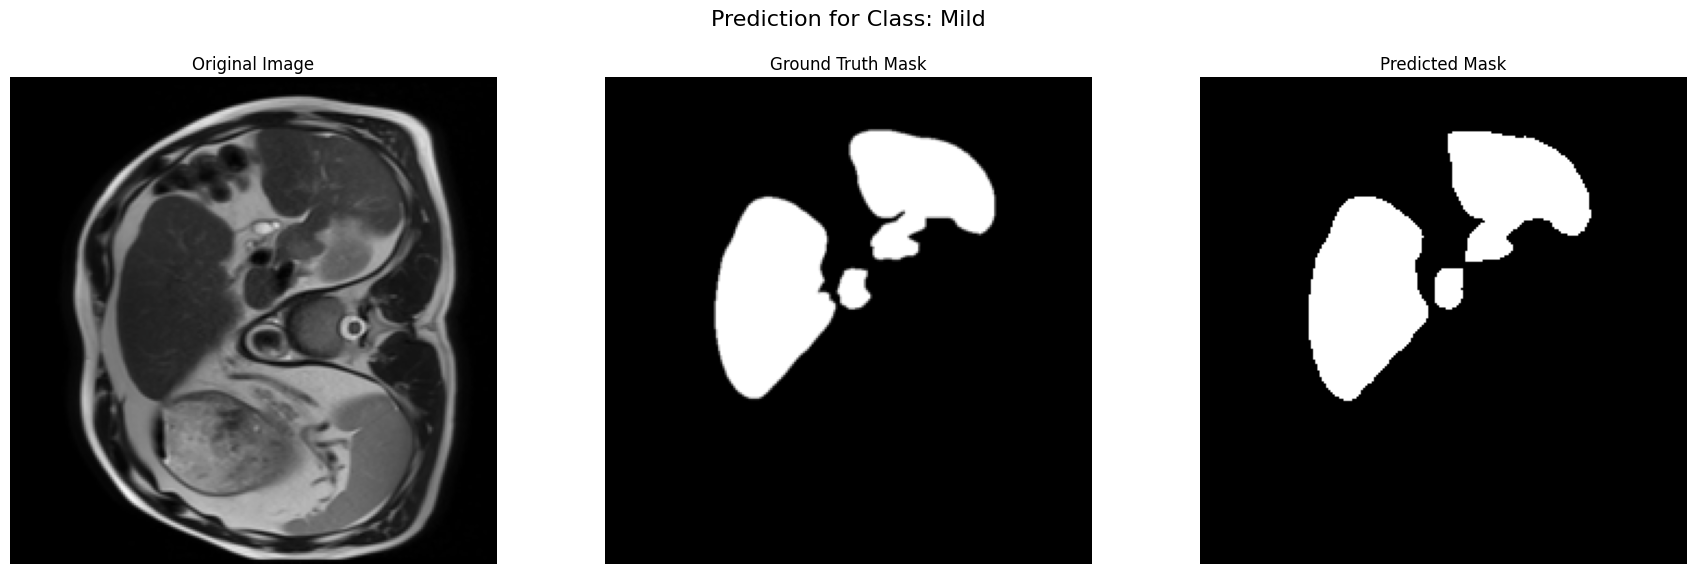

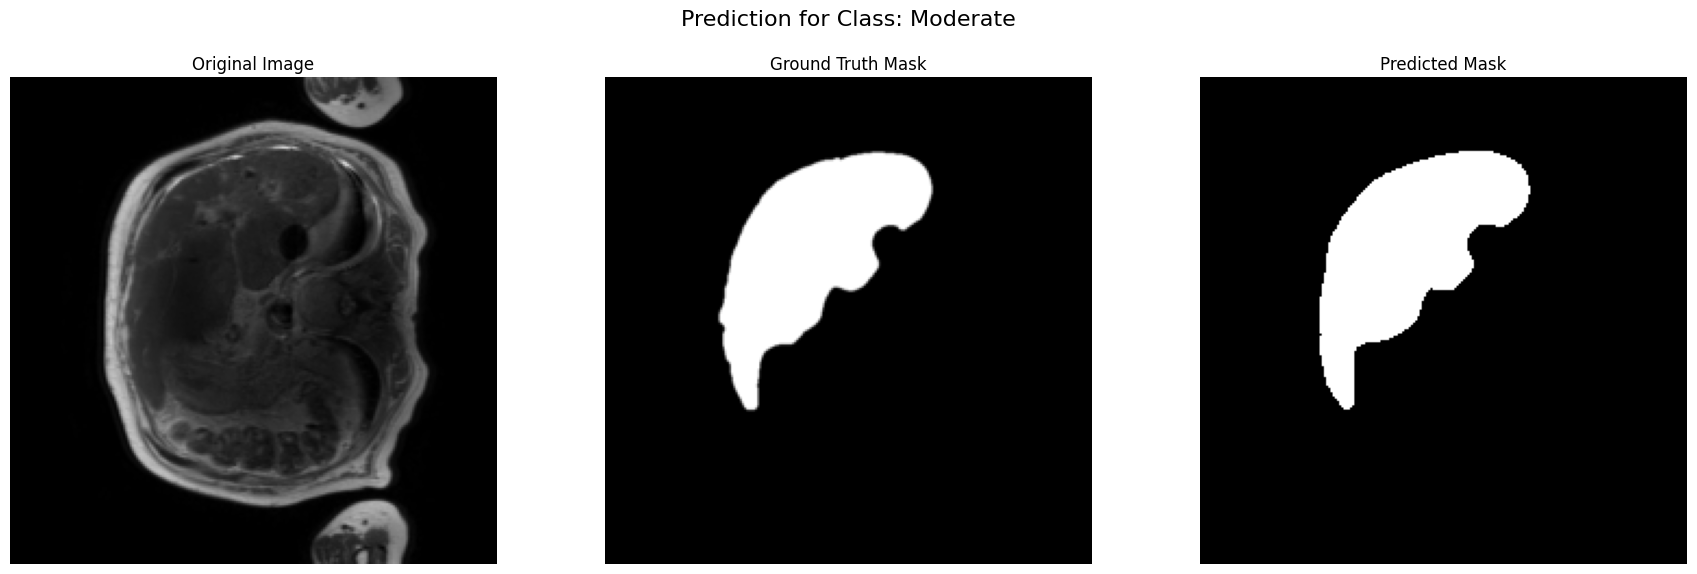

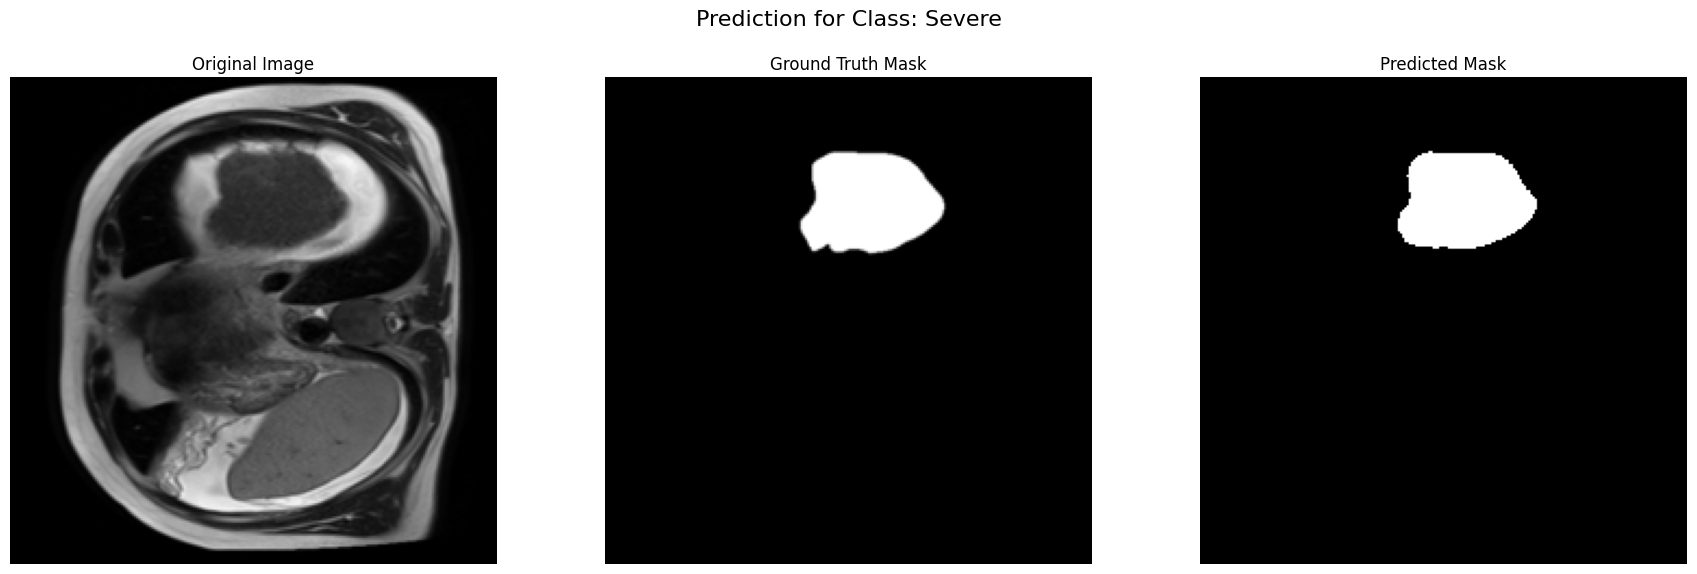

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F_T
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
from PIL import Image

# --- CONFIGURATION ---
# Choose which model to use: 'AttentionUNet' or 'DeepLabV3+'
MODEL_CHOICE = 'AttentionUNet' 

# --- Set Seeds for Reproducibility ---
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set CUDA_LAUNCH_BLOCKING for easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- Data Loading and Preparation ---
try:
    metadata_df = pd.read_csv('/kaggle/input/t2metadata/T2_age_gender_evaluation.csv')
    print("Successfully loaded metadata CSV.")
except FileNotFoundError:
    print("Error: 'T2_age_gender_evaluation.csv' not found. Please ensure the file is in the correct path.")
    metadata_df = pd.DataFrame(columns=['Patient ID', 'Age', 'Gender', 'Radiological Evaluation'])

# Rename and process columns
metadata_df.rename(columns={
    'Patient ID': 'ID',
    'Radiological Evaluation': 'radiological_evaluation'
}, inplace=True)
metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)

# --- ★★★ CORRECTED CLASS MAPPING SECTION ★★★ ---
# Mapping updated as per your requirement.
# 1 -> Mild      -> 0
# 2 -> Moderate  -> 1
# 3 -> Severe    -> 2
class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
class_label_map = {1: 0, 2: 1, 3: 2} # Explicitly define the mapping

metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map) 
class_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'} # For evaluation reports

# Drop any rows where mapping might have failed (if new radiological values appear)
metadata_df.dropna(subset=['class_label'], inplace=True)
metadata_df['class_label'] = metadata_df['class_label'].astype(int)

print("\n--- Classification Task Setup ---")
print("Class Mapping for Evaluation:", class_map)

metadata_df['ID'] = metadata_df['ID'].astype(str)
valid_ids = set(metadata_df['ID'].tolist())

def create_dataframe_from_ids(directory, allowed_ids):
    data = []
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' not found. Skipping.")
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])
    for folder_name in os.listdir(directory):
        if folder_name in allowed_ids:
            folder_path = os.path.join(directory, folder_name)
            images_dir = os.path.join(folder_path, 'images')
            masks_dir = os.path.join(folder_path, 'masks')
            if os.path.exists(images_dir) and os.path.exists(masks_dir):
                for image_file in os.listdir(images_dir):
                    image_path = os.path.join(images_dir, image_file)
                    mask_path = os.path.join(masks_dir, image_file)
                    if os.path.exists(mask_path):
                        data.append((folder_name, image_path, mask_path))
    return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

train_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
valid_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
test_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

train_df = pd.merge(create_dataframe_from_ids(train_dir, valid_ids), metadata_df, on='ID')
val_df = pd.merge(create_dataframe_from_ids(valid_dir, valid_ids), metadata_df, on='ID')
test_df = pd.merge(create_dataframe_from_ids(test_dir, valid_ids), metadata_df, on='ID')

print(f"\nTraining samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

# --- Dataset and Transforms ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224), is_train=True):
        self.image_size = image_size
        self.is_train = is_train
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        
    def __call__(self, image, mask):
        image = F_T.resize(image, self.image_size, interpolation=F_T.InterpolationMode.BILINEAR)
        mask = F_T.resize(mask, self.image_size, interpolation=F_T.InterpolationMode.NEAREST)
        if self.is_train:
            if random.random() > 0.5: image, mask = F_T.hflip(image), F_T.hflip(mask)
            if random.random() > 0.5: image, mask = F_T.vflip(image), F_T.vflip(mask)
            angle = random.uniform(-15, 15)
            image, mask = F_T.rotate(image, angle), F_T.rotate(mask, angle)
        image = F_T.to_tensor(image)
        mask = F_T.to_tensor(mask)
        image = F_T.normalize(image, mean=self.mean.flatten(), std=self.std.flatten())
        mask = (mask > 0).float()
        return image, mask

    def denormalize(self, tensor_image):
        """Denormalizes a tensor image for visualization."""
        return tensor_image * self.std + self.mean

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_file_path']).convert('RGB')
        mask = Image.open(row['mask_file_path']).convert('L')
        class_label = torch.tensor(row['class_label'], dtype=torch.long)
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask, class_label

# --- MODEL DEFINITIONS ---

# Model 1: Attention U-Net
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, kernel_size=1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1):
        super(AttentionUNet, self).__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base_layers = list(base_model.children())
        
        self.encoder0 = nn.Sequential(*base_layers[:3]) # 64
        self.encoder1 = nn.Sequential(*base_layers[3:5]) # 256
        self.encoder2 = base_layers[5] # 512
        self.encoder3 = base_layers[6] # 1024
        self.encoder4 = base_layers[7] # 2048

        self.upconv3 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.attn3 = AttentionGate(F_g=1024, F_l=1024, F_int=512)
        self.dec_conv3 = ConvBlock(2048, 1024)

        self.upconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attn2 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.dec_conv2 = ConvBlock(1024, 512)

        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attn1 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.dec_conv1 = ConvBlock(512, 256)

        self.upconv0 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.attn0 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec_conv0 = ConvBlock(128, 64)

        self.final_up = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        e0 = self.encoder0(x); e1 = self.encoder1(e0); e2 = self.encoder2(e1)
        e3 = self.encoder3(e2); e4 = self.encoder4(e3)

        d3 = self.upconv3(e4)
        x3 = self.attn3(g=d3, x=e3)
        d3 = torch.cat((x3, d3), dim=1)
        d3 = self.dec_conv3(d3)

        d2 = self.upconv2(d3)
        x2 = self.attn2(g=d2, x=e2)
        d2 = torch.cat((x2, d2), dim=1)
        d2 = self.dec_conv2(d2)

        d1 = self.upconv1(d2)
        x1 = self.attn1(g=d1, x=e1)
        d1 = torch.cat((x1, d1), dim=1)
        d1 = self.dec_conv1(d1)
        
        d0 = self.upconv0(d1)
        x0 = self.attn0(g=d0, x=e0)
        d0 = torch.cat((x0, d0), dim=1)
        d0 = self.dec_conv0(d0)

        out = self.final_up(d0)
        return self.final_conv(out)

# Model 2: DeepLabV3+ with ResNet50 Backbone
def get_deeplabv3plus(n_classes=1):
    model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
    model.classifier[4] = nn.Conv2d(256, n_classes, kernel_size=1)
    model.aux_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=1)
    return model


# --- Loss, Metrics, and Training Functions ---
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat, targets_flat = inputs_sig.view(-1), targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        return bce + dice_loss

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

def train_one_epoch(loader, model, optimizer, loss_fn, device, model_name):
    model.train()
    running_loss, total_dice = 0.0, 0.0
    for images, masks, _ in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        if model_name == 'DeepLabV3+' and isinstance(outputs, dict):
            loss = loss_fn(outputs['out'], masks) + 0.5 * loss_fn(outputs['aux'], masks)
            main_outputs = outputs['out']
        else:
            loss = loss_fn(outputs, masks)
            main_outputs = outputs

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        dice, _ = calculate_metrics(main_outputs, masks)
        total_dice += dice * images.size(0)
        
    return running_loss / len(loader.dataset), total_dice / len(loader.dataset)

def evaluate_model(loader, model, loss_fn, device, class_mapping, dataset_name="Validation"):
    model.eval()
    all_preds, all_masks, all_labels = [], [], []
    running_loss = 0.0
    with torch.no_grad():
        for images, masks, labels in tqdm(loader, desc=f"Evaluating on {dataset_name}"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            main_outputs = outputs['out'] if isinstance(outputs, dict) else outputs
            running_loss += loss_fn(main_outputs, masks).item() * images.size(0)
            all_preds.append(main_outputs.cpu()); all_masks.append(masks.cpu()); all_labels.append(labels.cpu())

    all_preds, all_masks, all_labels = torch.cat(all_preds), torch.cat(all_masks), torch.cat(all_labels)
    avg_loss, (overall_dice, overall_iou) = running_loss / len(loader.dataset), calculate_metrics(all_preds, all_masks)
    
    print(f"\n--- {dataset_name} Report ---")
    print(f"Overall -> Loss: {avg_loss:.4f}, Dice: {overall_dice:.4f}, mIoU: {overall_iou:.4f}")
    
    print("--- Per-Class Metrics ---")
    for class_idx, class_name in class_mapping.items():
        indices = (all_labels == class_idx).nonzero(as_tuple=True)[0]
        if len(indices) > 0:
            class_dice, class_iou = calculate_metrics(all_preds[indices], all_masks[indices])
            print(f"Class '{class_name}' ({len(indices)} samples) -> Dice: {class_dice:.4f}, mIoU: {class_iou:.4f}")
            
    return avg_loss, overall_dice

# --- TRAINING EXECUTION ---
train_transform = SegmentationTransform(is_train=True)
val_transform = SegmentationTransform(is_train=False)

train_dataset = LiverDataset(train_df, transform=train_transform)
val_dataset = LiverDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Instantiate the chosen model
if MODEL_CHOICE == 'AttentionUNet':
    model = AttentionUNet(n_classes=1).to(device)
    print("\n--- Model Selected: Attention U-Net ---")
elif MODEL_CHOICE == 'DeepLabV3+':
    model = get_deeplabv3plus(n_classes=1).to(device)
    print("\n--- Model Selected: DeepLabV3+ ---")
else:
    raise ValueError("Invalid MODEL_CHOICE. Please choose 'AttentionUNet' or 'DeepLabV3+'")

optimizer = AdamW(model.parameters(), lr=1e-4)
criterion = DiceBCELoss()
num_epochs = 20
best_val_dice = 0.0

print(f"--- Starting Model Training for {MODEL_CHOICE} ---")
if len(train_dataset) > 0:
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_dice = train_one_epoch(train_loader, model, optimizer, criterion, device, MODEL_CHOICE)
        print(f"Training -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        
        val_loss, val_dice = evaluate_model(val_loader, model, criterion, device, class_map)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_segmentation_model.pth')
            print(f"✅ Model Saved! New Best Dice: {best_val_dice:.4f}")
else:
    print("🛑 Training dataset is empty. Cannot start training.")

# --- FINAL TEST EVALUATION ---
print("\n--- Starting Final Evaluation on Test Set ---")
if not test_df.empty:
    test_dataset = LiverDataset(test_df, transform=val_transform) # Use validation transform
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
    
    # Re-instantiate the model structure
    if MODEL_CHOICE == 'AttentionUNet':
        eval_model = AttentionUNet(n_classes=1).to(device)
    elif MODEL_CHOICE == 'DeepLabV3+':
        eval_model = get_deeplabv3plus(n_classes=1).to(device)
    else: # Added a fallback
        eval_model = None
        print("🛑 Invalid MODEL_CHOICE for evaluation.")

    if eval_model:
      try:
          # Load the best weights saved during training
          eval_model.load_state_dict(torch.load('best_segmentation_model.pth', map_location=device))
          print("Best segmentation model loaded for final evaluation. ✅")
          
          # Run evaluation on the test set
          evaluate_model(test_loader, eval_model, criterion, device, class_map, dataset_name="Test")
          
      except FileNotFoundError:
          print("Error: Model file 'best_segmentation_model.pth' not found. Cannot perform final evaluation. 🛑")
else:
    print("Test dataset is empty. Skipping final evaluation.")


# --- VISUALIZATION SECTION ---
def visualize_predictions(model, test_df, transforms, device, num_samples_per_class=1):
    print("\n--- Generating Prediction Visualizations ---")
    if model is None:
        print("🛑 Skipping visualization as the evaluation model was not loaded.")
        return

    model.eval()
    
    # Reload the best model weights to ensure visualization uses the best version
    try:
        model.load_state_dict(torch.load('best_segmentation_model.pth', map_location=device))
        print("Best model weights loaded for visualization.")
    except FileNotFoundError:
        print("Could not find 'best_segmentation_model.pth'. Visualizing with the last epoch's model.")

    grouped = test_df.groupby('class_name')

    for class_name, group in grouped:
        # Take random samples from each class group
        samples = group.sample(min(len(group), num_samples_per_class))
        for _, row in samples.iterrows():
            original_image = Image.open(row['image_file_path']).convert('RGB')
            original_mask = Image.open(row['mask_file_path']).convert('L')

            # Apply transformations to image for model input
            input_tensor, _ = transforms(original_image, original_mask)
            input_tensor = input_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                pred_logits = output['out'] if isinstance(output, dict) else output
                pred_mask = (torch.sigmoid(pred_logits) > 0.5).float().cpu().squeeze(0)

            # Prepare images for plotting
            display_image = transforms.denormalize(input_tensor.cpu().squeeze(0))
            display_image = display_image.permute(1, 2, 0).numpy()
            display_mask = F_T.resize(original_mask, (224, 224))

            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            fig.suptitle(f"Prediction for Class: {class_name}", fontsize=16)
            
            axes[0].imshow(display_image); axes[0].set_title("Original Image"); axes[0].axis('off')
            axes[1].imshow(display_mask, cmap='gray'); axes[1].set_title("Ground Truth Mask"); axes[1].axis('off')
            axes[2].imshow(pred_mask.squeeze(), cmap='gray'); axes[2].set_title("Predicted Mask"); axes[2].axis('off')
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

# Use the model instance from the test evaluation for visualization
if 'eval_model' in locals():
    visualize_predictions(eval_model, test_df, val_transform, device, num_samples_per_class=1)
else:
    print("🛑 Could not run visualization as eval_model was not created.")

LinTransUnet-Swin UNETR

In [2]:
!pip install monai einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.8 MB/s eta 0:00:0000:0100:01


Using device: cuda ⚙️
Successfully loaded metadata CSV.

--- Classification Task Setup ---
Class Mapping for Evaluation: {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

Training samples: 5364, Validation samples: 674, Test samples: 664

--- Model Selected: LinTransUnet ---
--- Starting Model Training for LinTransUnet ---

Epoch 1/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.3450, Dice: 0.7478


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.91it/s]



--- Validation Report ---
Overall Dice: 0.9256
Overall mIoU: 0.8615

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9377, mIoU: 0.8827
Class 'Moderate' -> Dice: 0.9232, mIoU: 0.8574
Class 'Severe' -> Dice: 0.8992, mIoU: 0.8168
✅ Model Saved! New Best Dice: 0.9256

Epoch 2/20


Training: 100%|██████████| 336/336 [02:48<00:00,  2.00it/s]


Training -> Loss: 0.1036, Dice: 0.9352


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.91it/s]



--- Validation Report ---
Overall Dice: 0.9362
Overall mIoU: 0.8800

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9386, mIoU: 0.8844
Class 'Moderate' -> Dice: 0.9487, mIoU: 0.9023
Class 'Severe' -> Dice: 0.9081, mIoU: 0.8317
✅ Model Saved! New Best Dice: 0.9362

Epoch 3/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0869, Dice: 0.9455


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.97it/s]



--- Validation Report ---
Overall Dice: 0.9386
Overall mIoU: 0.8842

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9460, mIoU: 0.8975
Class 'Moderate' -> Dice: 0.9451, mIoU: 0.8960
Class 'Severe' -> Dice: 0.9081, mIoU: 0.8316
✅ Model Saved! New Best Dice: 0.9386

Epoch 4/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0766, Dice: 0.9519


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.83it/s]



--- Validation Report ---
Overall Dice: 0.9408
Overall mIoU: 0.8882

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9440, mIoU: 0.8940
Class 'Moderate' -> Dice: 0.9494, mIoU: 0.9036
Class 'Severe' -> Dice: 0.9175, mIoU: 0.8476
✅ Model Saved! New Best Dice: 0.9408

Epoch 5/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0708, Dice: 0.9554


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.93it/s]



--- Validation Report ---
Overall Dice: 0.9475
Overall mIoU: 0.9003

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9544, mIoU: 0.9127
Class 'Moderate' -> Dice: 0.9486, mIoU: 0.9023
Class 'Severe' -> Dice: 0.9283, mIoU: 0.8663
✅ Model Saved! New Best Dice: 0.9475

Epoch 6/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0680, Dice: 0.9571


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]



--- Validation Report ---
Overall Dice: 0.9512
Overall mIoU: 0.9070

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9563, mIoU: 0.9162
Class 'Moderate' -> Dice: 0.9550, mIoU: 0.9138
Class 'Severe' -> Dice: 0.9321, mIoU: 0.8729
✅ Model Saved! New Best Dice: 0.9512

Epoch 7/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0640, Dice: 0.9596


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]



--- Validation Report ---
Overall Dice: 0.9435
Overall mIoU: 0.8930

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9454, mIoU: 0.8964
Class 'Moderate' -> Dice: 0.9504, mIoU: 0.9055
Class 'Severe' -> Dice: 0.9267, mIoU: 0.8634

Epoch 8/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0607, Dice: 0.9616


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]



--- Validation Report ---
Overall Dice: 0.9500
Overall mIoU: 0.9048

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9567, mIoU: 0.9171
Class 'Moderate' -> Dice: 0.9506, mIoU: 0.9059
Class 'Severe' -> Dice: 0.9321, mIoU: 0.8728

Epoch 9/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0588, Dice: 0.9628


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.94it/s]



--- Validation Report ---
Overall Dice: 0.9517
Overall mIoU: 0.9079

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9553, mIoU: 0.9144
Class 'Moderate' -> Dice: 0.9539, mIoU: 0.9119
Class 'Severe' -> Dice: 0.9389, mIoU: 0.8849
✅ Model Saved! New Best Dice: 0.9517

Epoch 10/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0560, Dice: 0.9645


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.95it/s]



--- Validation Report ---
Overall Dice: 0.9529
Overall mIoU: 0.9101

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9608, mIoU: 0.9246
Class 'Moderate' -> Dice: 0.9529, mIoU: 0.9101
Class 'Severe' -> Dice: 0.9333, mIoU: 0.8749
✅ Model Saved! New Best Dice: 0.9529

Epoch 11/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0536, Dice: 0.9660


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.97it/s]



--- Validation Report ---
Overall Dice: 0.9533
Overall mIoU: 0.9108

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9591, mIoU: 0.9214
Class 'Moderate' -> Dice: 0.9545, mIoU: 0.9129
Class 'Severe' -> Dice: 0.9368, mIoU: 0.8810
✅ Model Saved! New Best Dice: 0.9533

Epoch 12/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0528, Dice: 0.9665


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]



--- Validation Report ---
Overall Dice: 0.9478
Overall mIoU: 0.9008

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9511, mIoU: 0.9068
Class 'Moderate' -> Dice: 0.9505, mIoU: 0.9057
Class 'Severe' -> Dice: 0.9349, mIoU: 0.8778

Epoch 13/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0498, Dice: 0.9683


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.89it/s]



--- Validation Report ---
Overall Dice: 0.9463
Overall mIoU: 0.8981

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9534, mIoU: 0.9110
Class 'Moderate' -> Dice: 0.9485, mIoU: 0.9021
Class 'Severe' -> Dice: 0.9243, mIoU: 0.8593

Epoch 14/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0498, Dice: 0.9684


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]



--- Validation Report ---
Overall Dice: 0.9509
Overall mIoU: 0.9064

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9575, mIoU: 0.9185
Class 'Moderate' -> Dice: 0.9505, mIoU: 0.9056
Class 'Severe' -> Dice: 0.9352, mIoU: 0.8783

Epoch 15/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0505, Dice: 0.9679


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.93it/s]



--- Validation Report ---
Overall Dice: 0.9485
Overall mIoU: 0.9020

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9565, mIoU: 0.9166
Class 'Moderate' -> Dice: 0.9474, mIoU: 0.9001
Class 'Severe' -> Dice: 0.9300, mIoU: 0.8692

Epoch 16/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0488, Dice: 0.9690


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.96it/s]



--- Validation Report ---
Overall Dice: 0.9490
Overall mIoU: 0.9030

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9505, mIoU: 0.9057
Class 'Moderate' -> Dice: 0.9532, mIoU: 0.9106
Class 'Severe' -> Dice: 0.9381, mIoU: 0.8834

Epoch 17/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0454, Dice: 0.9711


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.95it/s]



--- Validation Report ---
Overall Dice: 0.9514
Overall mIoU: 0.9072

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9531, mIoU: 0.9105
Class 'Moderate' -> Dice: 0.9561, mIoU: 0.9159
Class 'Severe' -> Dice: 0.9387, mIoU: 0.8845

Epoch 18/20


Training: 100%|██████████| 336/336 [02:48<00:00,  2.00it/s]


Training -> Loss: 0.0437, Dice: 0.9722


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.95it/s]



--- Validation Report ---
Overall Dice: 0.9516
Overall mIoU: 0.9077

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9558, mIoU: 0.9154
Class 'Moderate' -> Dice: 0.9549, mIoU: 0.9137
Class 'Severe' -> Dice: 0.9352, mIoU: 0.8784

Epoch 19/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0425, Dice: 0.9730


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.93it/s]



--- Validation Report ---
Overall Dice: 0.9517
Overall mIoU: 0.9078

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9565, mIoU: 0.9166
Class 'Moderate' -> Dice: 0.9525, mIoU: 0.9092
Class 'Severe' -> Dice: 0.9382, mIoU: 0.8837

Epoch 20/20


Training: 100%|██████████| 336/336 [02:48<00:00,  1.99it/s]


Training -> Loss: 0.0416, Dice: 0.9735


Evaluating: 100%|██████████| 43/43 [00:07<00:00,  5.93it/s]



--- Validation Report ---
Overall Dice: 0.9438
Overall mIoU: 0.8936

--- Per-Class Metrics ---
Class 'Mild' -> Dice: 0.9416, mIoU: 0.8896
Class 'Moderate' -> Dice: 0.9559, mIoU: 0.9156
Class 'Severe' -> Dice: 0.9282, mIoU: 0.8661

--- Generating Prediction Visualizations ---
Best model weights loaded for visualization.


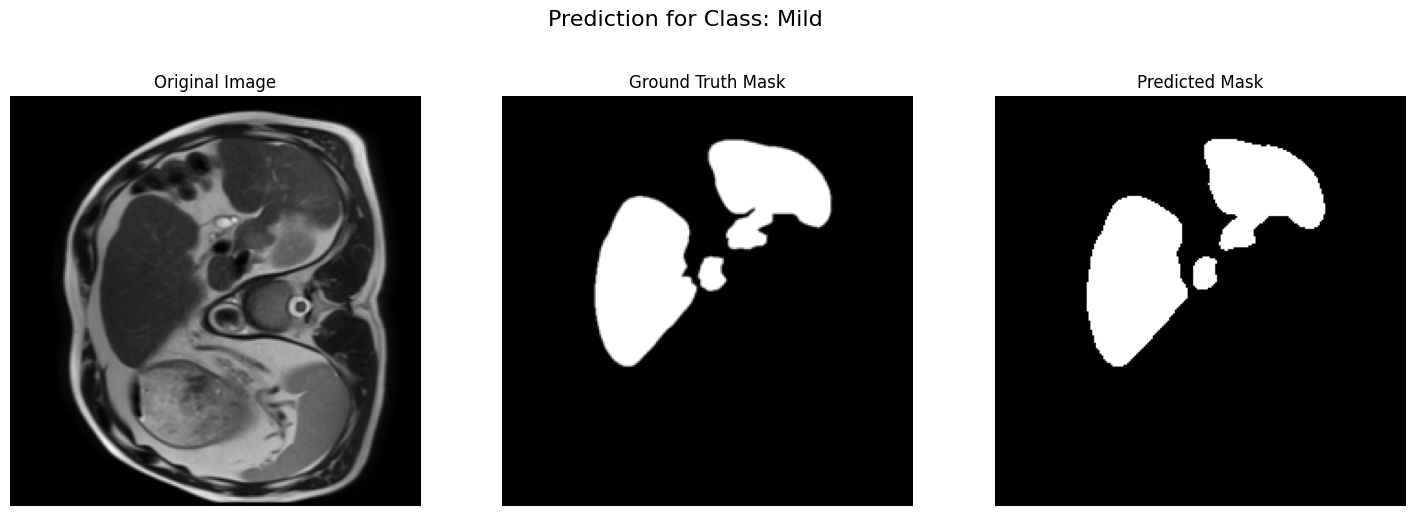

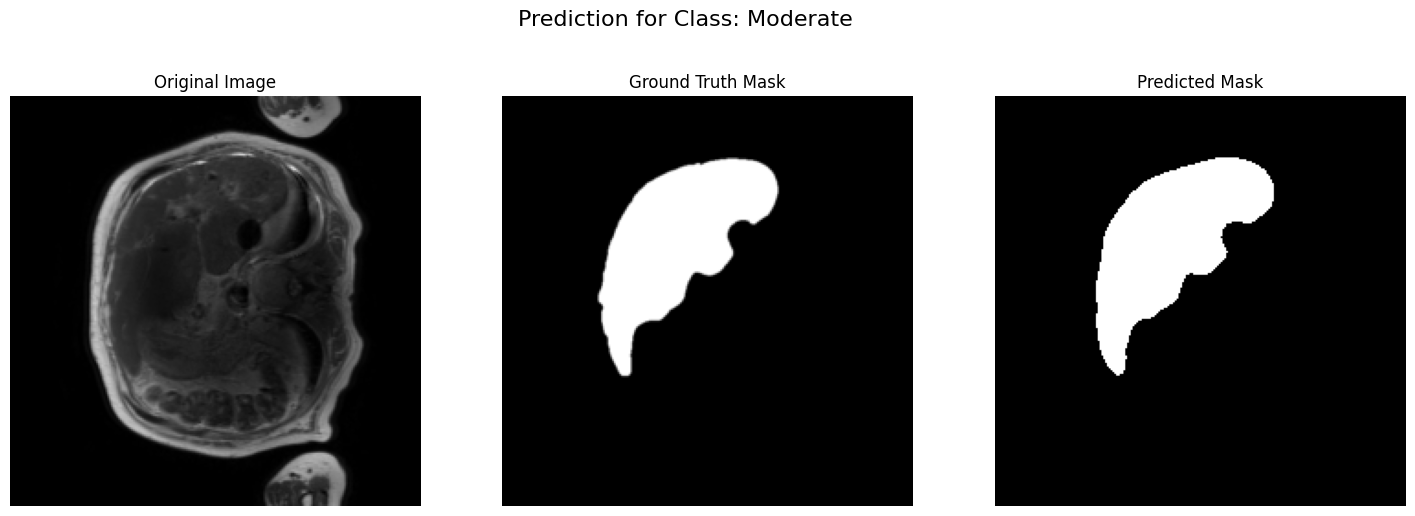

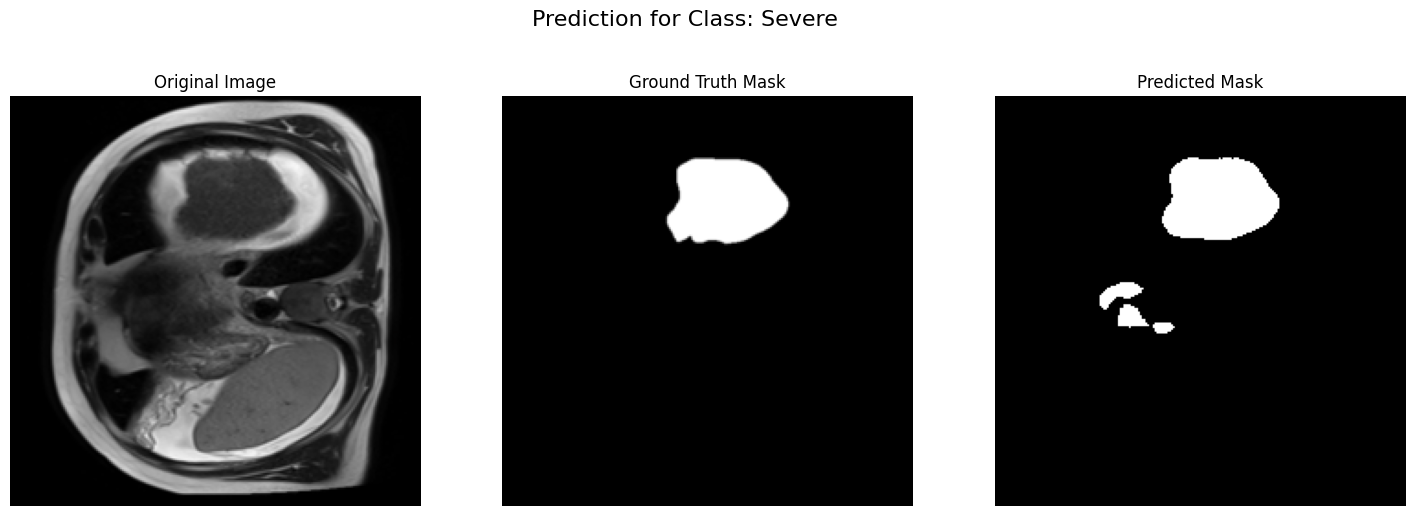

In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F_T
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
from PIL import Image

# --- NEW: Import MONAI for Swin UNETR ---
try:
    from monai.networks.nets import SwinUNETR
except ImportError:
    print("MONAI not found. Please install it using: pip install monai einops")
    SwinUNETR = None

# --- CONFIGURATION ---
# Choose which model to use: 'LinTransUnet' or 'SwinUNETR'
MODEL_CHOICE = 'LinTransUnet'

# --- Set Seeds for Reproducibility ---
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- Data Loading and Preparation ---
try:
    metadata_df = pd.read_csv('/kaggle/input/t2metadata/T2_age_gender_evaluation.csv')
    print("Successfully loaded metadata CSV.")
except FileNotFoundError:
    print("Error: 'T2_age_gender_evaluation.csv' not found.")
    metadata_df = pd.DataFrame()

if not metadata_df.empty:
    # --- UPDATED SECTION: Correct Class Mapping ---
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)

    # Define the correct mapping from radiological score to class name and label
    # 1 -> Mild (label 0)
    # 2 -> Moderate (label 1)
    # 3 -> Severe (label 2)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_label_map = {1: 0, 2: 1, 3: 2}

    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)
    
    # Final class map for evaluation and visualization
    class_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

    print("\n--- Classification Task Setup ---")
    print("Class Mapping for Evaluation:", class_map)
    
    metadata_df['ID'] = metadata_df['ID'].astype(str)
    valid_ids = set(metadata_df['ID'].tolist())
    # --- END OF UPDATED SECTION ---
else:
    valid_ids = set()
    class_map = {}

def create_dataframe_from_ids(directory, allowed_ids):
    data = []
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' not found.")
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])
    for folder_name in os.listdir(directory):
        if folder_name in allowed_ids:
            folder_path = os.path.join(directory, folder_name)
            images_dir = os.path.join(folder_path, 'images')
            masks_dir = os.path.join(folder_path, 'masks')
            if os.path.exists(images_dir) and os.path.exists(masks_dir):
                for image_file in os.listdir(images_dir):
                    image_path = os.path.join(images_dir, image_file)
                    mask_path = os.path.join(masks_dir, image_file)
                    if os.path.exists(mask_path):
                        data.append((folder_name, image_path, mask_path))
    return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

train_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
valid_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
test_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

train_df = pd.merge(create_dataframe_from_ids(train_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()
val_df = pd.merge(create_dataframe_from_ids(valid_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()
test_df = pd.merge(create_dataframe_from_ids(test_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()

print(f"\nTraining samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

# --- Dataset and Transforms ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224), is_train=True):
        self.image_size = image_size
        self.is_train = is_train
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        
    def __call__(self, image, mask):
        image = F_T.resize(image, self.image_size, interpolation=F_T.InterpolationMode.BILINEAR)
        mask = F_T.resize(mask, self.image_size, interpolation=F_T.InterpolationMode.NEAREST)
        if self.is_train and random.random() > 0.5: image, mask = F_T.hflip(image), F_T.hflip(mask)
        image = F_T.to_tensor(image)
        mask = F_T.to_tensor(mask)
        image = F_T.normalize(image, mean=self.mean.flatten(), std=self.std.flatten())
        mask = (mask > 0).float()
        return image, mask

    def denormalize(self, tensor_image):
        return tensor_image * self.std + self.mean

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_file_path']).convert('RGB')
        mask = Image.open(row['mask_file_path']).convert('L')
        # Ensure class_label is not None before creating a tensor
        class_label = row.get('class_label', -1) # Default to -1 if not found
        if class_label is None or class_label == -1:
             raise ValueError(f"Missing class_label for row {idx}")
        class_label_tensor = torch.tensor(class_label, dtype=torch.long)
        image, mask = self.transform(image, mask)
        return image, mask, class_label_tensor

# --- MODEL DEFINITIONS (Unchanged) ---
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(t.shape[0], -1, self.heads, t.shape[-1] // self.heads).transpose(1, 2), qkv)
        q = q.softmax(dim=-1)
        k = k.softmax(dim=-2)
        q = q * self.scale
        context = torch.einsum('b h n d, b h n e -> b h d e', k, v)
        out = torch.einsum('b h d e, b h n d -> b h n e', context, q)
        out = out.transpose(1, 2).reshape(out.shape[0], -1, self.heads * (out.shape[-1]))
        return self.to_out(out)

class LinTransUnet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        base_layers = list(base_model.children())
        
        # Encoder
        self.encoder0 = nn.Sequential(*base_layers[:3]) # 64
        self.encoder1 = nn.Sequential(*base_layers[3:5]) # 256
        self.encoder2 = base_layers[5] # 512
        self.encoder3 = base_layers[6] # 1024
        self.bottleneck = base_layers[7] # 2048

        # Linear Transformer
        self.linear_attention = LinearAttention(dim=2048)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(2048, 1024, 2, 2)
        self.dec_conv3 = nn.Conv2d(2048, 1024, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec_conv2 = nn.Conv2d(1024, 512, 3, padding=1)
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec_conv1 = nn.Conv2d(512, 256, 3, padding=1)
        self.upconv0 = nn.ConvTranspose2d(256, 64, 2, 2)
        self.dec_conv0 = nn.Conv2d(128, 64, 3, padding=1)
        
        self.final_up = nn.ConvTranspose2d(64, 32, 2, 2)
        self.final_conv = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        e0 = self.encoder0(x)
        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        
        b = self.bottleneck(e3)
        bs, c, h, w = b.shape
        b_flat = b.view(bs, c, -1).transpose(1, 2)
        attn_out = self.linear_attention(b_flat)
        b = attn_out.transpose(1, 2).view(bs, c, h, w)
        
        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = F.relu(self.dec_conv3(d3))
        
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = F.relu(self.dec_conv2(d2))

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = F.relu(self.dec_conv1(d1))

        d0 = self.upconv0(d1)
        d0 = torch.cat((d0, e0), dim=1)
        d0 = F.relu(self.dec_conv0(d0))
        
        out = self.final_up(d0)
        return self.final_conv(out)

# --- Loss, Metrics, and Training Functions ---
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat, targets_flat = inputs_sig.view(-1), targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        return bce + dice_loss

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    dice = (2. * intersection + smooth) / (preds_flat.sum() + targets_flat.sum() + smooth)
    return dice.item()

# --- NEW FUNCTION: Calculate IoU ---
def calculate_iou(preds, targets, smooth=1e-6):
    """Calculates Intersection over Union (Jaccard Index)."""
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    
    intersection = (preds_flat * targets_flat).sum()
    total = (preds_flat + targets_flat).sum()
    union = total - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()
# --- END OF NEW FUNCTION ---

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss, total_dice = 0.0, 0.0
    for images, masks, _ in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_dice += calculate_metrics(outputs, masks) * images.size(0)
    return running_loss / len(loader.dataset), total_dice / len(loader.dataset)

# --- UPDATED SECTION: Enhanced Evaluation Function ---
def evaluate_model(loader, model, loss_fn, device, class_mapping):
    model.eval()
    all_preds, all_masks, all_labels = [], [], []
    with torch.no_grad():
        for images, masks, labels in tqdm(loader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            all_preds.append(outputs.cpu())
            all_masks.append(masks.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_masks = torch.cat(all_masks)
    all_labels = torch.cat(all_labels)
    
    # Calculate overall metrics
    overall_dice = calculate_metrics(all_preds, all_masks)
    overall_iou = calculate_iou(all_preds, all_masks)
    
    print(f"\n--- Validation Report ---")
    print(f"Overall Dice: {overall_dice:.4f}")
    print(f"Overall mIoU: {overall_iou:.4f}")
    
    # Calculate per-class metrics
    print("\n--- Per-Class Metrics ---")
    for class_idx, class_name in class_mapping.items():
        # Find indices for the current class
        indices = (all_labels == class_idx).nonzero(as_tuple=True)[0]
        
        if len(indices) == 0:
            print(f"Class '{class_name}': No samples found in this batch.")
            continue
            
        # Select data for the current class
        class_preds = all_preds[indices]
        class_masks = all_masks[indices]
        
        # Calculate metrics for the class
        class_dice = calculate_metrics(class_preds, class_masks)
        class_iou = calculate_iou(class_preds, class_masks)
        
        print(f"Class '{class_name}' -> Dice: {class_dice:.4f}, mIoU: {class_iou:.4f}")
        
    # Return the primary metric for model saving
    return overall_dice
# --- END OF UPDATED SECTION ---

# --- TRAINING EXECUTION (Unchanged) ---
if not train_df.empty and not val_df.empty:
    train_transform = SegmentationTransform(is_train=True)
    val_transform = SegmentationTransform(is_train=False)

    train_dataset = LiverDataset(train_df, transform=train_transform)
    val_dataset = LiverDataset(val_df, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    if MODEL_CHOICE == 'LinTransUnet':
        model = LinTransUnet(n_classes=1).to(device)
        print("\n--- Model Selected: LinTransUnet ---")
    elif MODEL_CHOICE == 'SwinUNETR':
        if SwinUNETR is None:
            raise ImportError("SwinUNETR model requires MONAI. Please install it.")
        model = SwinUNETR(img_size=(224, 224), in_channels=3, out_channels=1, feature_size=48).to(device)
        print("\n--- Model Selected: Swin UNETR ---")
    else:
        raise ValueError("Invalid MODEL_CHOICE. Choose 'LinTransUnet' or 'SwinUNETR'")

    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = DiceBCELoss()
    num_epochs = 20
    best_val_dice = 0.0

    print(f"--- Starting Model Training for {MODEL_CHOICE} ---")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_dice = train_one_epoch(train_loader, model, optimizer, criterion, device)
        print(f"Training -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        
        val_dice = evaluate_model(val_loader, model, criterion, device, class_map)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_segmentation_model.pth')
            print(f"✅ Model Saved! New Best Dice: {best_val_dice:.4f}")
else:
    print("🛑 Training or validation dataset is empty. Cannot start training.")
    model = None

# --- VISUALIZATION SECTION (Unchanged) ---
def visualize_predictions(model, test_df, transforms, device, num_samples_per_class=1):
    if model is None or test_df.empty:
        print("\nSkipping visualization: model not trained or test data is empty.")
        return
        
    print("\n--- Generating Prediction Visualizations ---")
    model.eval()
    
    try:
        model.load_state_dict(torch.load('best_segmentation_model.pth', map_location=device))
        print("Best model weights loaded for visualization.")
    except (FileNotFoundError, RuntimeError) as e:
        print(f"Could not load best weights ({e}). Visualizing with last epoch's model.")

    grouped = test_df.groupby('class_name')
    for class_name, group in grouped:
        samples = group.sample(min(len(group), num_samples_per_class))
        for _, row in samples.iterrows():
            original_image = Image.open(row['image_file_path']).convert('RGB')
            original_mask = Image.open(row['mask_file_path']).convert('L')

            input_tensor, _ = transforms(original_image, original_mask)
            input_tensor = input_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                pred_logits = model(input_tensor)
                pred_mask = (torch.sigmoid(pred_logits) > 0.5).float().cpu().squeeze(0)

            display_image = transforms.denormalize(input_tensor.cpu().squeeze(0))
            display_image = display_image.permute(1, 2, 0).numpy()
            display_mask = F_T.resize(original_mask, (224, 224))

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            fig.suptitle(f"Prediction for Class: {class_name}", fontsize=16)
            axes[0].imshow(display_image); axes[0].set_title("Original Image"); axes[0].axis('off')
            axes[1].imshow(display_mask, cmap='gray'); axes[1].set_title("Ground Truth Mask"); axes[1].axis('off')
            axes[2].imshow(pred_mask.squeeze(), cmap='gray'); axes[2].set_title("Predicted Mask"); axes[2].axis('off')
            plt.show()

if model and not test_df.empty:
    visualize_predictions(model, test_df, val_transform, device, num_samples_per_class=1)

U²-Net and VGG16

In [5]:
!pip install transformers

Using device: cuda ⚙️
Successfully loaded metadata CSV.

--- Classification Task Setup ---
Corrected Class Mapping for Evaluation: {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

Training samples: 5364, Validation samples: 674, Test samples: 664

--- Starting Model Training with U²-Net (VGG16-Style Encoder) ---

Epoch 1/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 4.0124, Dice: 0.4549


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.51it/s]



--- Validation Report ---
Overall -> Loss: 3.0676, Dice: 0.7401, mIoU: 0.5874
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.7997, mIoU: 0.6662
Class 'Moderate' (189 samples) -> Dice: 0.7936, mIoU: 0.6578
Class 'Severe' (176 samples) -> Dice: 0.5681, mIoU: 0.3967
✅ Model Saved! New Best Dice: 0.7401

Epoch 2/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.19it/s]


Training -> Loss: 2.3404, Dice: 0.7797


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s]



--- Validation Report ---
Overall -> Loss: 2.2734, Dice: 0.7983, mIoU: 0.6643
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.8359, mIoU: 0.7180
Class 'Moderate' (189 samples) -> Dice: 0.8364, mIoU: 0.7188
Class 'Severe' (176 samples) -> Dice: 0.6607, mIoU: 0.4933
✅ Model Saved! New Best Dice: 0.7983

Epoch 3/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.8750, Dice: 0.8305


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s]



--- Validation Report ---
Overall -> Loss: 1.7198, Dice: 0.8607, mIoU: 0.7554
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.8889, mIoU: 0.8000
Class 'Moderate' (189 samples) -> Dice: 0.8762, mIoU: 0.7796
Class 'Severe' (176 samples) -> Dice: 0.7532, mIoU: 0.6041
✅ Model Saved! New Best Dice: 0.8607

Epoch 4/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.6674, Dice: 0.8554


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.52it/s]



--- Validation Report ---
Overall -> Loss: 1.5738, Dice: 0.8628, mIoU: 0.7588
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9059, mIoU: 0.8280
Class 'Moderate' (189 samples) -> Dice: 0.8701, mIoU: 0.7700
Class 'Severe' (176 samples) -> Dice: 0.7355, mIoU: 0.5817
✅ Model Saved! New Best Dice: 0.8628

Epoch 5/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.4058, Dice: 0.8801


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s]



--- Validation Report ---
Overall -> Loss: 1.4774, Dice: 0.8806, mIoU: 0.7867
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.8961, mIoU: 0.8117
Class 'Moderate' (189 samples) -> Dice: 0.9139, mIoU: 0.8415
Class 'Severe' (176 samples) -> Dice: 0.7756, mIoU: 0.6335
✅ Model Saved! New Best Dice: 0.8806

Epoch 6/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.3195, Dice: 0.8898


Evaluating on Validation: 100%|██████████| 43/43 [00:13<00:00,  3.30it/s]



--- Validation Report ---
Overall -> Loss: 1.2510, Dice: 0.9003, mIoU: 0.8187
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9301, mIoU: 0.8694
Class 'Moderate' (189 samples) -> Dice: 0.9108, mIoU: 0.8363
Class 'Severe' (176 samples) -> Dice: 0.8046, mIoU: 0.6731
✅ Model Saved! New Best Dice: 0.9003

Epoch 7/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.2236, Dice: 0.8992


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.48it/s]



--- Validation Report ---
Overall -> Loss: 1.2531, Dice: 0.9000, mIoU: 0.8182
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9276, mIoU: 0.8651
Class 'Moderate' (189 samples) -> Dice: 0.9130, mIoU: 0.8399
Class 'Severe' (176 samples) -> Dice: 0.8107, mIoU: 0.6816

Epoch 8/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.1988, Dice: 0.9029


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.54it/s]



--- Validation Report ---
Overall -> Loss: 1.1848, Dice: 0.9089, mIoU: 0.8330
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9327, mIoU: 0.8739
Class 'Moderate' (189 samples) -> Dice: 0.9215, mIoU: 0.8544
Class 'Severe' (176 samples) -> Dice: 0.8247, mIoU: 0.7016
✅ Model Saved! New Best Dice: 0.9089

Epoch 9/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.1003, Dice: 0.9129


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.52it/s]



--- Validation Report ---
Overall -> Loss: 0.9610, Dice: 0.9272, mIoU: 0.8643
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9437, mIoU: 0.8933
Class 'Moderate' (189 samples) -> Dice: 0.9303, mIoU: 0.8697
Class 'Severe' (176 samples) -> Dice: 0.8793, mIoU: 0.7845
✅ Model Saved! New Best Dice: 0.9272

Epoch 10/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.1223, Dice: 0.9114


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.52it/s]



--- Validation Report ---
Overall -> Loss: 1.0917, Dice: 0.9154, mIoU: 0.8441
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9399, mIoU: 0.8867
Class 'Moderate' (189 samples) -> Dice: 0.9129, mIoU: 0.8398
Class 'Severe' (176 samples) -> Dice: 0.8562, mIoU: 0.7485

Epoch 11/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 1.0632, Dice: 0.9177


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.52it/s]



--- Validation Report ---
Overall -> Loss: 1.0441, Dice: 0.9228, mIoU: 0.8566
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9343, mIoU: 0.8766
Class 'Moderate' (189 samples) -> Dice: 0.9338, mIoU: 0.8758
Class 'Severe' (176 samples) -> Dice: 0.8732, mIoU: 0.7749

Epoch 12/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 0.9965, Dice: 0.9239


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.52it/s]



--- Validation Report ---
Overall -> Loss: 1.4056, Dice: 0.8970, mIoU: 0.8133
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9179, mIoU: 0.8483
Class 'Moderate' (189 samples) -> Dice: 0.9178, mIoU: 0.8481
Class 'Severe' (176 samples) -> Dice: 0.8044, mIoU: 0.6728

Epoch 13/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.18it/s]


Training -> Loss: 0.9832, Dice: 0.9252


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s]



--- Validation Report ---
Overall -> Loss: 1.0170, Dice: 0.9283, mIoU: 0.8662
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9424, mIoU: 0.8910
Class 'Moderate' (189 samples) -> Dice: 0.9435, mIoU: 0.8931
Class 'Severe' (176 samples) -> Dice: 0.8654, mIoU: 0.7627
✅ Model Saved! New Best Dice: 0.9283

Epoch 14/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.19it/s]


Training -> Loss: 0.9590, Dice: 0.9271


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s]



--- Validation Report ---
Overall -> Loss: 1.3602, Dice: 0.9016, mIoU: 0.8208
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9171, mIoU: 0.8469
Class 'Moderate' (189 samples) -> Dice: 0.9214, mIoU: 0.8542
Class 'Severe' (176 samples) -> Dice: 0.8255, mIoU: 0.7028

Epoch 15/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.19it/s]


Training -> Loss: 0.9037, Dice: 0.9320


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.50it/s]



--- Validation Report ---
Overall -> Loss: 0.9786, Dice: 0.9281, mIoU: 0.8658
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9355, mIoU: 0.8787
Class 'Moderate' (189 samples) -> Dice: 0.9364, mIoU: 0.8805
Class 'Severe' (176 samples) -> Dice: 0.8949, mIoU: 0.8097

Epoch 16/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.19it/s]


Training -> Loss: 0.8614, Dice: 0.9360


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.50it/s]



--- Validation Report ---
Overall -> Loss: 1.0304, Dice: 0.9263, mIoU: 0.8627
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9379, mIoU: 0.8830
Class 'Moderate' (189 samples) -> Dice: 0.9390, mIoU: 0.8849
Class 'Severe' (176 samples) -> Dice: 0.8744, mIoU: 0.7768

Epoch 17/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.19it/s]


Training -> Loss: 0.8700, Dice: 0.9351


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.50it/s]



--- Validation Report ---
Overall -> Loss: 0.8071, Dice: 0.9425, mIoU: 0.8913
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9532, mIoU: 0.9107
Class 'Moderate' (189 samples) -> Dice: 0.9434, mIoU: 0.8929
Class 'Severe' (176 samples) -> Dice: 0.9140, mIoU: 0.8417
✅ Model Saved! New Best Dice: 0.9425

Epoch 18/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.19it/s]


Training -> Loss: 0.9975, Dice: 0.9249


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.38it/s]



--- Validation Report ---
Overall -> Loss: 0.9200, Dice: 0.9340, mIoU: 0.8761
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9524, mIoU: 0.9091
Class 'Moderate' (189 samples) -> Dice: 0.9351, mIoU: 0.8781
Class 'Severe' (176 samples) -> Dice: 0.8848, mIoU: 0.7934

Epoch 19/20


Training: 100%|██████████| 336/336 [04:42<00:00,  1.19it/s]


Training -> Loss: 0.9156, Dice: 0.9311


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.51it/s]



--- Validation Report ---
Overall -> Loss: 1.1960, Dice: 0.9140, mIoU: 0.8416
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9262, mIoU: 0.8625
Class 'Moderate' (189 samples) -> Dice: 0.9449, mIoU: 0.8955
Class 'Severe' (176 samples) -> Dice: 0.8241, mIoU: 0.7008

Epoch 20/20


Training: 100%|██████████| 336/336 [04:43<00:00,  1.19it/s]


Training -> Loss: 0.8171, Dice: 0.9397


Evaluating on Validation: 100%|██████████| 43/43 [00:12<00:00,  3.51it/s]



--- Validation Report ---
Overall -> Loss: 1.0927, Dice: 0.9206, mIoU: 0.8529
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9315, mIoU: 0.8718
Class 'Moderate' (189 samples) -> Dice: 0.9411, mIoU: 0.8888
Class 'Severe' (176 samples) -> Dice: 0.8563, mIoU: 0.7487

--- Loading Best Model for LIME Explanation ---
Best U²-Net model weights loaded successfully for LIME.

--- Generating LIME Explanations for Each Class ---

Explaining a sample for class: 'Moderate'...


  0%|          | 0/1000 [00:00<?, ?it/s]

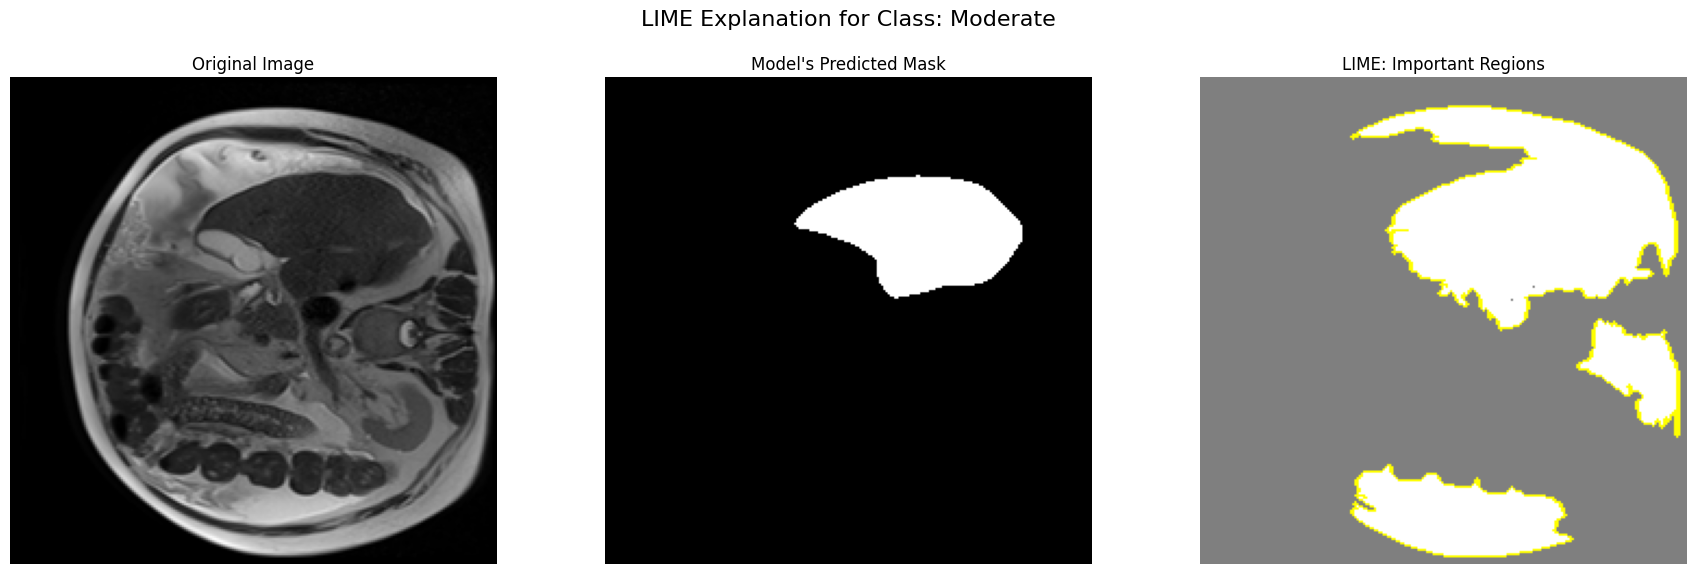


Explaining a sample for class: 'Mild'...


  0%|          | 0/1000 [00:00<?, ?it/s]

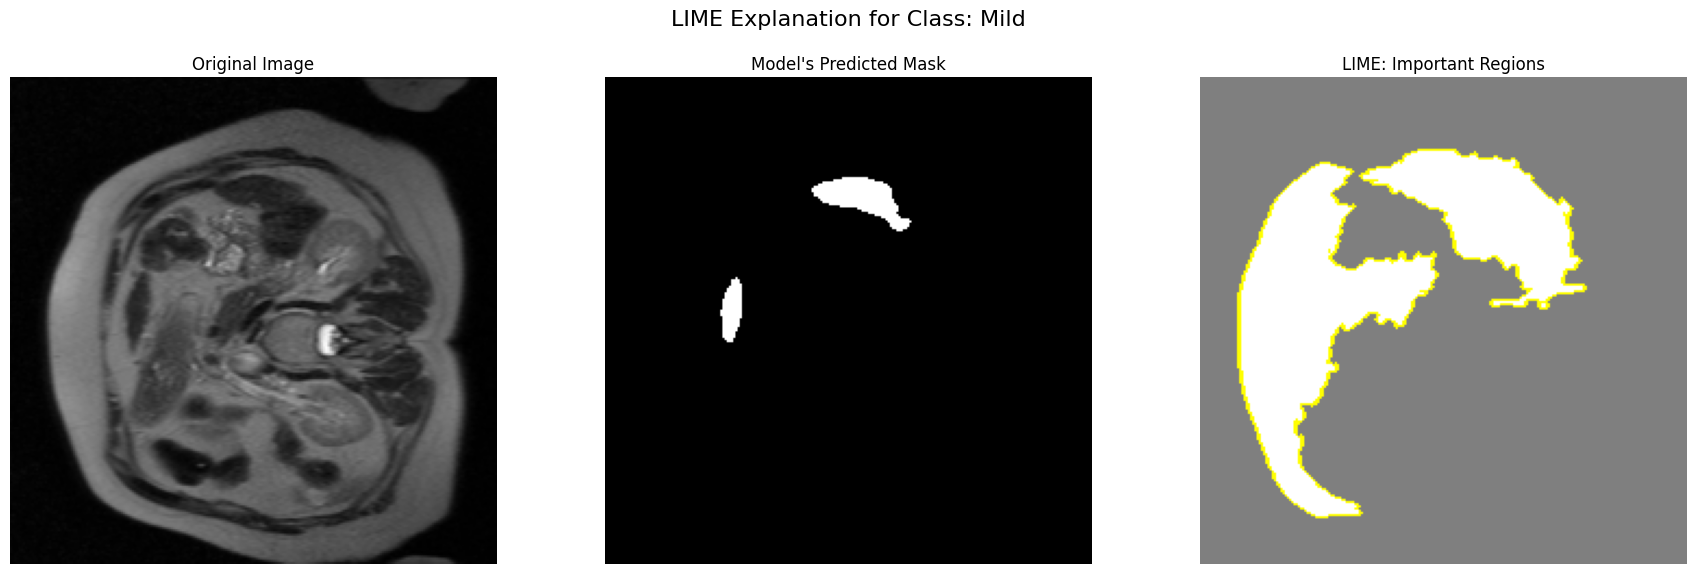


Explaining a sample for class: 'Severe'...


  0%|          | 0/1000 [00:00<?, ?it/s]

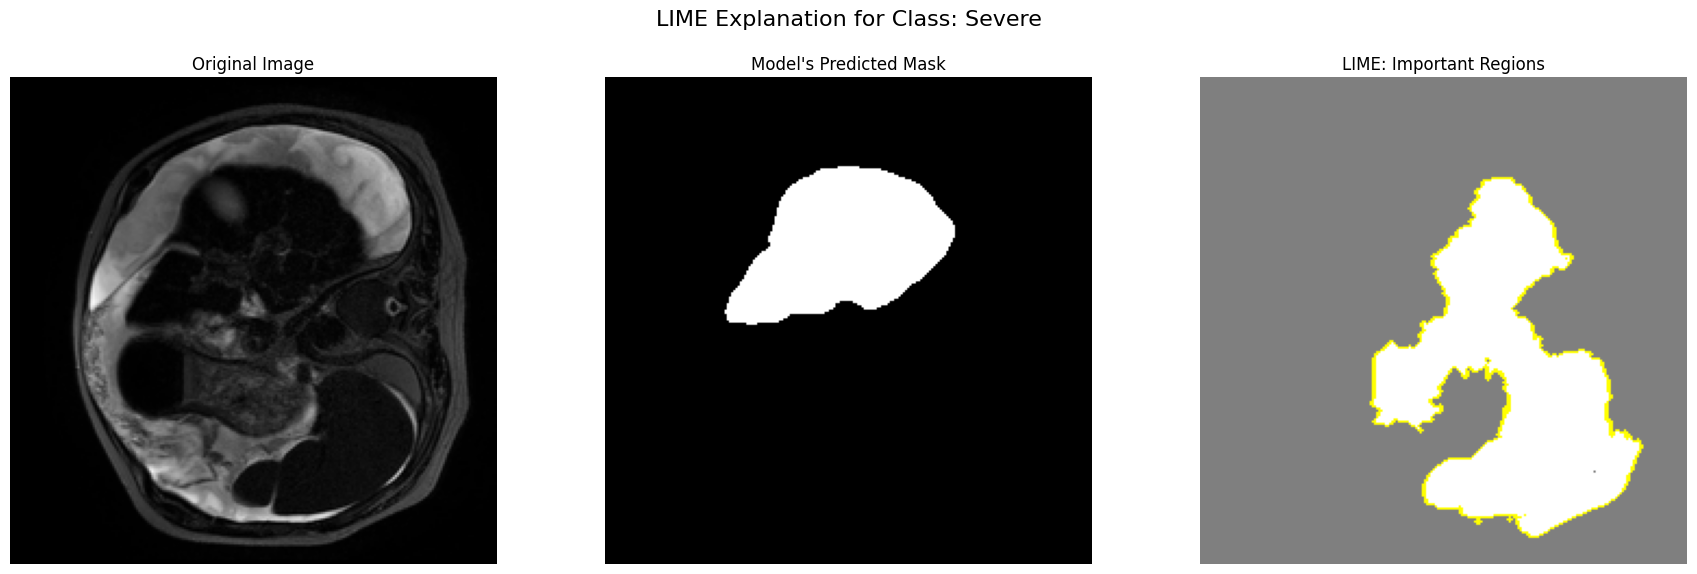

In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F_T
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
from PIL import Image

# --- Imports for LIME ---
try:
    import lime
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
except ImportError:
    print("LIME or scikit-image not found. Please install using: pip install lime scikit-image")
    lime = None


# --- Set Seeds for Reproducibility ---
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set CUDA_LAUNCH_BLOCKING for easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- Data Loading and Preparation ---
try:
    metadata_df = pd.read_csv('/kaggle/input/t2metadata/T2_age_gender_evaluation.csv')
    print("Successfully loaded metadata CSV.")
except FileNotFoundError:
    print("Error: 'T2_age_gender_evaluation.csv' not found.")
    metadata_df = pd.DataFrame()

if not metadata_df.empty:
    # --- CORRECTED CLASS MAPPING SECTION ---
    # Rename columns for consistency
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)

    # Define the correct, stable mapping from radiological score to class name and label
    # 1 -> Mild (label 0)
    # 2 -> Moderate (label 1)
    # 3 -> Severe (label 2)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_label_map = {1: 0, 2: 1, 3: 2}

    # Apply the mappings to create the new columns
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)

    # Final class map for evaluation and visualization
    class_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

    print("\n--- Classification Task Setup ---")
    print("Corrected Class Mapping for Evaluation:", class_map)

    metadata_df['ID'] = metadata_df['ID'].astype(str)
    valid_ids = set(metadata_df['ID'].tolist())
    # --- END OF CORRECTION ---
else:
    valid_ids = set()
    class_map = {}


def create_dataframe_from_ids(directory, allowed_ids):
    data = []
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' not found. Skipping.")
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])
    for folder_name in os.listdir(directory):
        if folder_name in allowed_ids:
            folder_path = os.path.join(directory, folder_name)
            images_dir = os.path.join(folder_path, 'images')
            masks_dir = os.path.join(folder_path, 'masks')
            if os.path.exists(images_dir) and os.path.exists(masks_dir):
                for image_file in os.listdir(images_dir):
                    image_path = os.path.join(images_dir, image_file)
                    mask_path = os.path.join(masks_dir, image_file)
                    if os.path.exists(mask_path):
                        data.append((folder_name, image_path, mask_path))
    return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

train_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
valid_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
test_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

train_df = pd.merge(create_dataframe_from_ids(train_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()
val_df = pd.merge(create_dataframe_from_ids(valid_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()
test_df = pd.merge(create_dataframe_from_ids(test_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()


print(f"\nTraining samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

# --- Dataset and Transforms ---
class SegmentationTransform:
    def __init__(self, image_size=(224, 224), is_train=True):
        self.image_size = image_size
        self.is_train = is_train
    def __call__(self, image, mask):
        image = F_T.resize(image, self.image_size, interpolation=F_T.InterpolationMode.BILINEAR)
        mask = F_T.resize(mask, self.image_size, interpolation=F_T.InterpolationMode.NEAREST)
        if self.is_train:
            if random.random() > 0.5: image, mask = F_T.hflip(image), F_T.hflip(mask)
            if random.random() > 0.5: image, mask = F_T.vflip(image), F_T.vflip(mask)
            angle = random.uniform(-15, 15)
            image, mask = F_T.rotate(image, angle), F_T.rotate(mask, angle)
        image = F_T.to_tensor(image)
        mask = F_T.to_tensor(mask)
        image = F_T.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask = (mask > 0).float()
        return image, mask

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['image_file_path']).convert('RGB')
        mask = Image.open(row['mask_file_path']).convert('L')
        class_label = row.get('class_label')
        if class_label is None or pd.isna(class_label):
            raise ValueError(f"Missing or NaN class_label for row {idx} with ID {row['ID']}")
        class_label_tensor = torch.tensor(int(class_label), dtype=torch.long)
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask, class_label_tensor

# --- U²-Net Model with VGG16-style Encoder ---
def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

class RSU7(nn.Module): # ReSidual U-block
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.conv_in = conv_block(in_ch, out_ch)
        self.e1 = conv_block(out_ch, mid_ch)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.e2 = conv_block(mid_ch, mid_ch)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.e3 = conv_block(mid_ch, mid_ch)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.e4 = conv_block(mid_ch, mid_ch)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.e5 = conv_block(mid_ch, mid_ch)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.e6 = conv_block(mid_ch, mid_ch)
        self.e7 = conv_block(mid_ch, mid_ch) # Bottleneck
        self.d6 = conv_block(mid_ch * 2, mid_ch)
        self.d5 = conv_block(mid_ch * 2, mid_ch)
        self.d4 = conv_block(mid_ch * 2, mid_ch)
        self.d3 = conv_block(mid_ch * 2, mid_ch)
        self.d2 = conv_block(mid_ch * 2, mid_ch)
        self.d1 = conv_block(mid_ch * 2, out_ch)

    def forward(self, x):
        xi = self.conv_in(x)
        e1 = self.e1(xi)
        e2 = self.e2(self.pool1(e1))
        e3 = self.e3(self.pool2(e2))
        e4 = self.e4(self.pool3(e3))
        e5 = self.e5(self.pool4(e4))
        e6 = self.e6(self.pool5(e5))
        e7 = self.e7(e6)
        
        d6 = self.d6(torch.cat((e7, e6), 1))
        d5 = self.d5(torch.cat((F.interpolate(d6, size=e5.size()[2:], mode='bilinear', align_corners=True), e5), 1))
        d4 = self.d4(torch.cat((F.interpolate(d5, size=e4.size()[2:], mode='bilinear', align_corners=True), e4), 1))
        d3 = self.d3(torch.cat((F.interpolate(d4, size=e3.size()[2:], mode='bilinear', align_corners=True), e3), 1))
        d2 = self.d2(torch.cat((F.interpolate(d3, size=e2.size()[2:], mode='bilinear', align_corners=True), e2), 1))
        d1 = self.d1(torch.cat((F.interpolate(d2, size=e1.size()[2:], mode='bilinear', align_corners=True), e1), 1))
        return d1 + xi

class RSU4F(nn.Module): # RSU for deeper layers
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.conv_in = conv_block(in_ch, out_ch)
        self.e1 = conv_block(out_ch, mid_ch)
        self.e2 = conv_block(mid_ch, mid_ch)
        self.e3 = conv_block(mid_ch, mid_ch)
        self.e4 = conv_block(mid_ch, mid_ch) # Bottleneck
        self.d3 = conv_block(mid_ch * 2, mid_ch)
        self.d2 = conv_block(mid_ch * 2, mid_ch)
        self.d1 = conv_block(mid_ch * 2, out_ch)

    def forward(self, x):
        xi = self.conv_in(x)
        e1 = self.e1(xi)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)
        d3 = self.d3(torch.cat((e4, e3), 1))
        d2 = self.d2(torch.cat((d3, e2), 1))
        d1 = self.d1(torch.cat((d2, e1), 1))
        return d1 + xi

class U2Net_VGG16(nn.Module):
    def __init__(self, in_channels=3, n_classes=1):
        super().__init__()
        
        # Encoder (VGG16-style: 64, 128, 256, 512, 512)
        self.stage1 = RSU7(in_channels, 32, 64)
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.stage2 = RSU7(64, 32, 128)
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.stage3 = RSU7(128, 64, 256)
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.stage4 = RSU4F(256, 128, 512)
        self.pool4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.stage5 = RSU4F(512, 256, 512)
        self.pool5 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.stage6 = RSU4F(512, 256, 512) # Bottleneck

        # Decoder
        self.stage5d = RSU4F(1024, 256, 512)
        self.stage4d = RSU4F(1024, 128, 256)
        self.stage3d = RSU7(512, 64, 128)
        self.stage2d = RSU7(256, 32, 64)
        self.stage1d = RSU7(128, 16, 64)

        # Side output layers for deep supervision
        self.side1 = nn.Conv2d(64, n_classes, 3, padding=1)
        self.side2 = nn.Conv2d(64, n_classes, 3, padding=1)
        self.side3 = nn.Conv2d(128, n_classes, 3, padding=1)
        self.side4 = nn.Conv2d(256, n_classes, 3, padding=1)
        self.side5 = nn.Conv2d(512, n_classes, 3, padding=1)
        self.side6 = nn.Conv2d(512, n_classes, 3, padding=1)
        self.outconv = nn.Conv2d(6 * n_classes, n_classes, 1)

    def forward(self, x):
        # Encoder
        hx1 = self.stage1(x)
        hx = self.pool1(hx1)
        hx2 = self.stage2(hx)
        hx = self.pool2(hx2)
        hx3 = self.stage3(hx)
        hx = self.pool3(hx3)
        hx4 = self.stage4(hx)
        hx = self.pool4(hx4)
        hx5 = self.stage5(hx)
        hx = self.pool5(hx5)
        hx6 = self.stage6(hx)
        
        hx6up = F.interpolate(hx6, size=hx5.size()[2:], mode='bilinear', align_corners=True)
        
        # Decoder
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = F.interpolate(hx5d, size=hx4.size()[2:], mode='bilinear', align_corners=True)
        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = F.interpolate(hx4d, size=hx3.size()[2:], mode='bilinear', align_corners=True)
        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = F.interpolate(hx3d, size=hx2.size()[2:], mode='bilinear', align_corners=True)
        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = F.interpolate(hx2d, size=hx1.size()[2:], mode='bilinear', align_corners=True)
        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # Side outputs
        d1 = self.side1(hx1d)
        d2 = self.side2(hx2d)
        d3 = self.side3(hx3d)
        d4 = self.side4(hx4d)
        d5 = self.side5(hx5d)
        d6 = self.side6(hx6)
        
        d1 = F.interpolate(d1, size=x.size()[2:], mode='bilinear', align_corners=True)
        d2 = F.interpolate(d2, size=x.size()[2:], mode='bilinear', align_corners=True)
        d3 = F.interpolate(d3, size=x.size()[2:], mode='bilinear', align_corners=True)
        d4 = F.interpolate(d4, size=x.size()[2:], mode='bilinear', align_corners=True)
        d5 = F.interpolate(d5, size=x.size()[2:], mode='bilinear', align_corners=True)
        d6 = F.interpolate(d6, size=x.size()[2:], mode='bilinear', align_corners=True)

        # Fusion
        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))
        
        return [d0, d1, d2, d3, d4, d5, d6]

# --- Loss, Metrics, and Training Functions ---
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat, targets_flat = inputs_sig.view(-1), targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        return bce + dice_loss

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss, total_dice, total_iou = 0.0, 0.0, 0.0
    for images, masks, _ in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        # Sum loss over all U²-Net outputs (deep supervision)
        loss = sum(loss_fn(o, masks) for o in outputs)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
        # Metrics are calculated on the final fused output (outputs[0])
        dice, iou = calculate_metrics(outputs[0], masks)
        total_dice += dice * images.size(0)
        total_iou += iou * images.size(0)
    return (running_loss / len(loader.dataset),
            total_dice / len(loader.dataset),
            total_iou / len(loader.dataset))

def evaluate_model(loader, model, loss_fn, device, class_mapping, dataset_name="Validation"):
    model.eval()
    all_preds, all_masks, all_labels = [], [], []
    running_loss = 0.0
    with torch.no_grad():
        for images, masks, labels in tqdm(loader, desc=f"Evaluating on {dataset_name}"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            # Sum loss over all outputs but use only the final one for metrics
            loss = sum(loss_fn(o, masks) for o in outputs)
            running_loss += loss.item() * images.size(0)
            
            # Append only the final fused output (outputs[0]) for metrics
            all_preds.append(outputs[0].cpu())
            all_masks.append(masks.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds)
    all_masks = torch.cat(all_masks)
    all_labels = torch.cat(all_labels)
    
    avg_loss = running_loss / len(loader.dataset)
    overall_dice, overall_iou = calculate_metrics(all_preds, all_masks)
    print(f"\n--- {dataset_name} Report ---")
    print(f"Overall -> Loss: {avg_loss:.4f}, Dice: {overall_dice:.4f}, mIoU: {overall_iou:.4f}")
    
    print("--- Per-Class Metrics ---")
    for class_idx, class_name in class_mapping.items():
        indices = (all_labels == class_idx).nonzero(as_tuple=True)[0]
        if len(indices) > 0:
            class_dice, class_iou = calculate_metrics(all_preds[indices], all_masks[indices])
            print(f"Class '{class_name}' ({len(indices)} samples) -> Dice: {class_dice:.4f}, mIoU: {class_iou:.4f}")
    return avg_loss, overall_dice

# --- FULL TRAINING LOOP ---
if not train_df.empty and not val_df.empty:
    train_dataset = LiverDataset(train_df, transform=SegmentationTransform(is_train=True))
    val_dataset = LiverDataset(val_df, transform=SegmentationTransform(is_train=False))
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    model = U2Net_VGG16(in_channels=3, n_classes=1).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = DiceBCELoss()
    num_epochs = 20
    best_val_dice = 0.0

    print("\n--- Starting Model Training with U²-Net (VGG16-Style Encoder) ---")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_dice, _ = train_one_epoch(train_loader, model, optimizer, criterion, device)
        print(f"Training -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        
        val_loss, val_dice = evaluate_model(val_loader, model, criterion, device, class_map)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_u2net_vgg16_model.pth')
            print(f"✅ Model Saved! New Best Dice: {best_val_dice:.4f}")
else:
    print("🛑 Training or validation dataset is empty. Cannot start training.")
    model = None

# --- LIME EXPLANATION SECTION ---
if model and lime:
    print("\n--- Loading Best Model for LIME Explanation ---")
    try:
        model.load_state_dict(torch.load('best_u2net_vgg16_model.pth', map_location=device))
        print("Best U²-Net model weights loaded successfully for LIME.")
    except FileNotFoundError:
        print("Model file 'best_u2net_vgg16_model.pth' not found. Cannot perform LIME explanation.")
        model = None

def get_pil_transform():
    return transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_preprocess_transform():
    return transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def batch_predict(images):
    """Prediction function for LIME, adapted for U²-Net."""
    model.eval()
    batch = torch.stack([get_preprocess_transform()(image) for image in images], dim=0).to(device).float()
    with torch.no_grad():
        logits = model(batch)[0]
    probs = torch.sigmoid(logits)
    segmentation_confidence = probs.sum(dim=[1, 2, 3])
    return torch.stack([1 - segmentation_confidence, segmentation_confidence], dim=1).cpu().numpy()

def generate_lime_explanation(dataset, model, class_mapping):
    if model is None or len(dataset) == 0 or lime is None:
        print("Skipping LIME: model, dataset, or LIME library not available.")
        return

    print("\n--- Generating LIME Explanations for Each Class ---")
    explainer = lime_image.LimeImageExplainer()
    test_df_viz = dataset.dataframe.drop_duplicates(subset=['class_label'])

    for _, row in test_df_viz.iterrows():
        class_name = row['class_name']
        image_path = row['image_file_path']
        original_image = Image.open(image_path).convert('RGB').resize((224, 224))
        
        print(f"\nExplaining a sample for class: '{class_name}'...")
        explanation = explainer.explain_instance(np.array(original_image), batch_predict, top_labels=1, hide_color=0, num_samples=1000)
        
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
        
        img_tensor = get_pil_transform()(original_image).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mask_tensor = (torch.sigmoid(model(img_tensor)[0]) > 0.5).float().cpu().squeeze(0)
            # Ensure the mask is in the correct shape for imshow (H, W) or (H, W, C)
            if pred_mask_tensor.shape[0] == 1: # Grayscale
                 pred_mask = pred_mask_tensor.squeeze(0)
            else: # RGB, etc.
                 pred_mask = pred_mask_tensor.permute(1, 2, 0)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"LIME Explanation for Class: {class_name}", fontsize=16)
        axes[0].imshow(original_image); axes[0].set_title("Original Image"); axes[0].axis('off')
        axes[1].imshow(pred_mask, cmap='gray'); axes[1].set_title("Model's Predicted Mask"); axes[1].axis('off')
        axes[2].imshow(mark_boundaries(temp / 2 + 0.5, mask)); axes[2].set_title("LIME: Important Regions"); axes[2].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# Run LIME on the test dataset if the model was trained
if model and not test_df.empty:
    test_dataset = LiverDataset(test_df, transform=None)
    generate_lime_explanation(test_dataset, model, class_map)

Using device: cuda ⚙️
Successfully loaded metadata CSV.

--- Classification Task Setup ---
Corrected Class Mapping for Evaluation: {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

Training samples: 5364, Validation samples: 674, Test samples: 664


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 172MB/s]  



--- Starting Model Training with SynergyNet (InceptionV3 Encoder) ---

Epoch 1/20


Training: 100%|██████████| 671/671 [04:17<00:00,  2.61it/s]


Training -> Loss: 1.6883, Dice: 0.7995


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.32it/s]



--- Validation Report ---
Overall -> Loss: 1.2777, Dice: 0.9066, mIoU: 0.8291
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9212, mIoU: 0.8540
Class 'Moderate' (189 samples) -> Dice: 0.9142, mIoU: 0.8419
Class 'Severe' (176 samples) -> Dice: 0.8559, mIoU: 0.7481
✅ Model Saved! New Best Dice: 0.9066

Epoch 2/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.63it/s]


Training -> Loss: 1.1409, Dice: 0.8965


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]



--- Validation Report ---
Overall -> Loss: 1.0206, Dice: 0.9138, mIoU: 0.8412
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9163, mIoU: 0.8455
Class 'Moderate' (189 samples) -> Dice: 0.9277, mIoU: 0.8651
Class 'Severe' (176 samples) -> Dice: 0.8833, mIoU: 0.7911
✅ Model Saved! New Best Dice: 0.9138

Epoch 3/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.63it/s]


Training -> Loss: 0.9520, Dice: 0.9211


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.20it/s]



--- Validation Report ---
Overall -> Loss: 0.9010, Dice: 0.9316, mIoU: 0.8719
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9293, mIoU: 0.8679
Class 'Moderate' (189 samples) -> Dice: 0.9466, mIoU: 0.8986
Class 'Severe' (176 samples) -> Dice: 0.9109, mIoU: 0.8363
✅ Model Saved! New Best Dice: 0.9316

Epoch 4/20


Training: 100%|██████████| 671/671 [04:16<00:00,  2.62it/s]


Training -> Loss: 0.8895, Dice: 0.9315


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.20it/s]



--- Validation Report ---
Overall -> Loss: 0.8902, Dice: 0.9292, mIoU: 0.8677
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9241, mIoU: 0.8589
Class 'Moderate' (189 samples) -> Dice: 0.9430, mIoU: 0.8922
Class 'Severe' (176 samples) -> Dice: 0.9176, mIoU: 0.8478

Epoch 5/20


Training: 100%|██████████| 671/671 [04:16<00:00,  2.62it/s]


Training -> Loss: 0.8624, Dice: 0.9361


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.18it/s]



--- Validation Report ---
Overall -> Loss: 0.8671, Dice: 0.9305, mIoU: 0.8700
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9355, mIoU: 0.8787
Class 'Moderate' (189 samples) -> Dice: 0.9453, mIoU: 0.8962
Class 'Severe' (176 samples) -> Dice: 0.8925, mIoU: 0.8059

Epoch 6/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.63it/s]


Training -> Loss: 0.8555, Dice: 0.9353


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]



--- Validation Report ---
Overall -> Loss: 0.8769, Dice: 0.9264, mIoU: 0.8630
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9224, mIoU: 0.8560
Class 'Moderate' (189 samples) -> Dice: 0.9412, mIoU: 0.8890
Class 'Severe' (176 samples) -> Dice: 0.9106, mIoU: 0.8358

Epoch 7/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.62it/s]


Training -> Loss: 0.8307, Dice: 0.9437


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.26it/s]



--- Validation Report ---
Overall -> Loss: 0.8424, Dice: 0.9385, mIoU: 0.8842
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9468, mIoU: 0.8989
Class 'Moderate' (189 samples) -> Dice: 0.9475, mIoU: 0.9003
Class 'Severe' (176 samples) -> Dice: 0.9013, mIoU: 0.8203
✅ Model Saved! New Best Dice: 0.9385

Epoch 8/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.63it/s]


Training -> Loss: 0.8227, Dice: 0.9453


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.26it/s]



--- Validation Report ---
Overall -> Loss: 0.8231, Dice: 0.9436, mIoU: 0.8933
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9446, mIoU: 0.8950
Class 'Moderate' (189 samples) -> Dice: 0.9548, mIoU: 0.9134
Class 'Severe' (176 samples) -> Dice: 0.9222, mIoU: 0.8557
✅ Model Saved! New Best Dice: 0.9436

Epoch 9/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.63it/s]


Training -> Loss: 0.8236, Dice: 0.9433


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.24it/s]



--- Validation Report ---
Overall -> Loss: 0.8495, Dice: 0.9349, mIoU: 0.8777
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9295, mIoU: 0.8683
Class 'Moderate' (189 samples) -> Dice: 0.9539, mIoU: 0.9118
Class 'Severe' (176 samples) -> Dice: 0.9152, mIoU: 0.8437

Epoch 10/20


Training: 100%|██████████| 671/671 [04:16<00:00,  2.62it/s]


Training -> Loss: 0.8087, Dice: 0.9489


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.21it/s]



--- Validation Report ---
Overall -> Loss: 0.8051, Dice: 0.9466, mIoU: 0.8986
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9525, mIoU: 0.9093
Class 'Moderate' (189 samples) -> Dice: 0.9508, mIoU: 0.9063
Class 'Severe' (176 samples) -> Dice: 0.9243, mIoU: 0.8593
✅ Model Saved! New Best Dice: 0.9466

Epoch 11/20


Training: 100%|██████████| 671/671 [04:16<00:00,  2.61it/s]


Training -> Loss: 0.8115, Dice: 0.9461


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.20it/s]



--- Validation Report ---
Overall -> Loss: 0.8034, Dice: 0.9479, mIoU: 0.9010
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9530, mIoU: 0.9102
Class 'Moderate' (189 samples) -> Dice: 0.9509, mIoU: 0.9063
Class 'Severe' (176 samples) -> Dice: 0.9305, mIoU: 0.8700
✅ Model Saved! New Best Dice: 0.9479

Epoch 12/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.62it/s]


Training -> Loss: 0.7990, Dice: 0.9507


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.25it/s]



--- Validation Report ---
Overall -> Loss: 0.8306, Dice: 0.9378, mIoU: 0.8829
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9371, mIoU: 0.8816
Class 'Moderate' (189 samples) -> Dice: 0.9455, mIoU: 0.8966
Class 'Severe' (176 samples) -> Dice: 0.9266, mIoU: 0.8632

Epoch 13/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.62it/s]


Training -> Loss: 0.7988, Dice: 0.9505


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]



--- Validation Report ---
Overall -> Loss: 0.7948, Dice: 0.9509, mIoU: 0.9065
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9565, mIoU: 0.9166
Class 'Moderate' (189 samples) -> Dice: 0.9524, mIoU: 0.9091
Class 'Severe' (176 samples) -> Dice: 0.9346, mIoU: 0.8772
✅ Model Saved! New Best Dice: 0.9509

Epoch 14/20


Training: 100%|██████████| 671/671 [04:14<00:00,  2.63it/s]


Training -> Loss: 0.7883, Dice: 0.9541


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.24it/s]



--- Validation Report ---
Overall -> Loss: 0.8077, Dice: 0.9449, mIoU: 0.8956
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9436, mIoU: 0.8933
Class 'Moderate' (189 samples) -> Dice: 0.9527, mIoU: 0.9096
Class 'Severe' (176 samples) -> Dice: 0.9350, mIoU: 0.8779

Epoch 15/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.63it/s]


Training -> Loss: 0.7953, Dice: 0.9500


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]



--- Validation Report ---
Overall -> Loss: 0.8027, Dice: 0.9485, mIoU: 0.9020
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9547, mIoU: 0.9134
Class 'Moderate' (189 samples) -> Dice: 0.9521, mIoU: 0.9086
Class 'Severe' (176 samples) -> Dice: 0.9266, mIoU: 0.8633

Epoch 16/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.62it/s]


Training -> Loss: 0.7915, Dice: 0.9511


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.24it/s]



--- Validation Report ---
Overall -> Loss: 0.7872, Dice: 0.9531, mIoU: 0.9103
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9605, mIoU: 0.9241
Class 'Moderate' (189 samples) -> Dice: 0.9520, mIoU: 0.9084
Class 'Severe' (176 samples) -> Dice: 0.9362, mIoU: 0.8801
✅ Model Saved! New Best Dice: 0.9531

Epoch 17/20


Training: 100%|██████████| 671/671 [04:14<00:00,  2.63it/s]


Training -> Loss: 0.7843, Dice: 0.9534


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]



--- Validation Report ---
Overall -> Loss: 0.8265, Dice: 0.9371, mIoU: 0.8817
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9329, mIoU: 0.8742
Class 'Moderate' (189 samples) -> Dice: 0.9538, mIoU: 0.9118
Class 'Severe' (176 samples) -> Dice: 0.9184, mIoU: 0.8492

Epoch 18/20


Training: 100%|██████████| 671/671 [04:14<00:00,  2.63it/s]


Training -> Loss: 0.7740, Dice: 0.9568


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.25it/s]



--- Validation Report ---
Overall -> Loss: 0.7936, Dice: 0.9502, mIoU: 0.9052
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9539, mIoU: 0.9119
Class 'Moderate' (189 samples) -> Dice: 0.9542, mIoU: 0.9124
Class 'Severe' (176 samples) -> Dice: 0.9345, mIoU: 0.8770

Epoch 19/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.62it/s]


Training -> Loss: 0.7751, Dice: 0.9561


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]



--- Validation Report ---
Overall -> Loss: 0.8020, Dice: 0.9482, mIoU: 0.9015
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9529, mIoU: 0.9101
Class 'Moderate' (189 samples) -> Dice: 0.9497, mIoU: 0.9042
Class 'Severe' (176 samples) -> Dice: 0.9340, mIoU: 0.8761

Epoch 20/20


Training: 100%|██████████| 671/671 [04:15<00:00,  2.62it/s]


Training -> Loss: 0.7711, Dice: 0.9570


Evaluating on Validation: 100%|██████████| 85/85 [00:11<00:00,  7.22it/s]



--- Validation Report ---
Overall -> Loss: 0.7979, Dice: 0.9506, mIoU: 0.9059
--- Per-Class Metrics ---
Class 'Mild' (309 samples) -> Dice: 0.9589, mIoU: 0.9210
Class 'Moderate' (189 samples) -> Dice: 0.9508, mIoU: 0.9062
Class 'Severe' (176 samples) -> Dice: 0.9296, mIoU: 0.8685

--- Loading Best Model for LIME Explanation ---
Best SynergyNet model weights loaded successfully for LIME.

--- Generating LIME Explanations for Each Class ---

Explaining a sample for class: 'Moderate'...


  0%|          | 0/1000 [00:00<?, ?it/s]

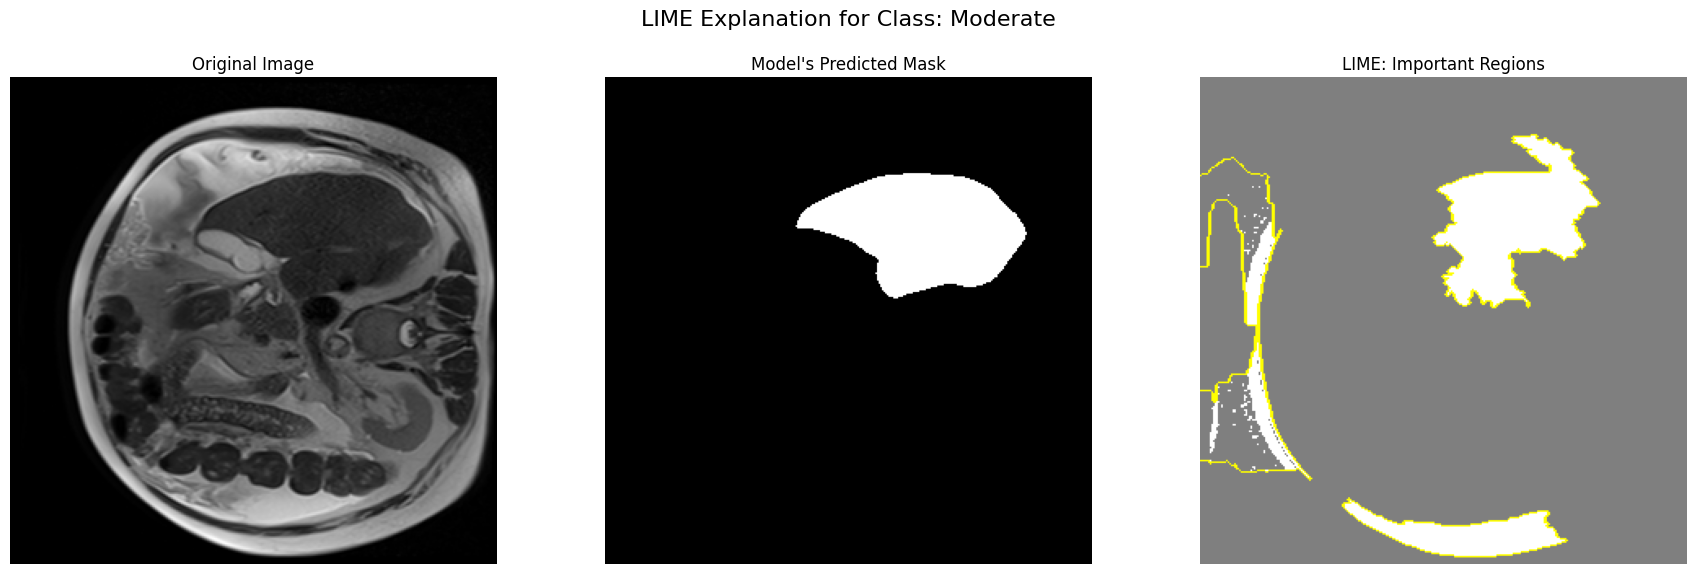


Explaining a sample for class: 'Mild'...


  0%|          | 0/1000 [00:00<?, ?it/s]

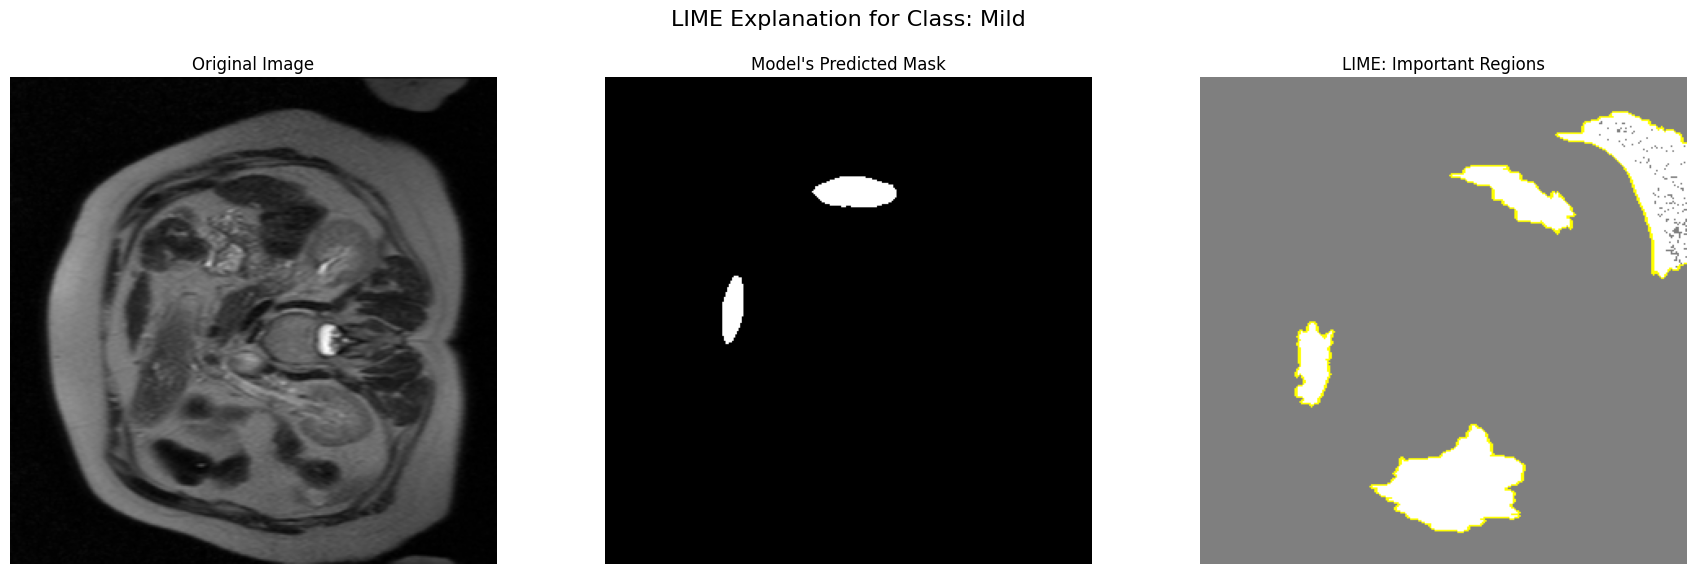


Explaining a sample for class: 'Severe'...


  0%|          | 0/1000 [00:00<?, ?it/s]

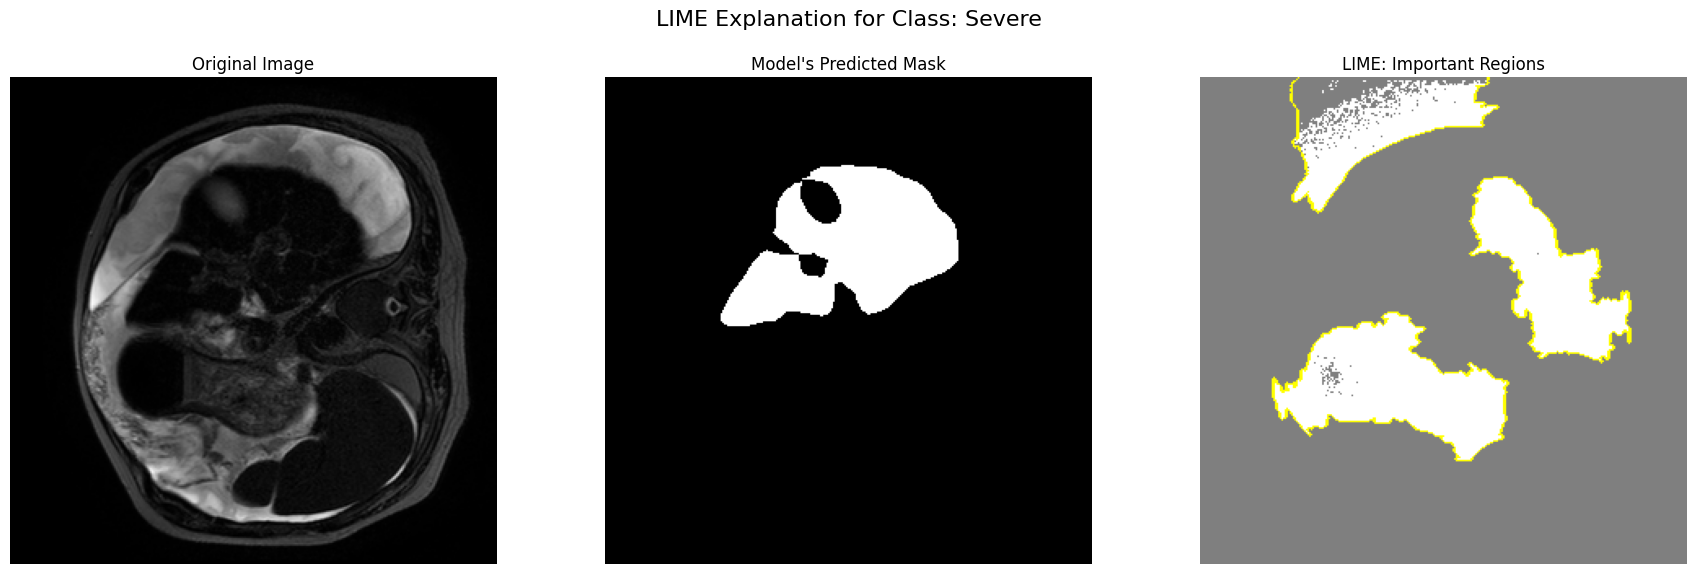

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torchvision.transforms.functional as F_T
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm import tqdm
from PIL import Image
from scipy.ndimage import binary_erosion

# --- Imports for LIME ---
try:
    import lime
    from lime import lime_image
    from skimage.segmentation import mark_boundaries
except ImportError:
    print("LIME or scikit-image not found. Please install using: pip install lime scikit-image")
    lime = None

# --- Set Seeds for Reproducibility ---
def set_seed(seed):
    """Sets the seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Set CUDA_LAUNCH_BLOCKING for easier debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} ⚙️")

# --- Data Loading and Preparation ---
try:
    metadata_df = pd.read_csv('/kaggle/input/t2metadata/T2_age_gender_evaluation.csv')
    print("Successfully loaded metadata CSV.")
except FileNotFoundError:
    print("Error: 'T2_age_gender_evaluation.csv' not found.")
    metadata_df = pd.DataFrame()

if not metadata_df.empty:
    # --- CORRECTED CLASS MAPPING SECTION ---
    # Rename columns for consistency
    metadata_df.rename(columns={'Patient ID': 'ID', 'Radiological Evaluation': 'radiological_evaluation'}, inplace=True)
    metadata_df.dropna(subset=['radiological_evaluation'], inplace=True)
    metadata_df['radiological_evaluation'] = metadata_df['radiological_evaluation'].astype(int)

    # Define the correct, stable mapping from radiological score to class name and label
    # 1 -> Mild (label 0)
    # 2 -> Moderate (label 1)
    # 3 -> Severe (label 2)
    class_name_map = {1: 'Mild', 2: 'Moderate', 3: 'Severe'}
    class_label_map = {1: 0, 2: 1, 3: 2}

    # Apply the mappings to create the new columns
    metadata_df['class_name'] = metadata_df['radiological_evaluation'].map(class_name_map)
    metadata_df['class_label'] = metadata_df['radiological_evaluation'].map(class_label_map)

    # Final class map for evaluation and visualization
    class_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'}

    print("\n--- Classification Task Setup ---")
    print("Corrected Class Mapping for Evaluation:", class_map)

    metadata_df['ID'] = metadata_df['ID'].astype(str)
    valid_ids = set(metadata_df['ID'].tolist())
    # --- END OF CORRECTION ---
else:
    valid_ids = set()
    class_map = {}


def create_dataframe_from_ids(directory, allowed_ids):
    data = []
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' not found. Skipping.")
        return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])
    for folder_name in os.listdir(directory):
        if folder_name in allowed_ids:
            folder_path = os.path.join(directory, folder_name)
            images_dir = os.path.join(folder_path, 'images')
            masks_dir = os.path.join(folder_path, 'masks')
            if os.path.exists(images_dir) and os.path.exists(masks_dir):
                for image_file in os.listdir(images_dir):
                    image_path = os.path.join(images_dir, image_file)
                    mask_path = os.path.join(masks_dir, image_file)
                    if os.path.exists(mask_path):
                        data.append((folder_name, image_path, mask_path))
    return pd.DataFrame(data, columns=['ID', 'image_file_path', 'mask_file_path'])

train_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/train'
valid_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/valid'
test_dir = '/kaggle/input/datat2/Cirrhosis_T2_2D/test'

train_df = pd.merge(create_dataframe_from_ids(train_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()
val_df = pd.merge(create_dataframe_from_ids(valid_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()
test_df = pd.merge(create_dataframe_from_ids(test_dir, valid_ids), metadata_df, on='ID') if not metadata_df.empty else pd.DataFrame()


print(f"\nTraining samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")

# --- Dataset and Transforms ---
class SegmentationTransform:
    def __init__(self, image_size=(299, 299), is_train=True): # Changed for InceptionV3
        self.image_size = image_size
        self.is_train = is_train
    def __call__(self, image, mask):
        image = F_T.resize(image, self.image_size, interpolation=F_T.InterpolationMode.BILINEAR)
        mask = F_T.resize(mask, self.image_size, interpolation=F_T.InterpolationMode.NEAREST)
        if self.is_train:
            if random.random() > 0.5: image, mask = F_T.hflip(image), F_T.hflip(mask)
            if random.random() > 0.5: image, mask = F_T.vflip(image), F_T.vflip(mask)
            angle = random.uniform(-15, 15)
            image, mask = F_T.rotate(image, angle), F_T.rotate(mask, angle)
        image = F_T.to_tensor(image)
        mask = F_T.to_tensor(mask)
        image = F_T.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask = (mask > 0).float()
        return image, mask

class LiverDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_pil = Image.open(row['image_file_path']).convert('RGB')
        mask_pil = Image.open(row['mask_file_path']).convert('L')
        
        class_label = row.get('class_label')
        if class_label is None or pd.isna(class_label):
            raise ValueError(f"Missing or NaN class_label for row {idx} with ID {row['ID']}")
        class_label_tensor = torch.tensor(int(class_label), dtype=torch.long)
        
        if self.transform:
            image, mask = self.transform(image_pil, mask_pil)
        else:
            # Basic transformation if none is provided (e.g., for LIME)
            # This part is mainly for making the dataset runnable without a transform,
            # though LIME itself doesn't iterate through __getitem__.
            temp_transform = SegmentationTransform(is_train=False)
            image, mask = temp_transform(image_pil, mask_pil)

        # Generate boundary mask from the main mask
        mask_numpy = mask.squeeze().cpu().numpy() > 0.5 # Ensure boolean
        eroded_mask = binary_erosion(mask_numpy, iterations=1)
        boundary = torch.from_numpy(mask_numpy ^ eroded_mask).unsqueeze(0).float() # XOR for cleaner boundary
        
        return image, mask, boundary, class_label_tensor


# --- SynergyNet Model with InceptionV3 Encoder ---
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels + skip_channels, out_channels)
    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class FeatureSynergyModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.synergy_conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, f_main, f_aux):
        f_cat = torch.cat([f_main, f_aux], dim=1)
        f_syn = self.synergy_conv(f_cat)
        f_main_out = f_main + f_syn
        f_aux_out = f_aux + f_syn
        return f_main_out, f_aux_out

class SynergyNetInceptionV3(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        
        # Encoder stages
        self.enc0 = nn.Sequential(inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, inception.Conv2d_2b_3x3, nn.MaxPool2d(kernel_size=3, stride=2))
        self.enc1 = nn.Sequential(inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3, nn.MaxPool2d(kernel_size=3, stride=2))
        self.enc2 = nn.Sequential(inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d)
        self.enc3 = nn.Sequential(inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c, inception.Mixed_6d, inception.Mixed_6e)
        self.bottleneck = nn.Sequential(inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c)
        
        # Decoder for Main Mask
        self.dec_main3 = DecoderBlock(2048, 768, 512)
        self.dec_main2 = DecoderBlock(512, 288, 256)
        self.dec_main1 = DecoderBlock(256, 192, 128)
        self.dec_main0 = DecoderBlock(128, 64, 64)
        # Decoder for Auxiliary Boundary
        self.dec_aux3 = DecoderBlock(2048, 768, 512)
        self.dec_aux2 = DecoderBlock(512, 288, 256)
        self.dec_aux1 = DecoderBlock(256, 192, 128)
        self.dec_aux0 = DecoderBlock(128, 64, 64)
        # Feature Synergy Modules
        self.fsm2 = FeatureSynergyModule(256)
        self.fsm1 = FeatureSynergyModule(128)
        self.fsm0 = FeatureSynergyModule(64)
        
        # Output layers
        self.out_main = nn.Conv2d(64, n_classes, kernel_size=1)
        self.out_aux = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e0 = self.enc0(x)
        e1 = self.enc1(e0)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        b = self.bottleneck(e3)
        
        # Decoder
        d_main3 = self.dec_main3(b, e3)
        d_aux3 = self.dec_aux3(b, e3)
        
        d_main2 = self.dec_main2(d_main3, e2)
        d_aux2 = self.dec_aux2(d_aux3, e2)
        d_main2, d_aux2 = self.fsm2(d_main2, d_aux2)
        
        d_main1 = self.dec_main1(d_main2, e1)
        d_aux1 = self.dec_aux1(d_aux2, e1)
        d_main1, d_aux1 = self.fsm1(d_main1, d_aux1)
        
        d_main0 = self.dec_main0(d_main1, e0)
        d_aux0 = self.dec_aux0(d_aux1, e0)
        d_main0, d_aux0 = self.fsm0(d_main0, d_aux0)
        
        out_main_features = F.interpolate(d_main0, size=x.shape[2:], mode='bilinear', align_corners=True)
        out_aux_features = F.interpolate(d_aux0, size=x.shape[2:], mode='bilinear', align_corners=True)
        
        return self.out_main(out_main_features), self.out_aux(out_aux_features)

# --- Loss, Metrics, and Training Functions ---
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        inputs_sig = torch.sigmoid(inputs)
        inputs_flat, targets_flat = inputs_sig.view(-1), targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        return bce + dice_loss

def calculate_metrics(preds, targets, smooth=1e-6):
    preds_sig = torch.sigmoid(preds)
    preds_bin = (preds_sig > 0.5).float()
    preds_flat, targets_flat = preds_bin.view(-1), targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    total = preds_flat.sum() + targets_flat.sum()
    union = total - intersection
    dice = (2. * intersection + smooth) / (total + smooth)
    iou = (intersection + smooth) / (union + smooth)
    return dice.item(), iou.item()

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    running_loss, total_dice, total_iou = 0.0, 0.0, 0.0
    for images, masks, boundaries, _ in tqdm(loader, desc="Training"):
        images, masks, boundaries = images.to(device), masks.to(device), boundaries.to(device)
        
        optimizer.zero_grad()
        pred_masks, pred_boundaries = model(images)
        
        loss_mask = loss_fn(pred_masks, masks)
        loss_boundary = loss_fn(pred_boundaries, boundaries)
        loss = loss_mask + loss_boundary
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
        dice, iou = calculate_metrics(pred_masks, masks)
        total_dice += dice * images.size(0)
        total_iou += iou * images.size(0)
        
    return (running_loss / len(loader.dataset),
            total_dice / len(loader.dataset),
            total_iou / len(loader.dataset))

def evaluate_model(loader, model, loss_fn, device, class_mapping, dataset_name="Validation"):
    model.eval()
    all_preds, all_masks, all_labels = [], [], []
    running_loss = 0.0
    with torch.no_grad():
        for images, masks, boundaries, labels in tqdm(loader, desc=f"Evaluating on {dataset_name}"):
            images, masks, boundaries = images.to(device), masks.to(device), boundaries.to(device)
            pred_masks, pred_boundaries = model(images)
            
            loss_mask = loss_fn(pred_masks, masks)
            loss_boundary = loss_fn(pred_boundaries, boundaries)
            loss = loss_mask + loss_boundary
            running_loss += loss.item() * images.size(0)
            
            all_preds.append(pred_masks.cpu())
            all_masks.append(masks.cpu())
            all_labels.append(labels.cpu())
            
    all_preds = torch.cat(all_preds)
    all_masks = torch.cat(all_masks)
    all_labels = torch.cat(all_labels)
    
    avg_loss = running_loss / len(loader.dataset)
    overall_dice, overall_iou = calculate_metrics(all_preds, all_masks)
    print(f"\n--- {dataset_name} Report ---")
    print(f"Overall -> Loss: {avg_loss:.4f}, Dice: {overall_dice:.4f}, mIoU: {overall_iou:.4f}")
    
    print("--- Per-Class Metrics ---")
    for class_idx, class_name in class_mapping.items():
        indices = (all_labels == class_idx).nonzero(as_tuple=True)[0]
        if len(indices) > 0:
            class_dice, class_iou = calculate_metrics(all_preds[indices], all_masks[indices])
            print(f"Class '{class_name}' ({len(indices)} samples) -> Dice: {class_dice:.4f}, mIoU: {class_iou:.4f}")
    return avg_loss, overall_dice

# --- FULL TRAINING LOOP ---
if not train_df.empty and not val_df.empty:
    train_dataset = LiverDataset(train_df, transform=SegmentationTransform(is_train=True))
    val_dataset = LiverDataset(val_df, transform=SegmentationTransform(is_train=False))
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

    model = SynergyNetInceptionV3(n_classes=1).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = DiceBCELoss()
    num_epochs = 20
    best_val_dice = 0.0
    
    print("\n--- Starting Model Training with SynergyNet (InceptionV3 Encoder) ---")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_dice, _ = train_one_epoch(train_loader, model, optimizer, criterion, device)
        print(f"Training -> Loss: {train_loss:.4f}, Dice: {train_dice:.4f}")
        
        val_loss, val_dice = evaluate_model(val_loader, model, criterion, device, class_map)
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_synergynet_inceptionv3_model.pth')
            print(f"✅ Model Saved! New Best Dice: {best_val_dice:.4f}")
else:
    print("🛑 Training or validation dataset is empty. Cannot start training.")
    model = None

# --- LIME EXPLANATION SECTION ---
if model and not test_df.empty and lime:
    print("\n--- Loading Best Model for LIME Explanation ---")
    try:
        model.load_state_dict(torch.load('best_synergynet_inceptionv3_model.pth', map_location=device))
        print("Best SynergyNet model weights loaded successfully for LIME.")
    except FileNotFoundError:
        print("Model file 'best_synergynet_inceptionv3_model.pth' not found. Cannot perform LIME explanation.")
        model = None

def get_pil_transform():
    return transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def get_preprocess_transform():
    return transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def batch_predict(images):
    """Prediction function for LIME, adapted for SynergyNet."""
    model.eval()
    batch = torch.stack([get_preprocess_transform()(image) for image in images], dim=0).to(device).float()
    with torch.no_grad():
        logits, _ = model(batch)
    probs = torch.sigmoid(logits)
    segmentation_confidence = probs.sum(dim=[1, 2, 3])
    return torch.stack([1 - segmentation_confidence, segmentation_confidence], dim=1).cpu().numpy()

def generate_lime_explanation(dataframe, model, class_mapping):
    if model is None or dataframe.empty or lime is None:
        print("Skipping LIME: model, dataframe, or LIME library not available.")
        return
        
    print("\n--- Generating LIME Explanations for Each Class ---")
    explainer = lime_image.LimeImageExplainer()
    test_df_viz = dataframe.drop_duplicates(subset=['class_label'])
    
    for _, row in test_df_viz.iterrows():
        class_name = row['class_name']
        image_path = row['image_file_path']
        original_image = Image.open(image_path).convert('RGB').resize((299, 299))
        
        print(f"\nExplaining a sample for class: '{class_name}'...")
        explanation = explainer.explain_instance(np.array(original_image), batch_predict, top_labels=1, hide_color=0, num_samples=1000)
        
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
        
        img_tensor = get_pil_transform()(original_image).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mask_tensor, _ = model(img_tensor)
            pred_mask = (torch.sigmoid(pred_mask_tensor) > 0.5).float().cpu().squeeze(0).permute(1, 2, 0)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"LIME Explanation for Class: {class_name}", fontsize=16)
        axes[0].imshow(original_image); axes[0].set_title("Original Image"); axes[0].axis('off')
        axes[1].imshow(pred_mask, cmap='gray'); axes[1].set_title("Model's Predicted Mask"); axes[1].axis('off')
        axes[2].imshow(mark_boundaries(temp / 2 + 0.5, mask)); axes[2].set_title("LIME: Important Regions"); axes[2].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# Run LIME on the test dataset if the model was trained
if model:
    generate_lime_explanation(test_df, model, class_map)